In [1]:
library(dplyr)
library(ggplot2)
library(data.table)

setwd("/mnt/lareaulab/reliscu/projects/NSF_GRFP/analyses/pseudobulk_test/tasic_2018/mouse_ALM")

source("/mnt/lareaulab/reliscu/code/ggplot_theme.R")

theme_set(default_theme())


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
cell_meta <- fread("/mnt/lareaulab/reliscu/projects/NSF_GRFP/data/scRNA-seq/tasic_2018/ALM/tasic_2018_ALM_STAR_sampleinfo.csv", data.table=FALSE)

In [5]:
sort(table(cell_meta$cell_subclass))


        L4       Peri         CR      Meis2        SMC       VLMC   Serpinf1 
         3          4         11         11         55         72         78 
Macrophage       Endo      Oligo        L6b       Sncg      Astro    L2/3 IT 
        85         96         98        145        148        215        325 
     L6 CT      L5 PT      L6 IT         NP      Pvalb      Lamp5        Sst 
       350        368        394        542        896        913       1139 
       Vip      L5 IT 
      1224       2401 

In [ ]:
get_top_corr_mods <- function(network_dir, pseudobulk_legend, top_qval_mods_df) {
    ctypes <- top_qval_mods_df$Cell_type
    top_corr_mods_list <- vector(mode="list", length=length(ctypes))

    for (i in seq_along(ctypes)) {
        # Get working cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        if (var(frac_per_sample) > 0) {
            # Get most enriched cell type module
            old_mod <- top_qval_mods_df$Module[i]
            ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
            ME_vec <- ME_df[,grep(paste0("^", old_mod, "$"), colnames(ME_df))]
            old_corr <- cor(frac_per_sample, ME_vec)

            # Traverse networks to find module most correlated to cell type abundance
            networks <- list.dirs(file.path(getwd(), network_dir), full.names=TRUE, recursive=FALSE)
            networks <- networks[lengths(lapply(networks, list.files)) > 0]
            ME_corrs_list <- lapply(seq_along(networks), function(j) {
                ME_path <- list.files(networks[j])[grep("eigengene", list.files(networks[j]))]
                ME_df <- fread(file.path(networks[j], ME_path), data.table=FALSE)

                ME_corrs <- apply(ME_df[,-1, drop=FALSE], 2, function(ME) {
                    cor(ME, frac_per_sample)
                })

                new_mod <- names(which.max(ME_corrs))
                new_corr <- ME_corrs[which.max(ME_corrs)]
                
                # Save the network the module came from
                network_id <- sapply(strsplit(networks[j], "/"), function(x) x[length(x)])
                
                data.frame(
                    Cell_type=ctypes[i],
                    Cor=new_corr,
                    Old_cor=old_corr,
                    Module=new_mod,
                    Old_module=old_mod,
                    Network=network_id,
                    Old_network=top_qval_mods_df$Network[i],
                    Pseudobulk_SD=round(sd(n_cells_per_sample), 2),
                    New_ME_path=file.path(networks[i], ME_path)
                )
            })
            ME_corrs <- do.call(rbind, ME_corrs_list)
            
            top_corr_mods_list[[i]] <- ME_corrs %>%
                arrange(Network, Module) %>%
                slice_max(Cor, with_ties=F)
        }
    }

    top_corr_mods_df <- do.call(rbind, top_corr_mods_list)
    top_corr_mods_df %>%
        arrange(Cor)
}

plot_ctype_abundance_vs_ME <- function(pseudobulk_legend, top_qval_mods_df) {
    options(repr.plot.width=6, repr.plot.height=6)

    ctypes <- top_qval_mods_df$Cell_type

    for (i in seq_along(ctypes)) {
        # Get cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        # Get eigengene from most enriched cell type module
        mod <- top_qval_mods_df$Module[i]
        ME_df <- fread(top_qval_mods_df$ME_path[i], data.table=FALSE)
        ME_vec <- ME_df[,grep(paste0("^", mod, "$"), colnames(ME_df))]

        df <- data.frame(Frac=frac_per_sample, ME=ME_vec)

        subtitle <- paste(
            top_qval_mods_df$Module[i], top_qval_mods_df$Network_short[i], "\n",
            "Cor:", round(cor(frac_per_sample, ME_vec), 2), "\n",
            "Qval =", formatC(top_qval_mods_df$Qval[i], format="e", digits=1) 
        )

        # Plot cell type proportion vs. module eigengene
        
        print(
            ggplot(df, aes(x=Frac*100, y=ME)) +
                geom_point() +
                theme(
                    plot.title=element_text(hjust=0.5),
                    plot.subtitle=element_text(hjust=0.5),
                    axis.title.x=element_text(size=14),
                    axis.title.y=element_text(size=14)
                ) +
                labs(
                    title=ctypes[i], 
                    subtitle=subtitle
                ) +
                xlab("% cells per sample") +
                ylab("Module eigengene")
        )
    }
    
}

plot_ctype_abundance <- function(pseudobulk_legend, top_qval_mods_df) {
    options(repr.plot.width=15, repr.plot.height=6)

    ctypes <- unique(pseudobulk_legend$Cell.type)

    for (i in seq_along(ctypes)) {
        # Get cell type proportion in each sample
        mask <- pseudobulk_legend$Cell.type == ctypes[i]
        n_cells_per_sample <- colSums(pseudobulk_legend[mask, -c(1, 2)])
        # frac_per_sample <- n_cells_per_sample/nrow(pseudobulk_legend) 

        n_cells_SD <- round(sd(n_cells_per_sample), 2)
        subtitle <- paste("SD =", n_cells_SD)

        # Plot cell type proportion vs. module eigengene
        df <- data.frame(Sample=1:length(n_cells_per_sample), No.cells=n_cells_per_sample)

        options(repr.plot.width=15, repr.plot.height=6)

        print(
            ggplot(df, aes(x=Sample, y=No.cells)) +
                geom_point() +
                geom_line() +
                theme(
                    plot.title=element_text(hjust=0.5),
                    plot.subtitle=element_text(hjust=0.5),
                    axis.title.x=element_text(size=14),
                    axis.title.y=element_text(size=14)
                ) +
                labs(
                    title=ctypes[i], 
                    subtitle=subtitle
                ) +
                xlab("Sample") +
                ylab("# cells per sample")
        )
    }
    
}

Verify enriched modules actually represent a given cell type by plotting cell type abundance vs. the module eigengene

# Round 3 (0.4% var network; PosFDR module definiton)

In [7]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_0.4pcntVar_200samples_legend_07-25-48.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [8]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [9]:
# For each (poorly correlated) cell type, see if there exists any module(s) to which they are correlated:

top_corr_mods_0.4pcnt_PosFDR_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_0.4pcnt_PosFDR_df

Cell_type  Cor       Old_cor      Module       Old_module    
orange2      Lamp5      0.1939443 -0.022435143 orange2      darkorange    
gray53       Sst        0.2001982 -0.042783507 gray53       mintcream     
gray58       Vip        0.2119883 -0.004228451 gray58       dodgerblue3   
orchid       CR         0.2291747  0.129101599 orchid       mistyrose1    
lightsalmon3 Pvalb      0.2500620 -0.213812093 lightsalmon3 midnightblue  
gray4        Meis2      0.2845981  0.149229893 gray4        honeydew1     
darkkhaki    L5_IT      0.2855019 -0.034604339 darkkhaki    mediumpurple4 
dodgerblue1  Serpinf1   0.7316211  0.276181507 dodgerblue1  lightpink1    
darkorchid2  Sncg       0.8643323  0.598679043 darkorchid2  brown2        
tan1         VLMC       0.9211118  0.921111791 tan          tan           
thistle4     L6b        0.9278851  0.922030212 thistle4     lavenderblush2
green4       Oligo      0.9389186  0.937577729 green        green         
darkred      L6_IT      0.9476400  0.939846037 darkred      yellowgreen   
black1       SMC        0.9590460  0.958120433 black        black         
lightcyan4   L2_3_IT    0.9661427  0.777403570 lightcyan    greenyellow   
green2       Endo       0.9694787  0.963371462 green        blue          
yellow18     Macrophage 0.9739987  0.952347615 yellow       blue          
yellowgreen  L6_CT      0.9763351  0.960360097 yellowgreen  tan           
turquoise19  Astro      0.9832529  0.976700865 turquoise    turquoise     
salmon       L5_PT      0.9853628  0.985362817 salmon       salmon        
brown16      NP         0.9903595  0.981980809 brown        brown         
             Network                                            
orange2      Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151 
gray53       Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 
gray58       Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 
orchid       Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151 
lightsalmon3 Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151 
gray4        Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 
darkkhaki    Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 
dodgerblue1  Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151 
darkorchid2  Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151 
tan1         Bicor-None_signum0.794_minSize3_merge_ME_0.9_20151 
thistle4     Bicor-None_signum0.219_minSize10_merge_ME_0.9_20151
green4       Bicor-None_signum0.255_minSize10_merge_ME_0.9_20151
darkred      Bicor-None_signum0.794_minSize3_merge_ME_0.9_20151 
black1       Bicor-None_signum0.794_minSize3_merge_ME_0.9_20151 
lightcyan4   Bicor-None_signum0.586_minSize10_merge_ME_0.9_20151
green2       Bicor-None_signum0.919_minSize4_merge_ME_0.9_20151 
yellow18     Bicor-None_signum0.919_minSize6_merge_ME_0.9_20151 
yellowgreen  Bicor-None_signum0.219_minSize10_merge_ME_0.9_20151
turquoise19  Bicor-None_signum0.794_minSize10_merge_ME_0.9_20151
salmon       Bicor-None_signum0.325_minSize10_merge_ME_0.9_20151
brown16      Bicor-None_signum0.919_minSize3_merge_ME_0.9_20151 
             Old_network                                         Pseudobulk_SD
orange2      Bicor-None_signum0.586_minSize8_merge_ME_0.9_20151   3.46        
gray53       Bicor-None_signum0.255_minSize6_merge_ME_0.9_20151   4.61        
gray58       Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151   3.84        
orchid       Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151   0.50        
lightsalmon3 Bicor-None_signum0.325_minSize12_merge_ME_0.9_20151  3.74        
gray4        Bicor-None_signum0.325_minSize6_merge_ME_0.9_20151   0.50        
darkkhaki    Bicor-None_signum0.325_minSize8_merge_ME_0.9_20151   5.73        
dodgerblue1  Bicor-None_signum0.219_minSize8_merge_ME_0.9_20151   4.20        
darkorchid2  Bicor-None_signum0.255_minSize10_merge_ME_0.9_20151  8.13        
tan1         Bicor-None_signum0.794_minSize3_merge_ME_0.9_20151   3.63        
thistle4     Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 

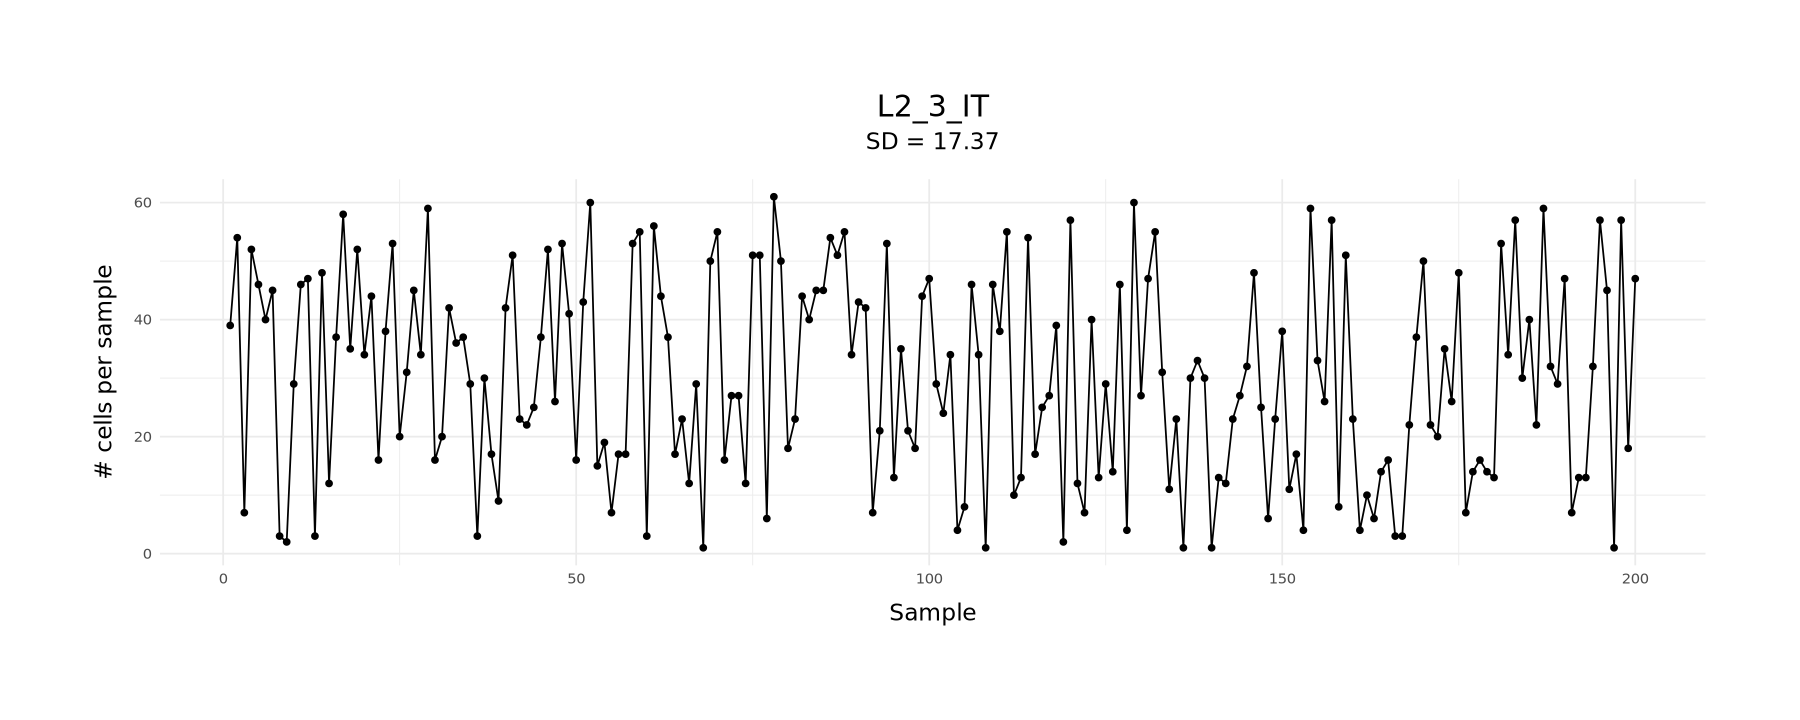

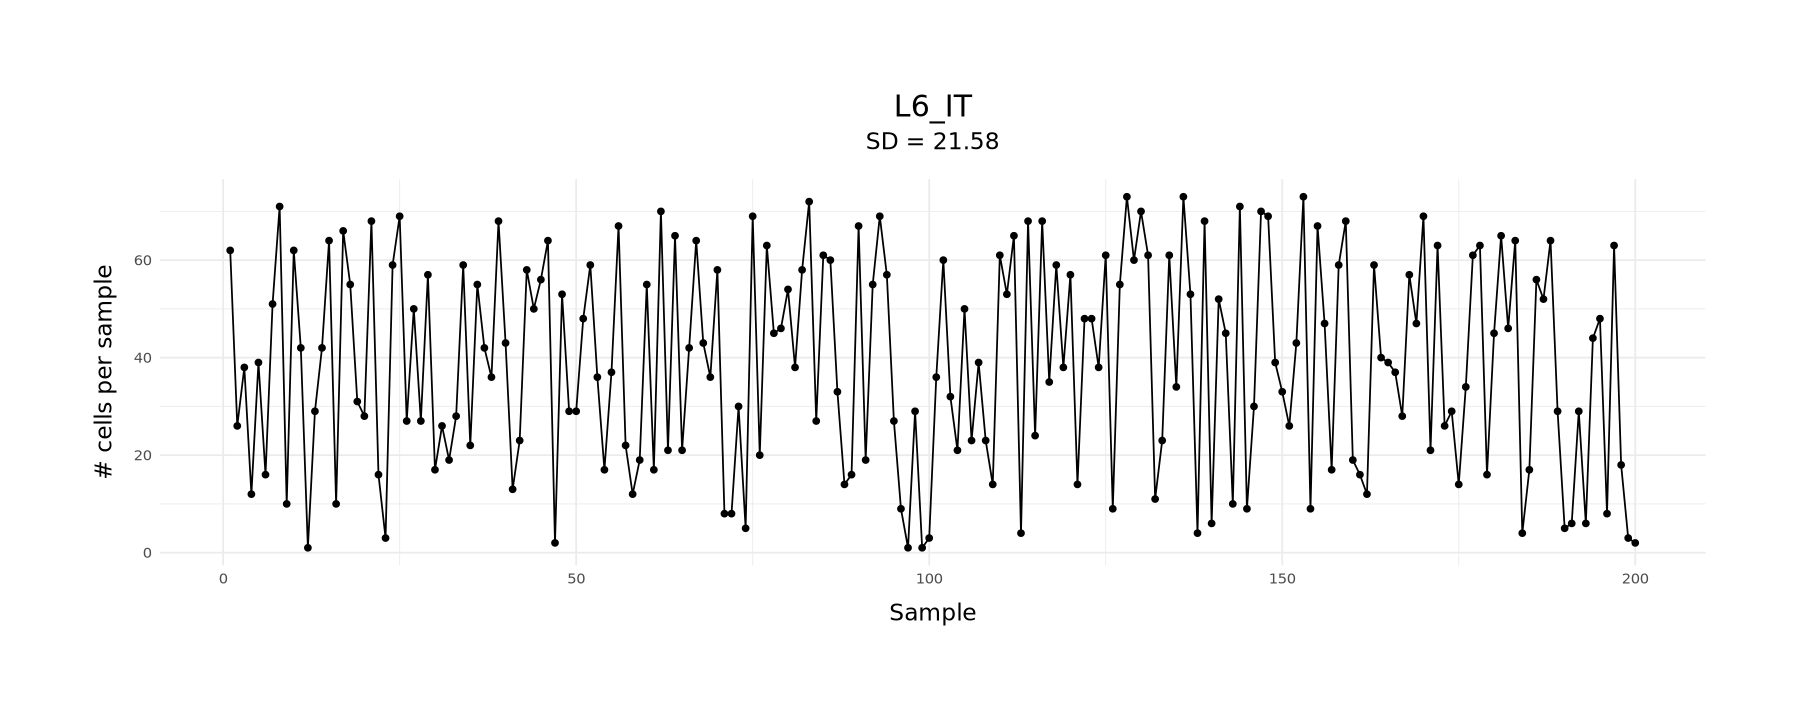

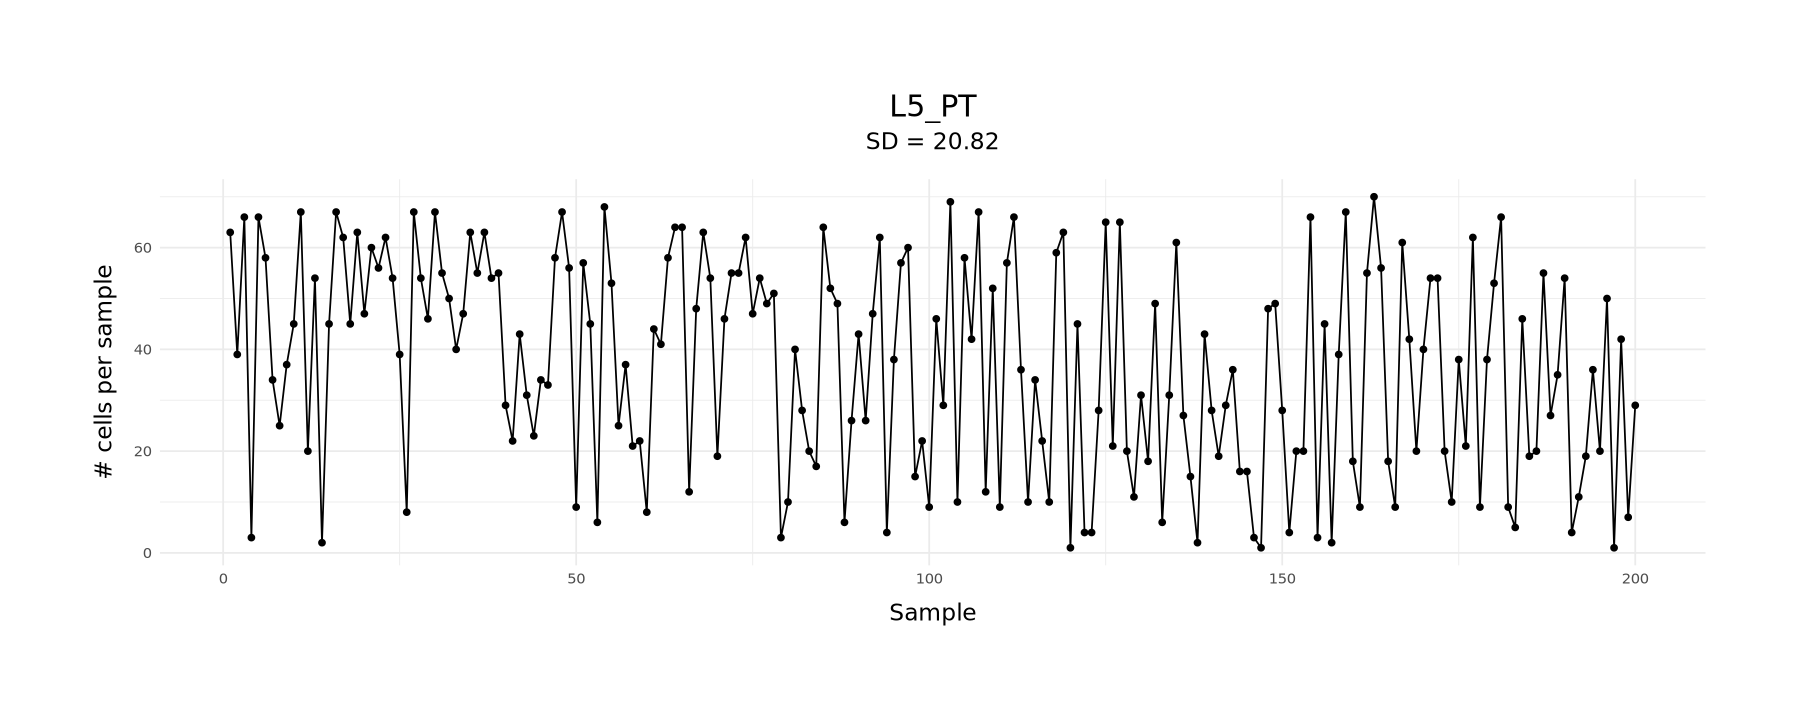

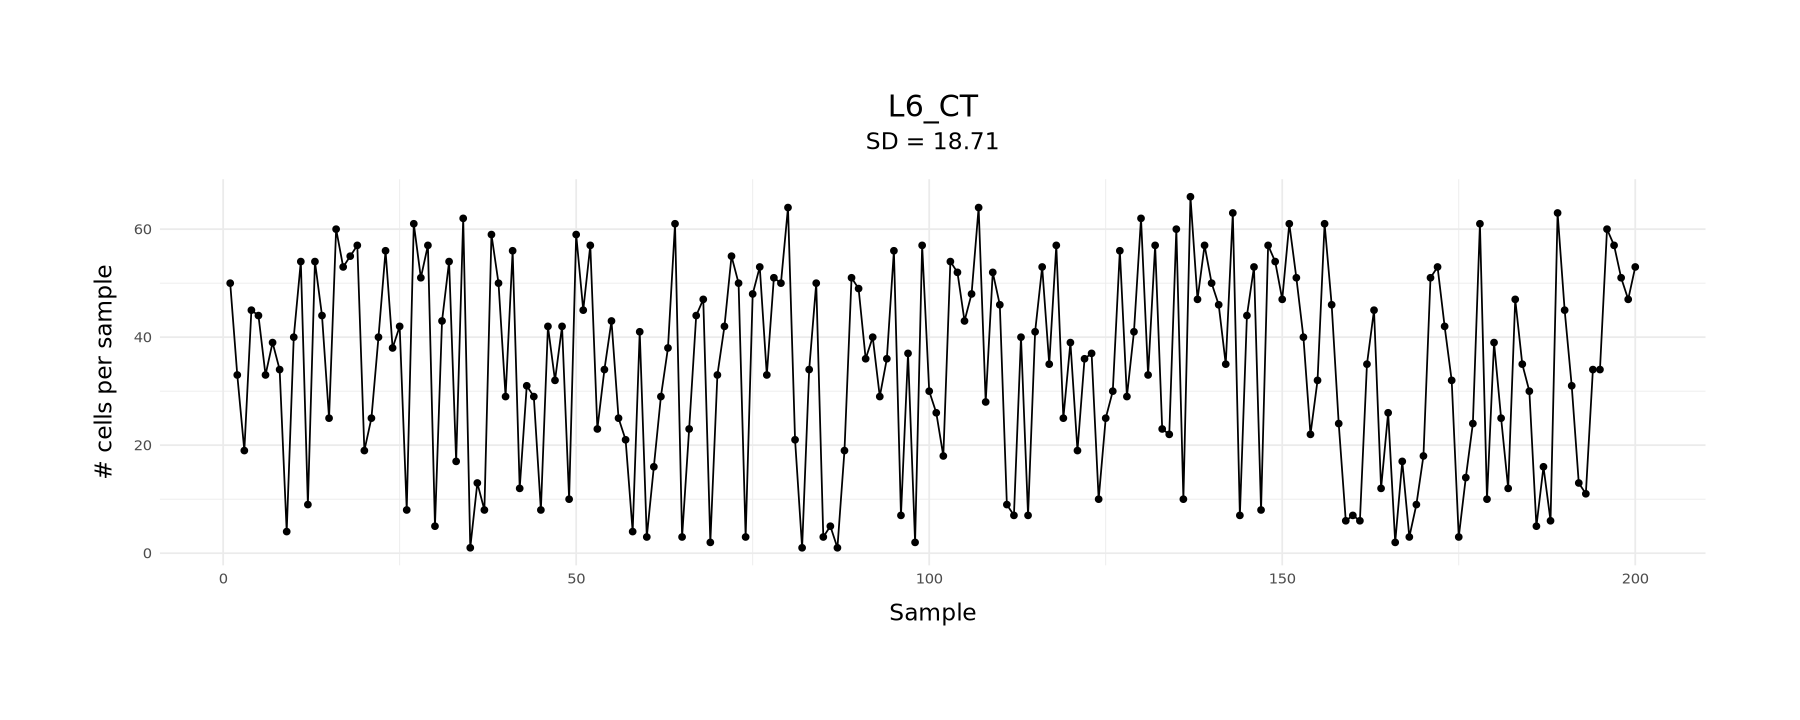

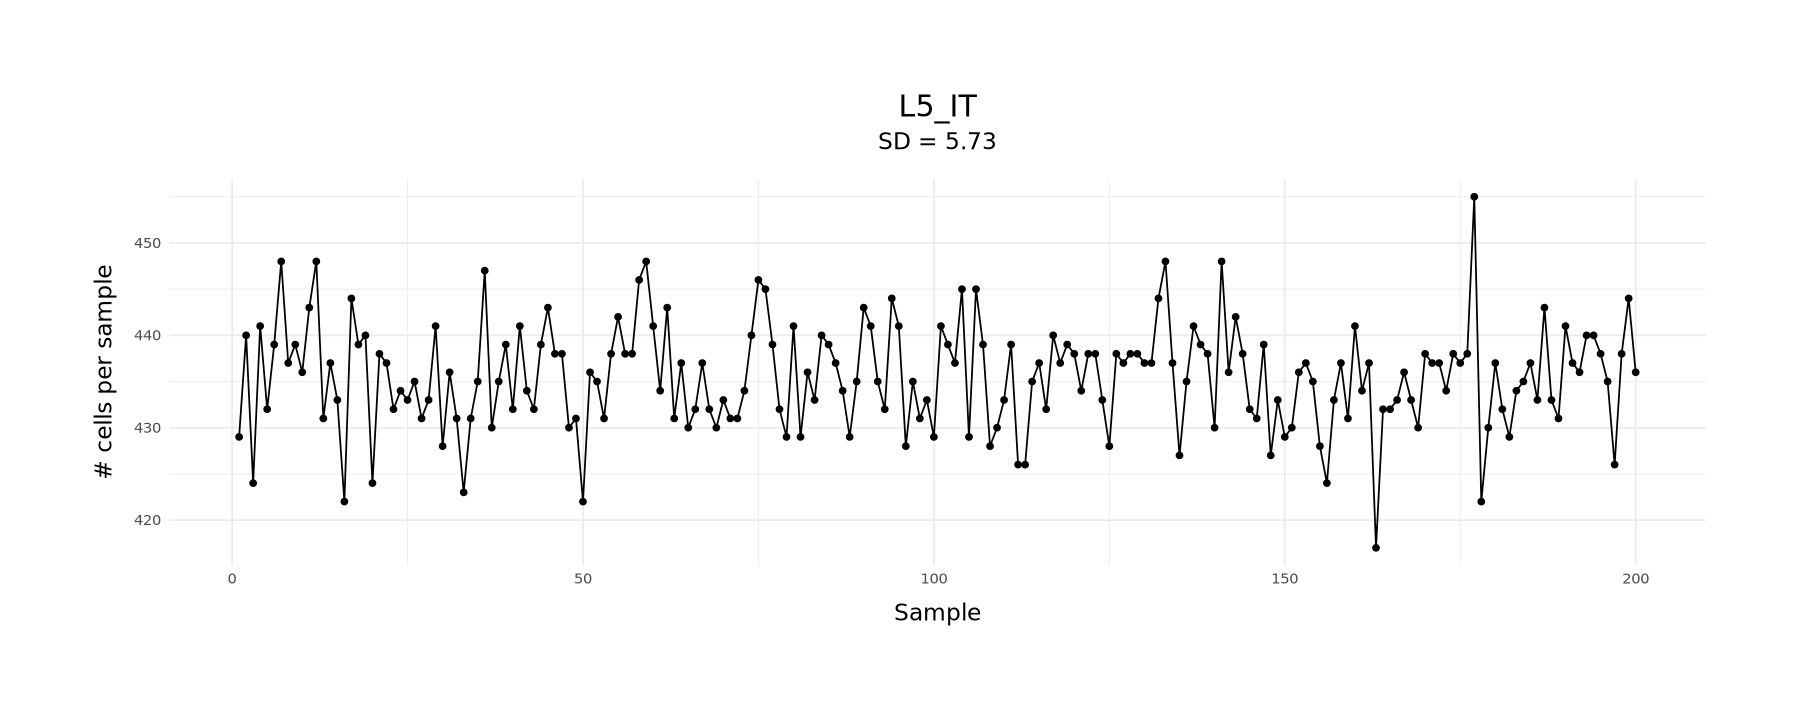

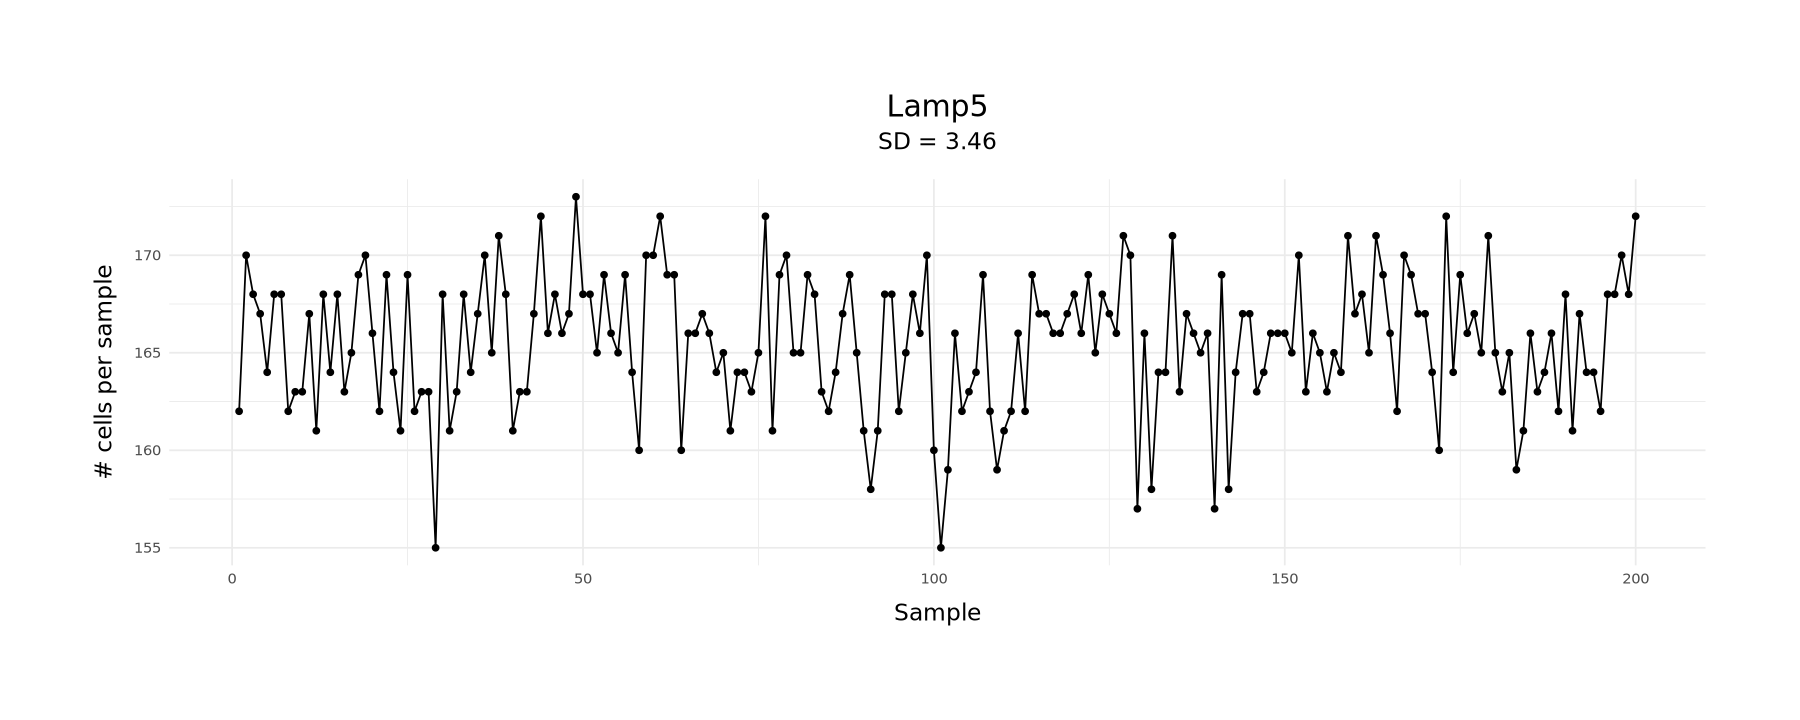

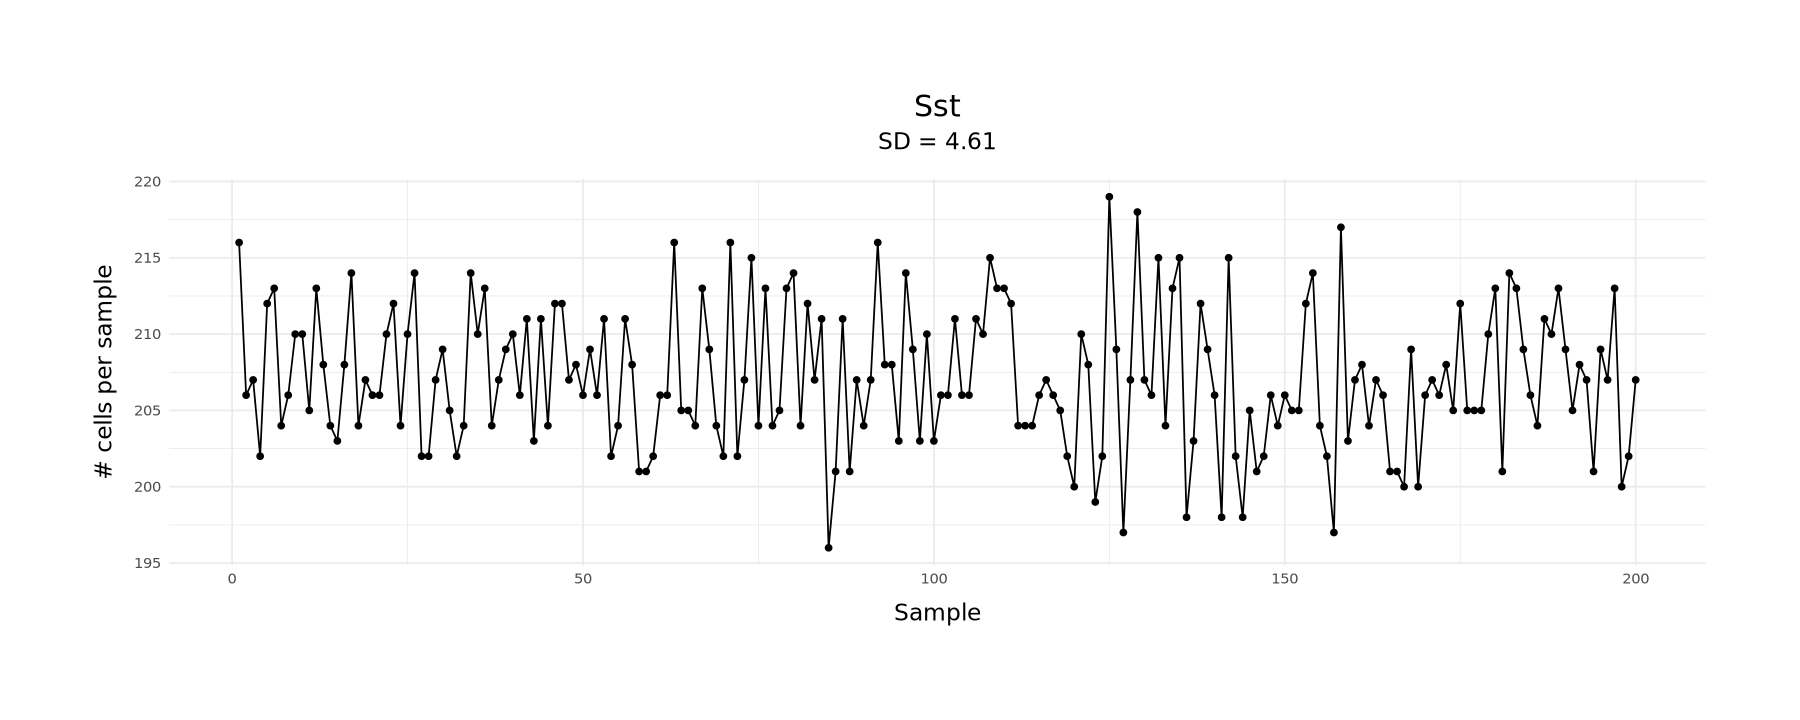

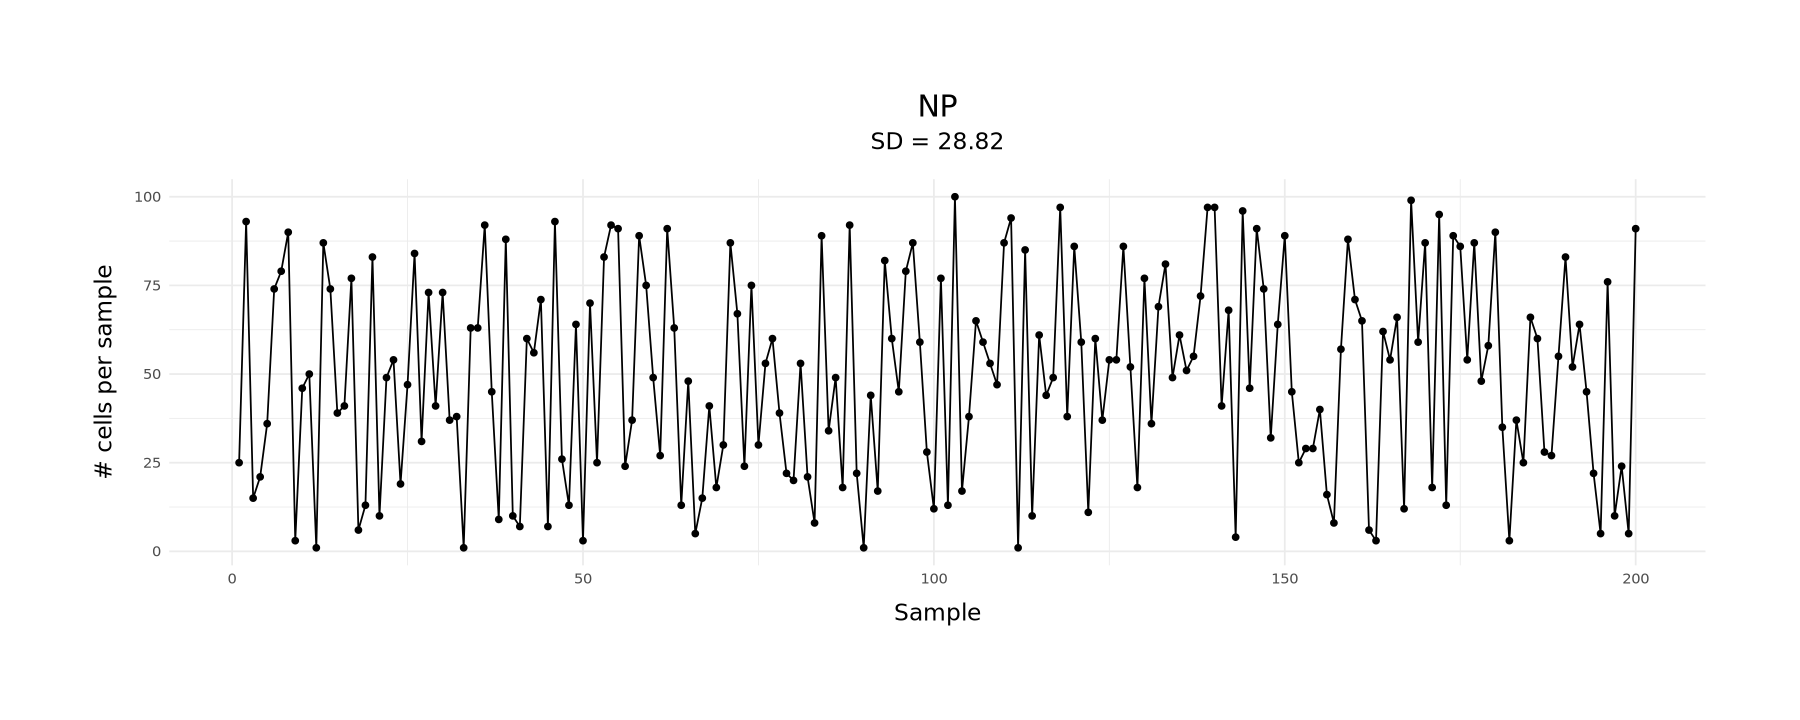

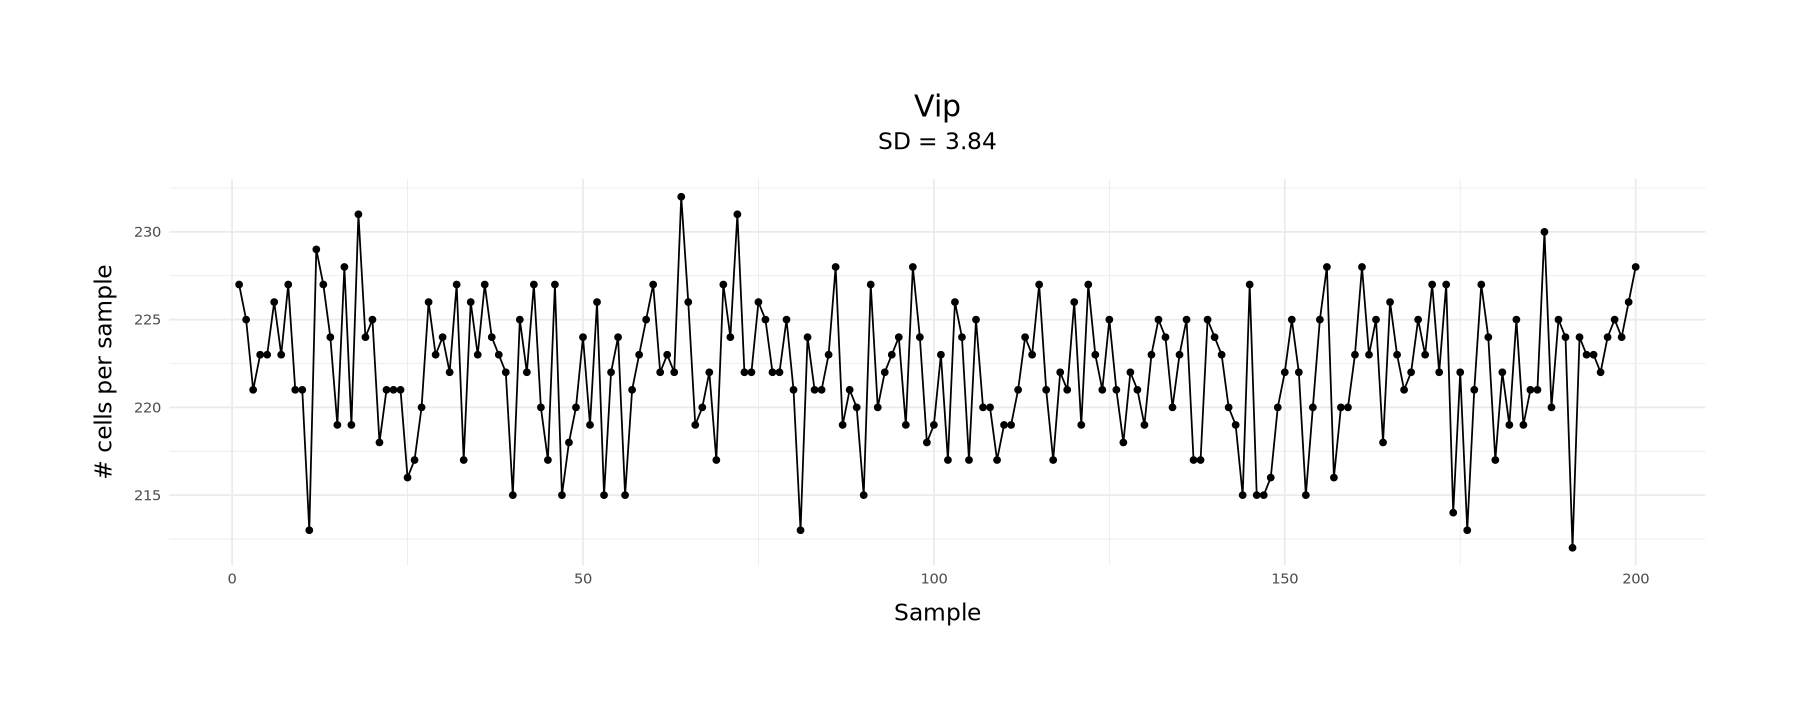

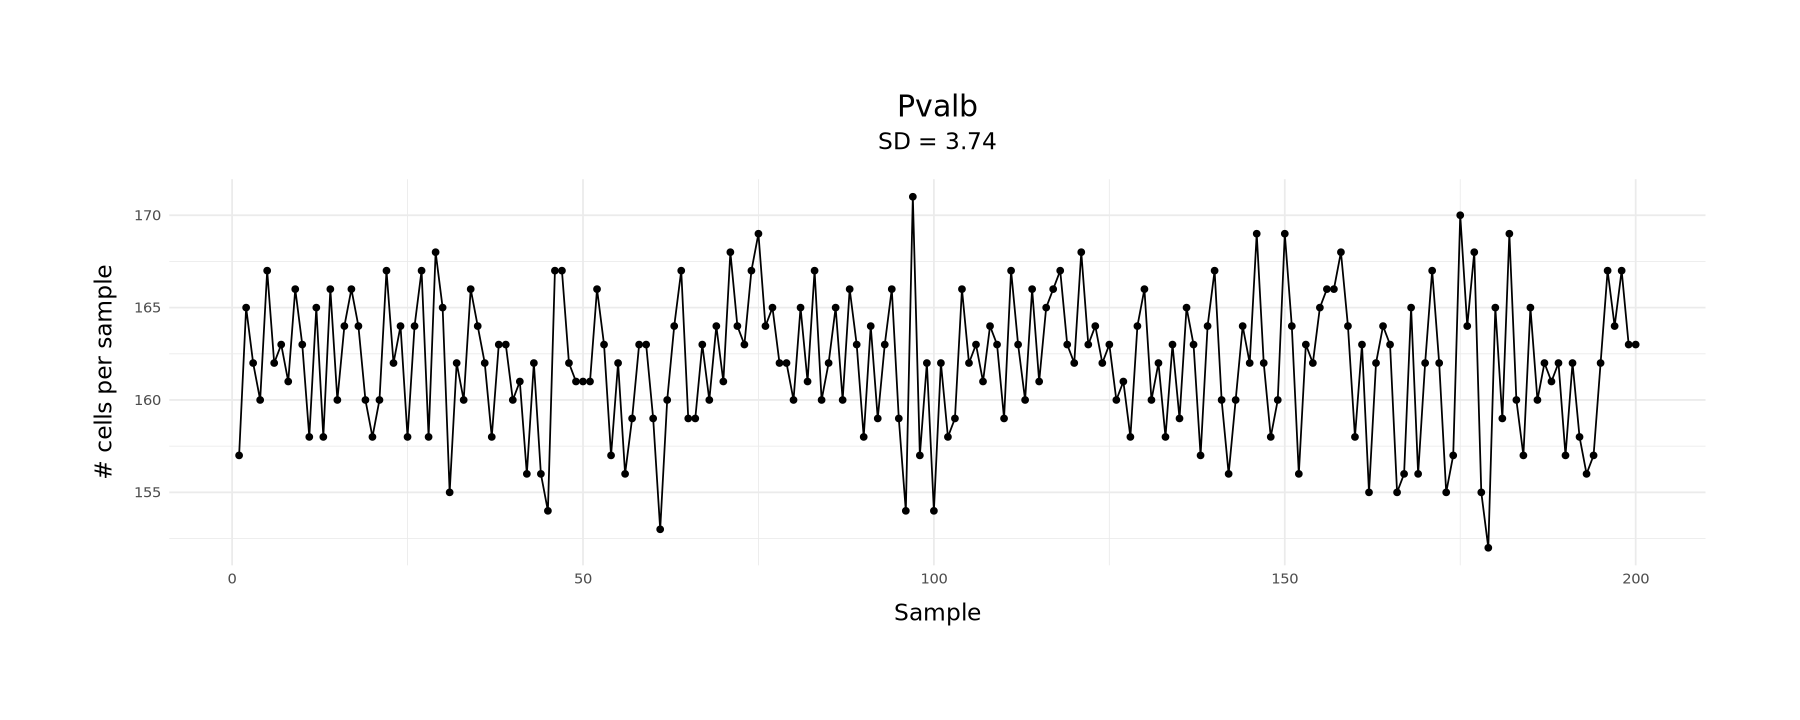

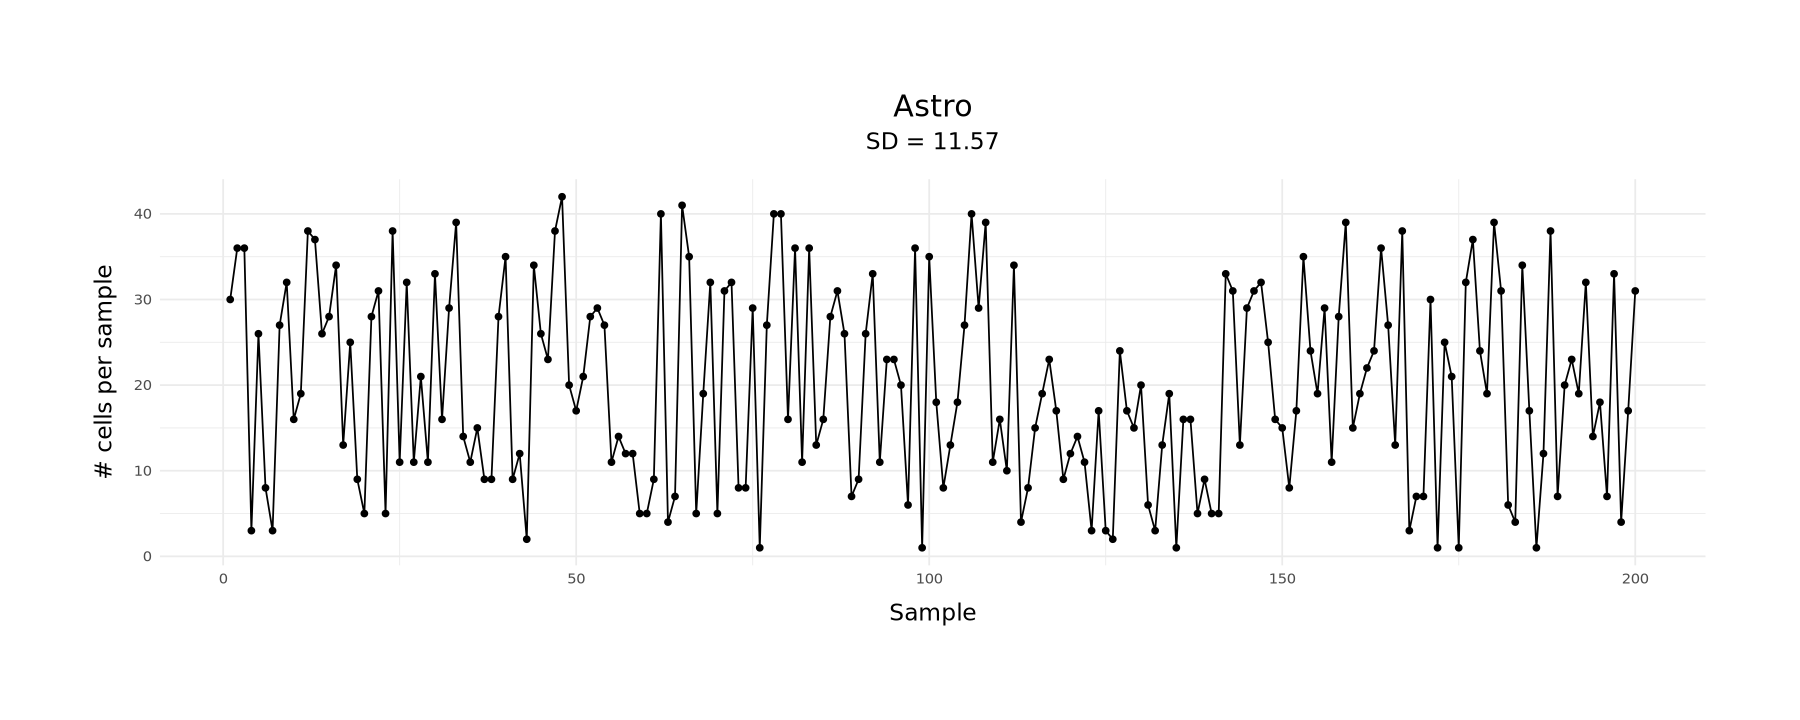

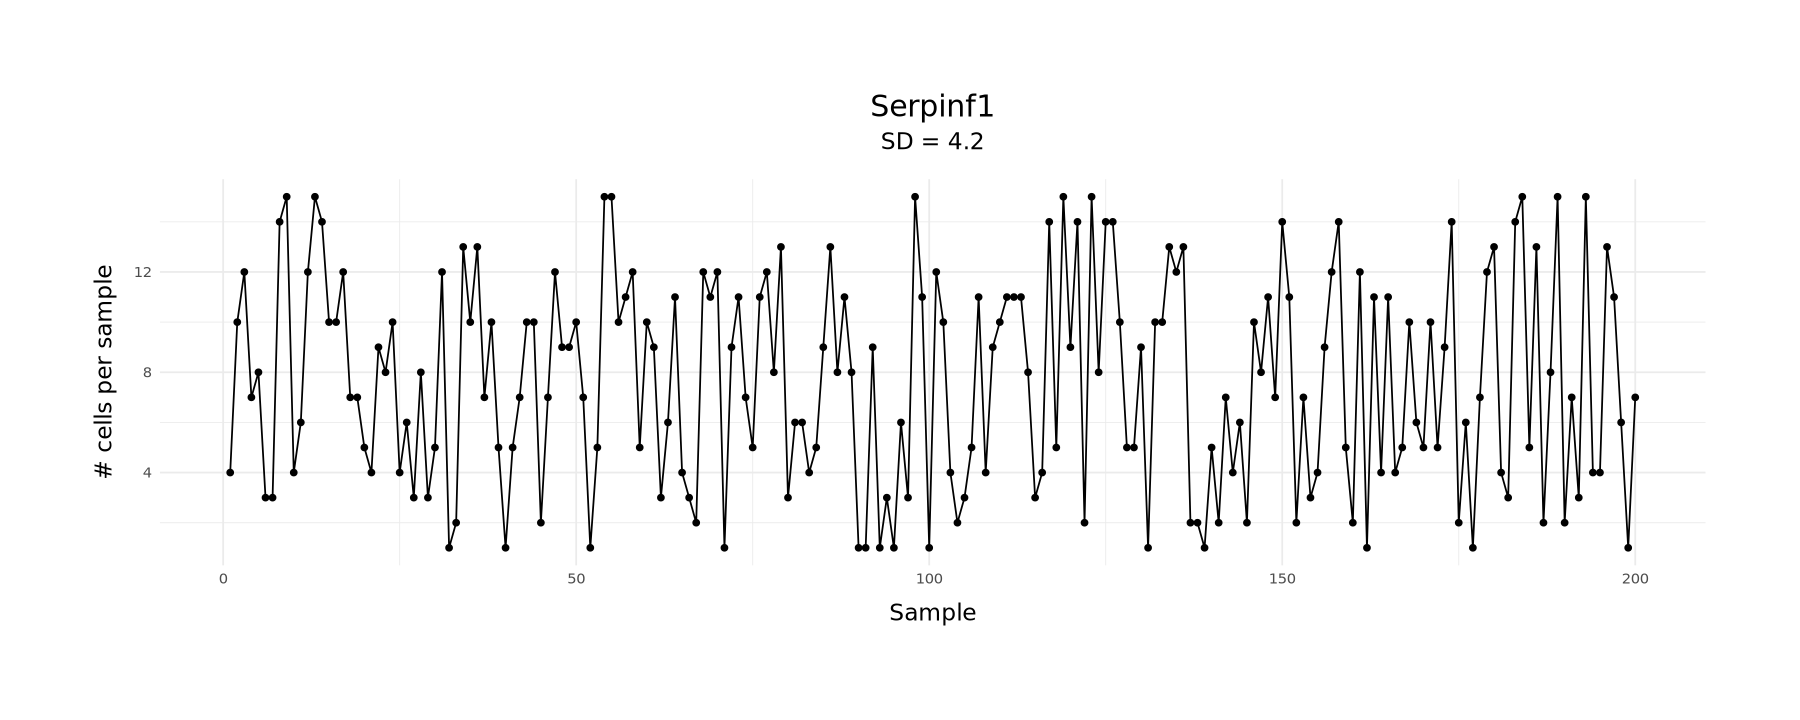

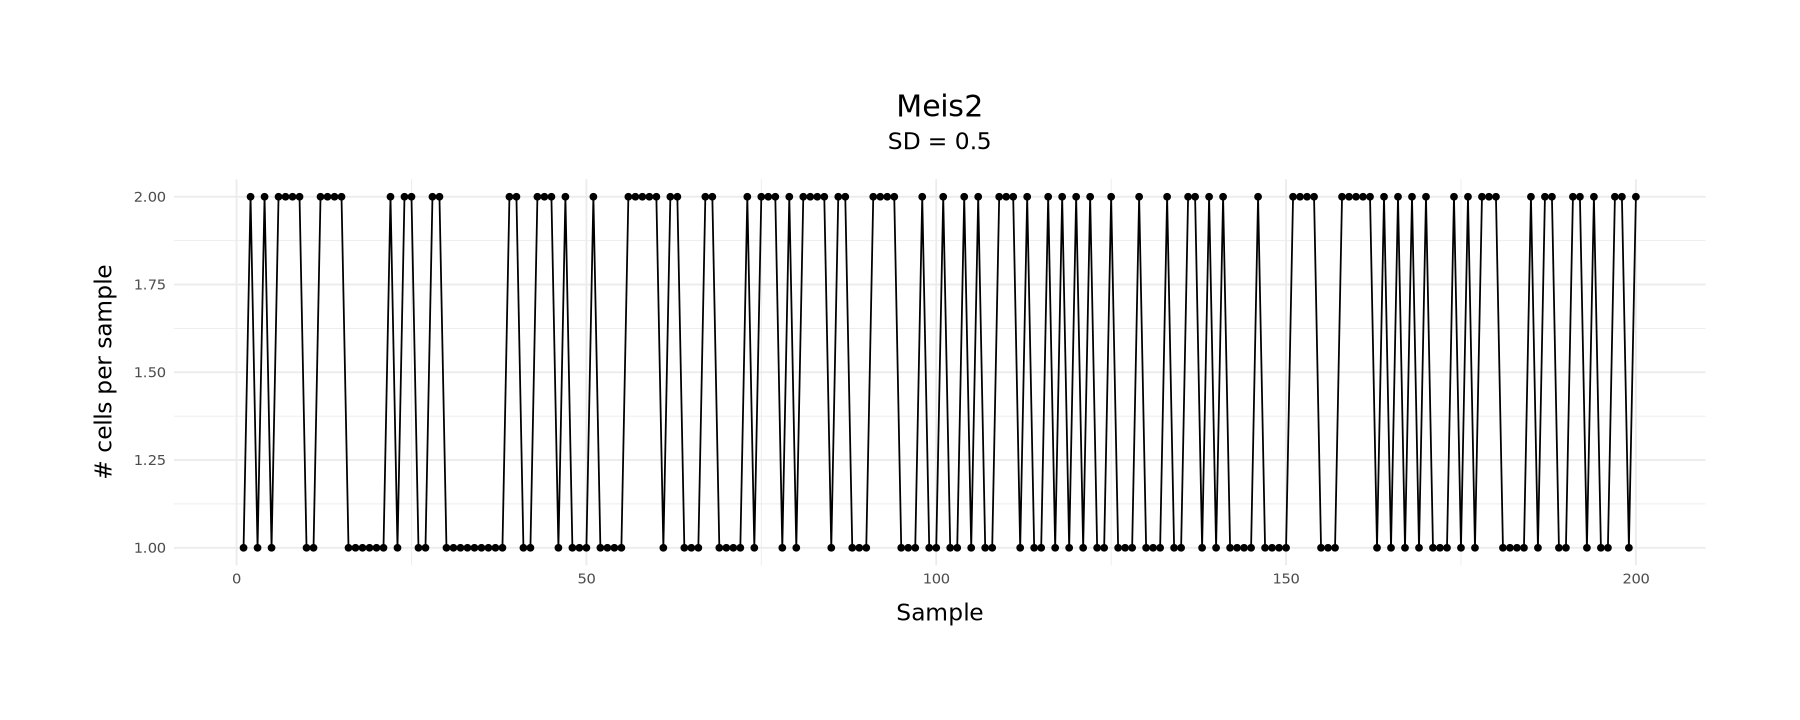

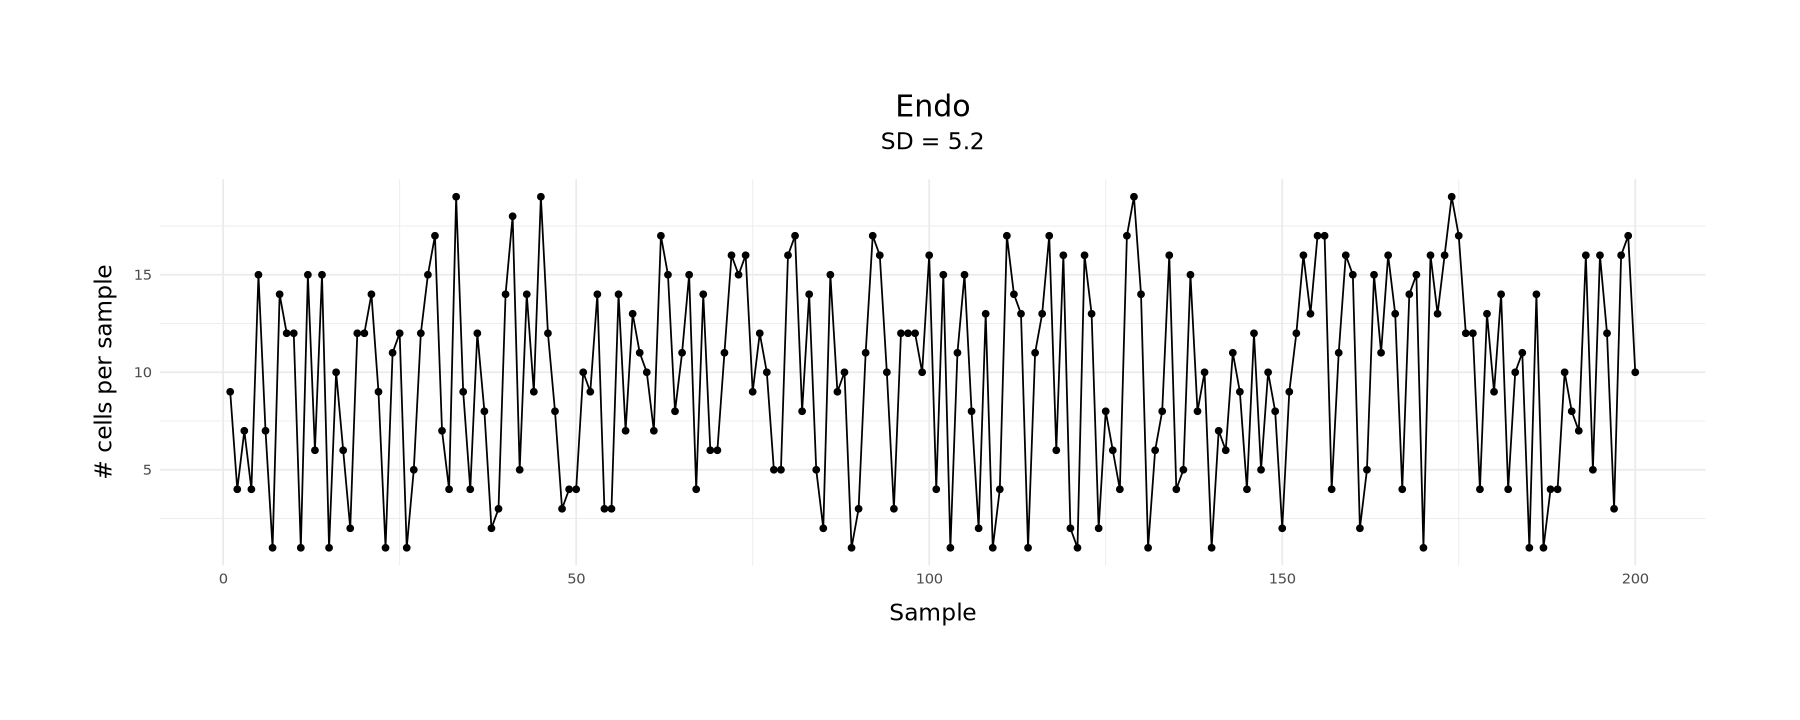

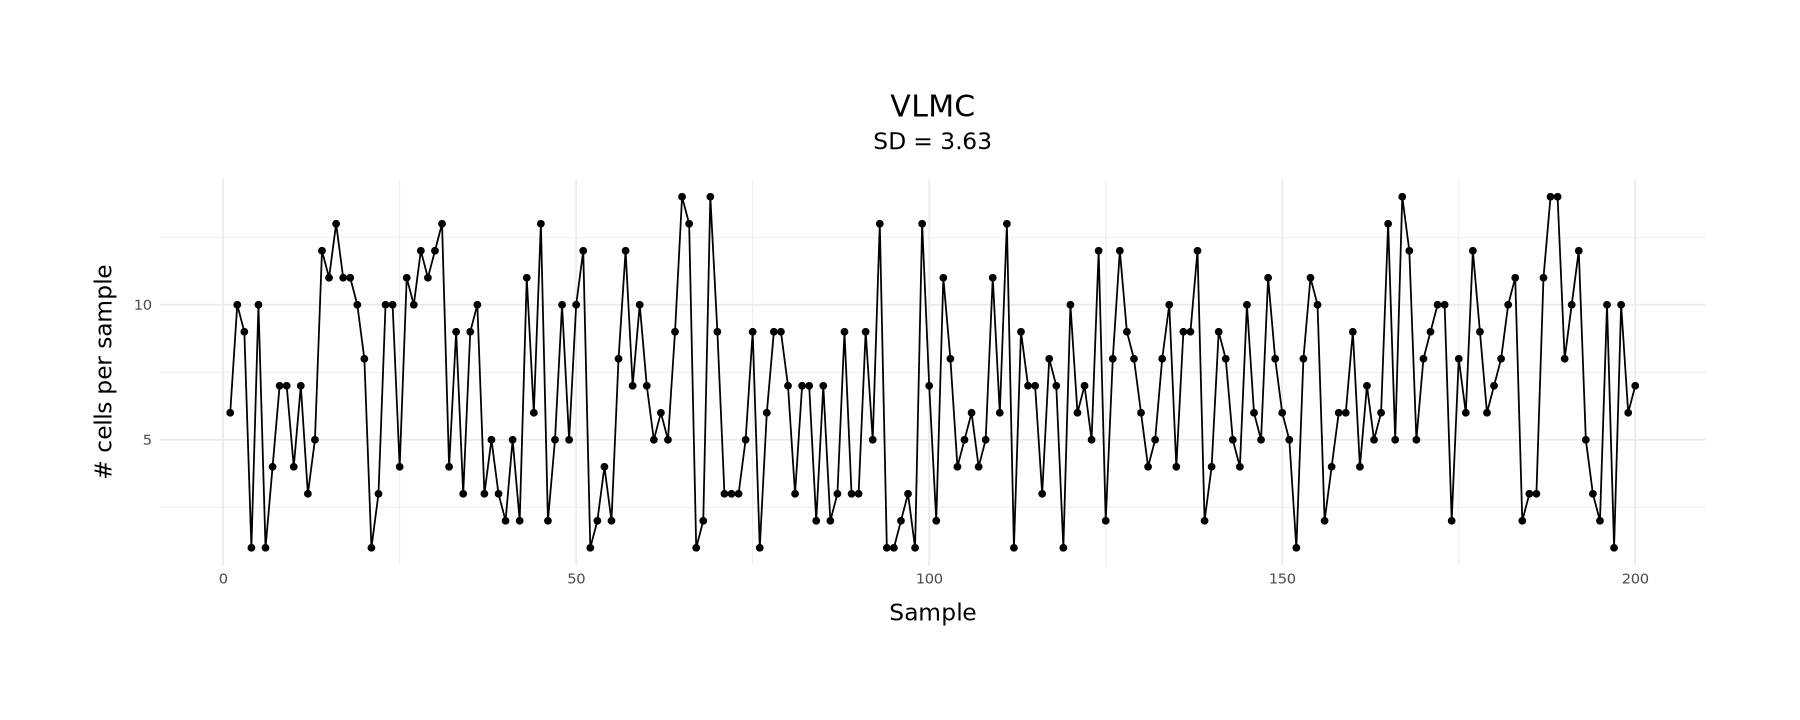

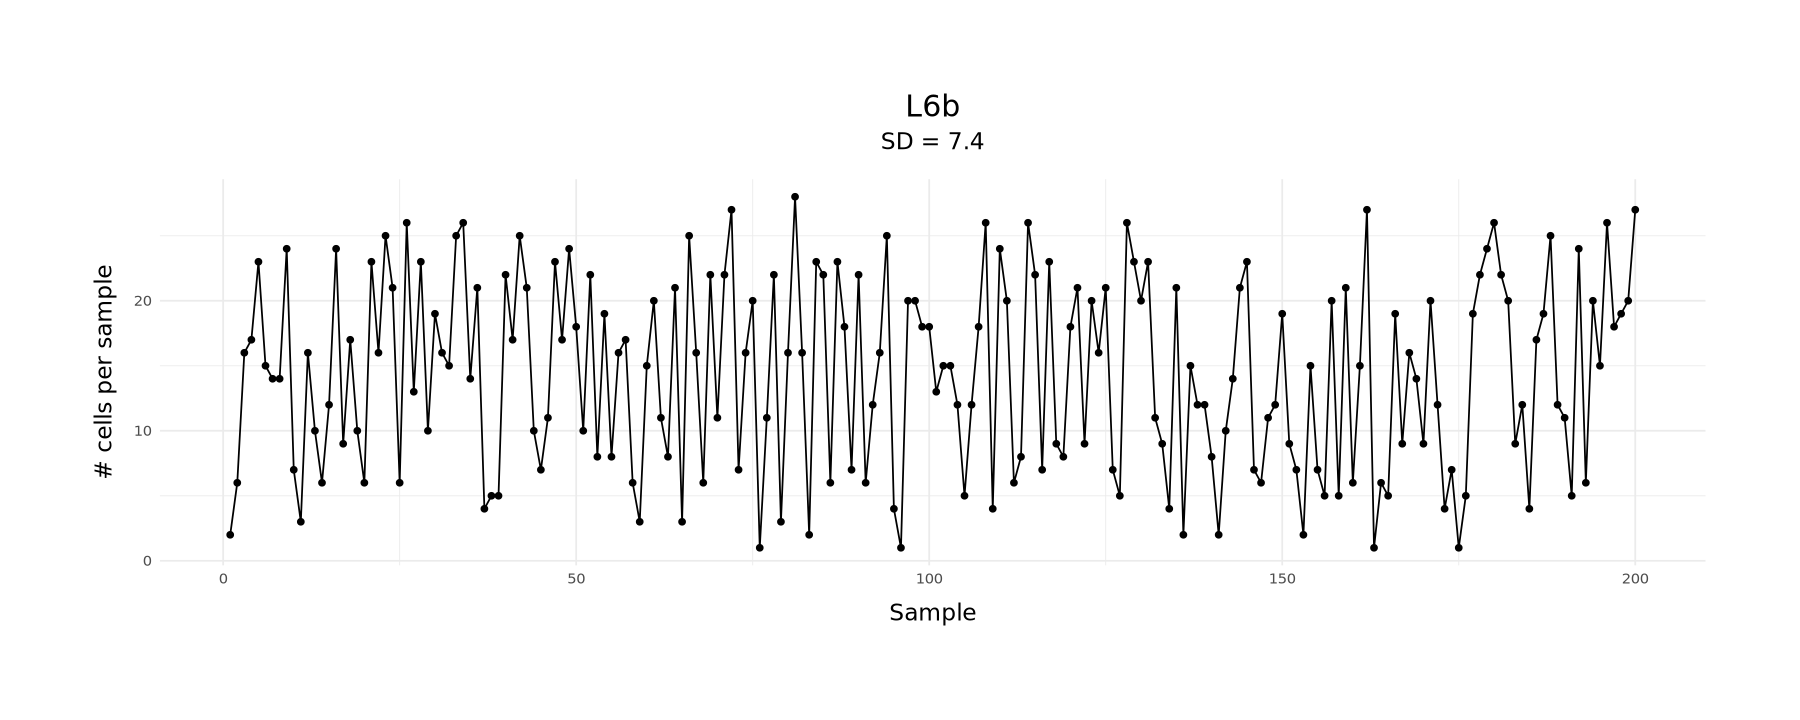

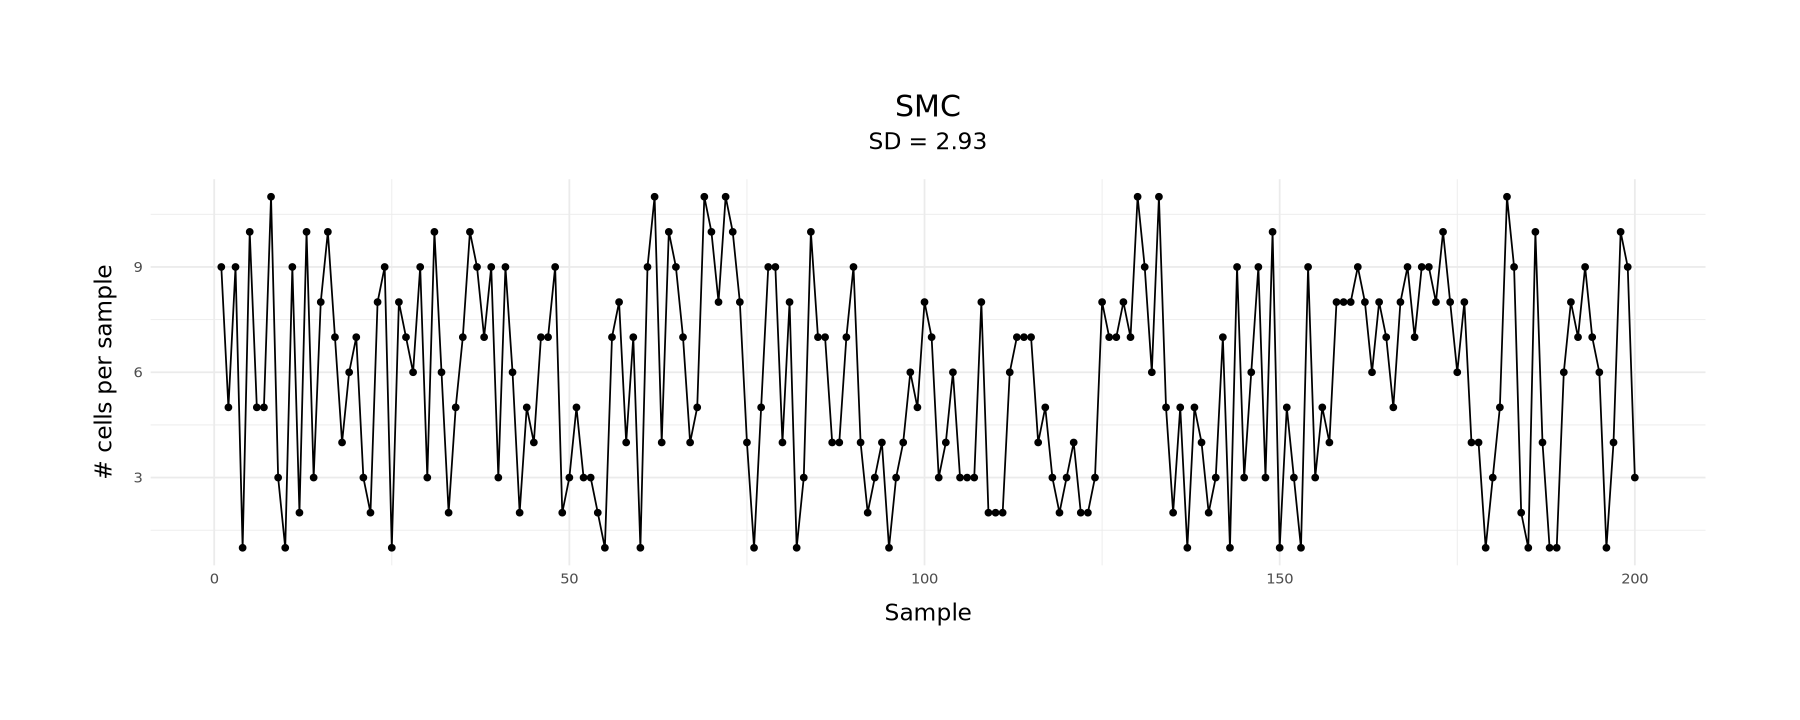

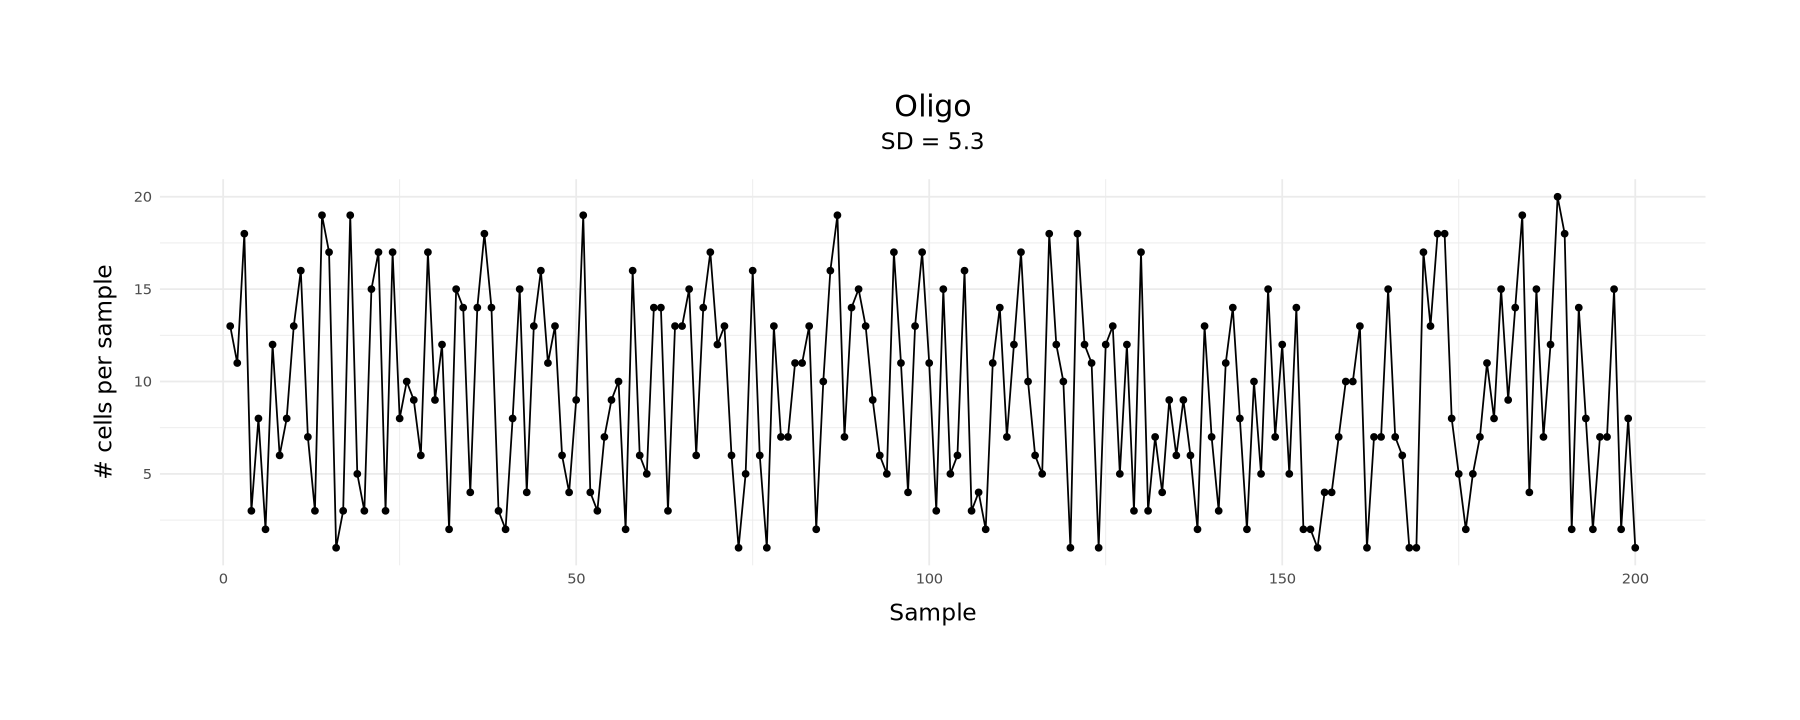

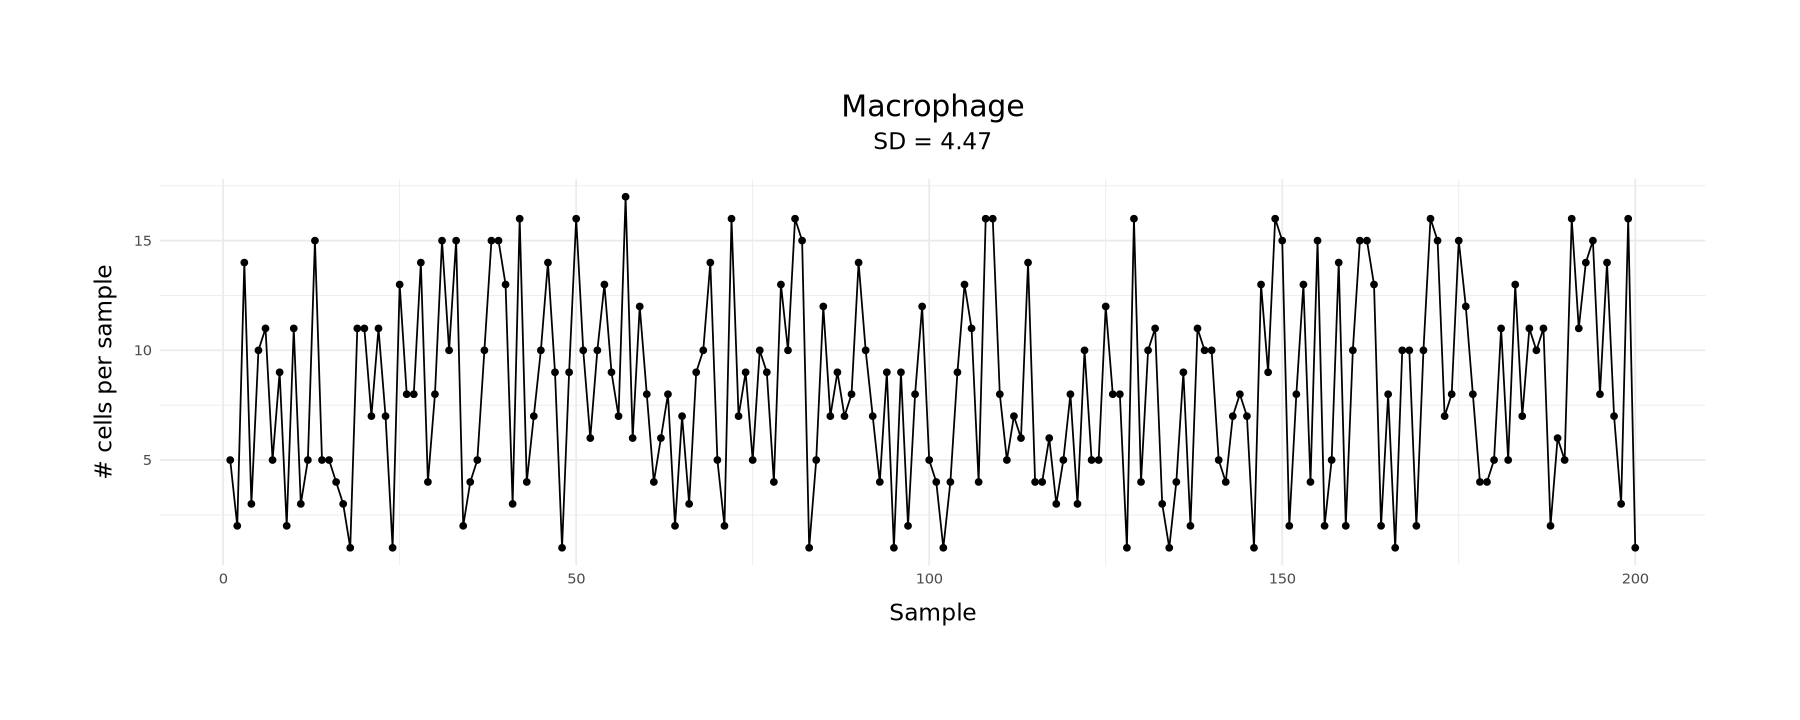

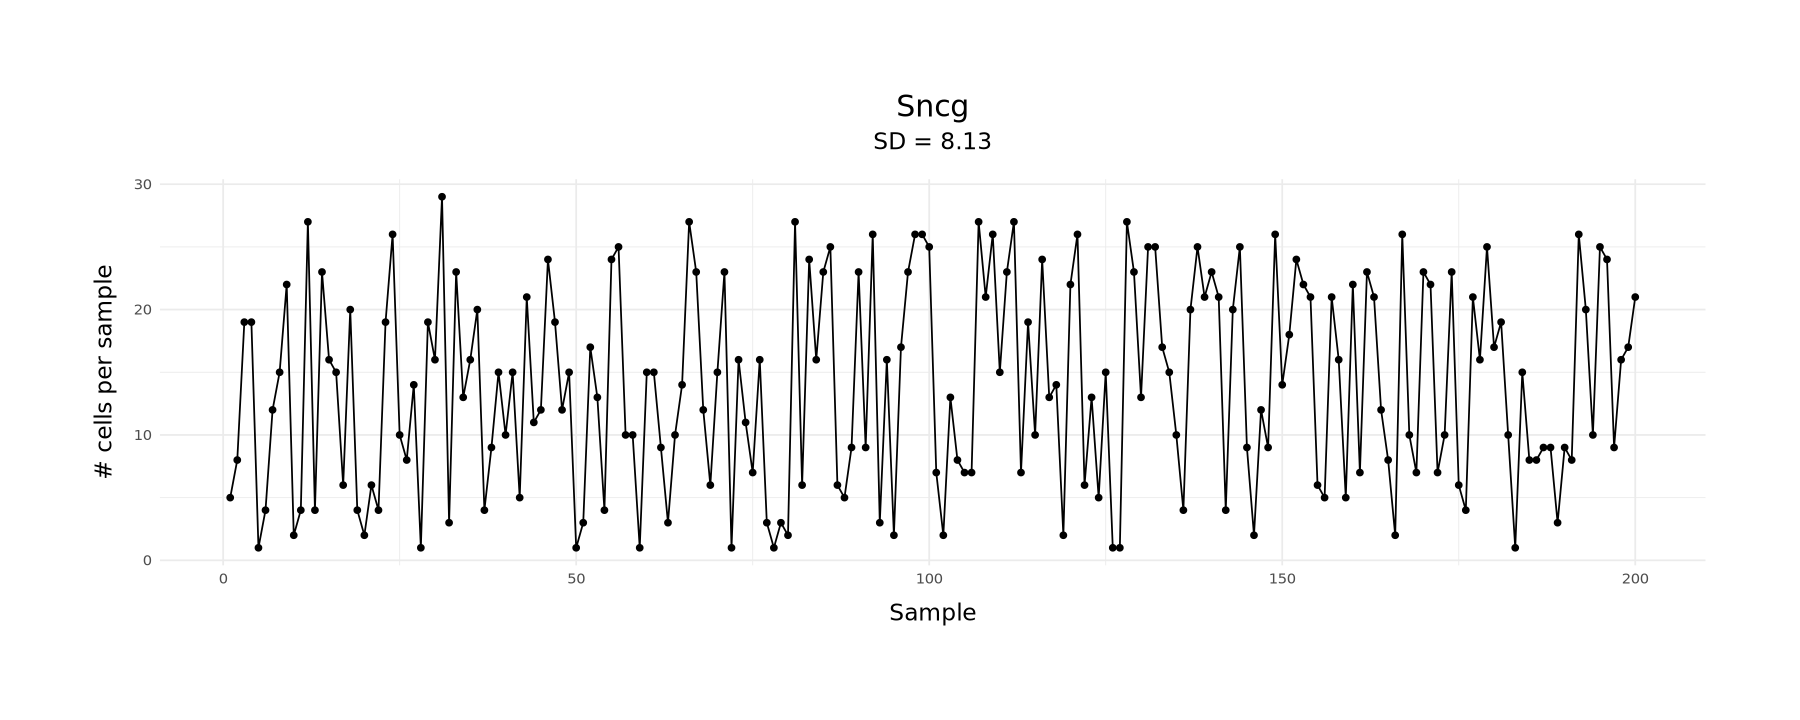

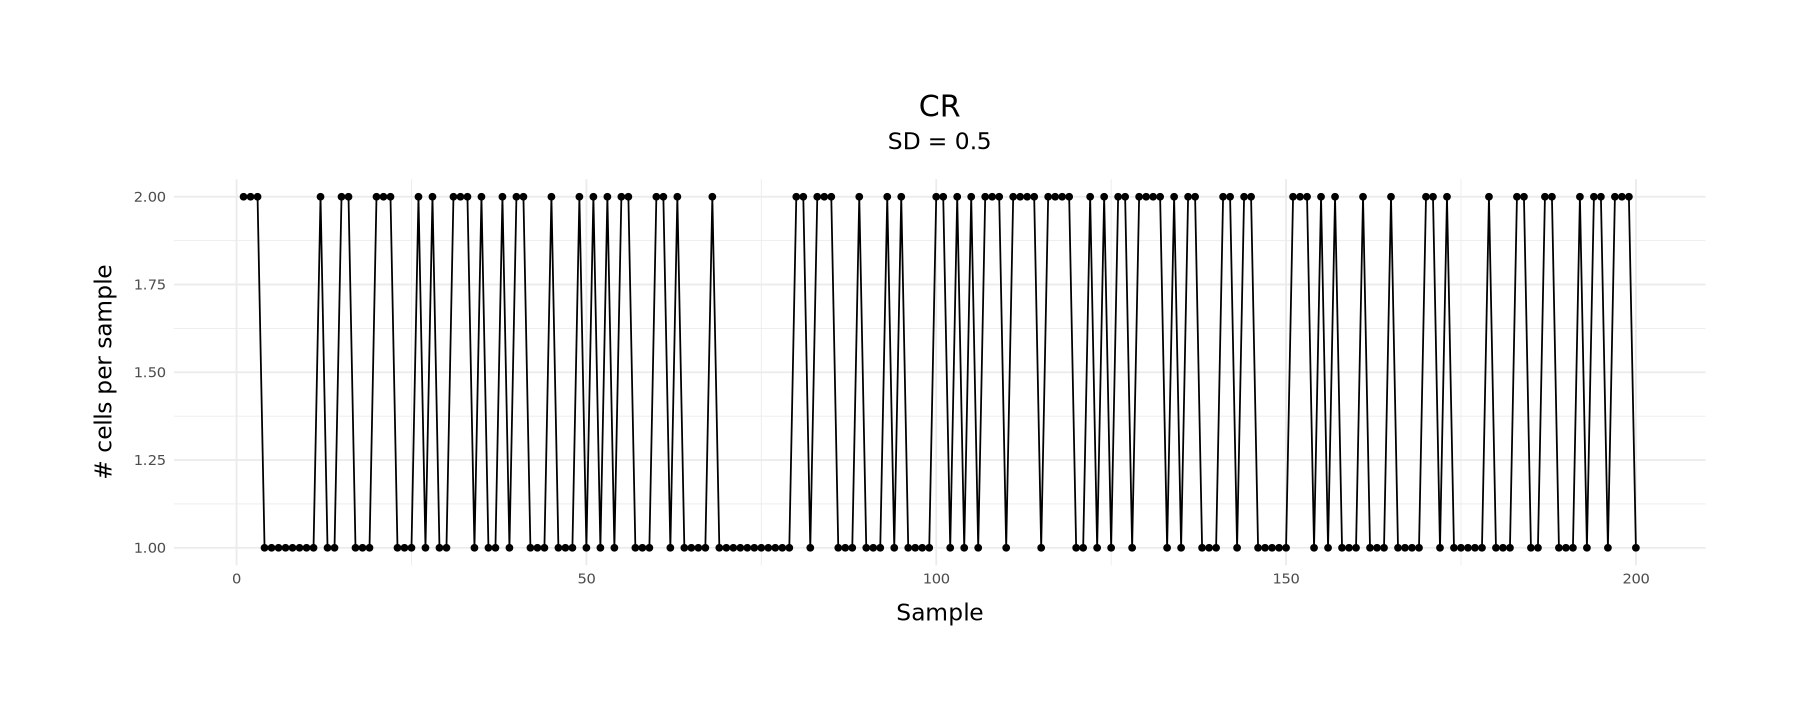

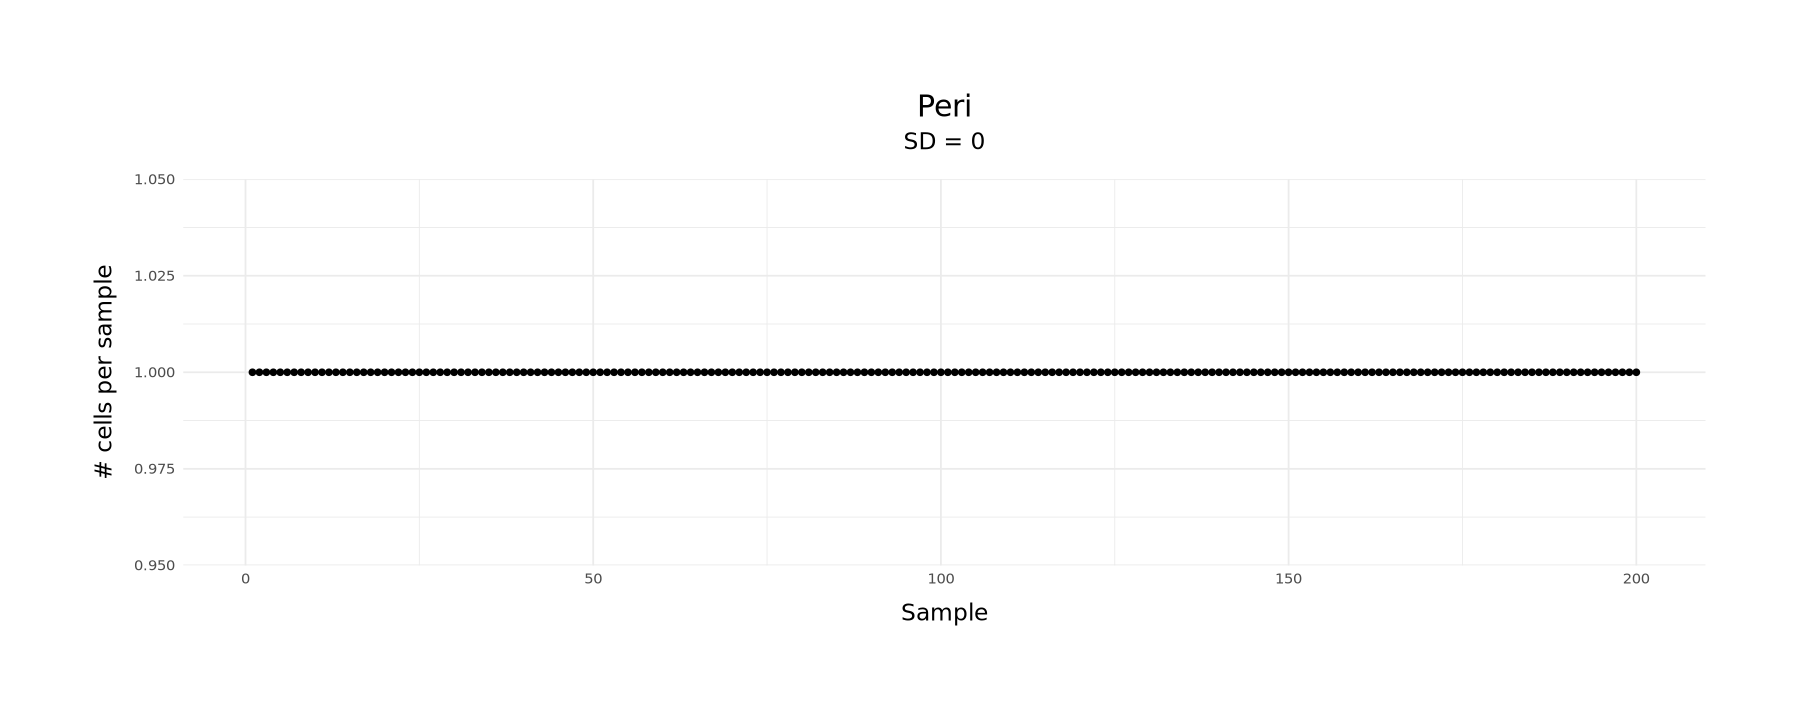

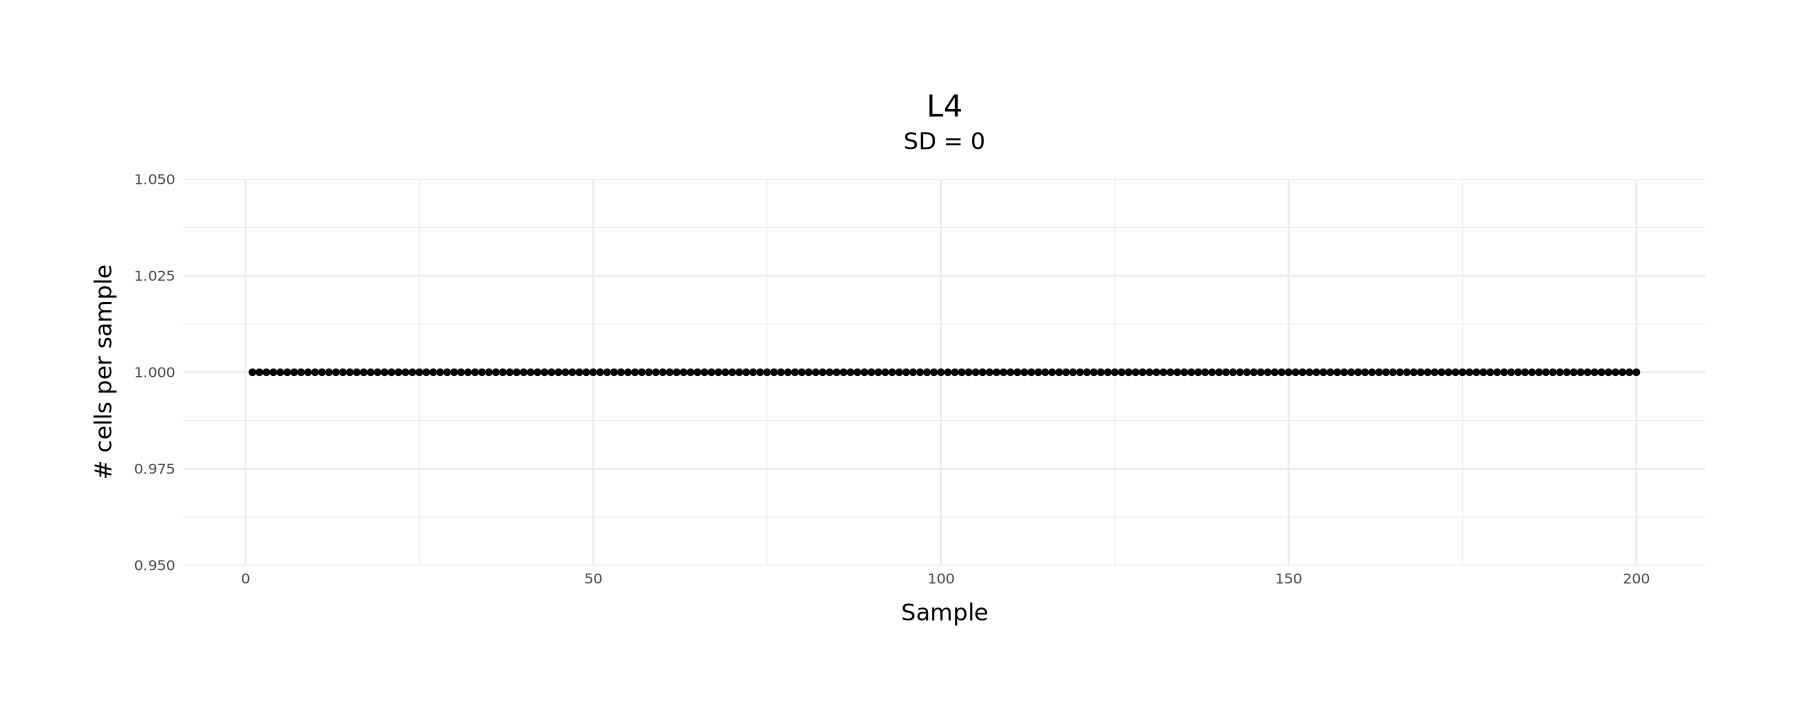

In [10]:
plot_ctype_abundance(pseudobulk_legend)

# Round 3 (0.4% var network; PosBC module definiton)

In [11]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_0.4pcntVar_200samples_legend_07-25-48.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_0.4pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

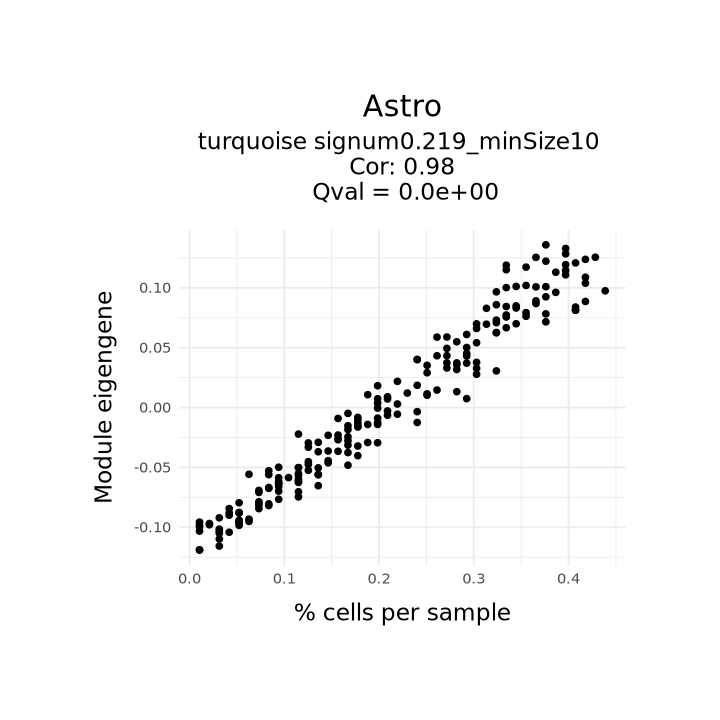

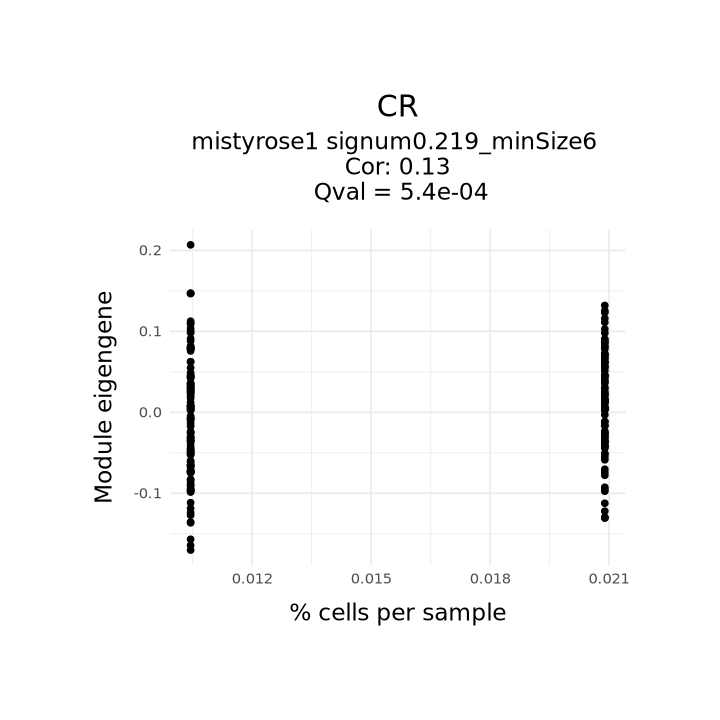

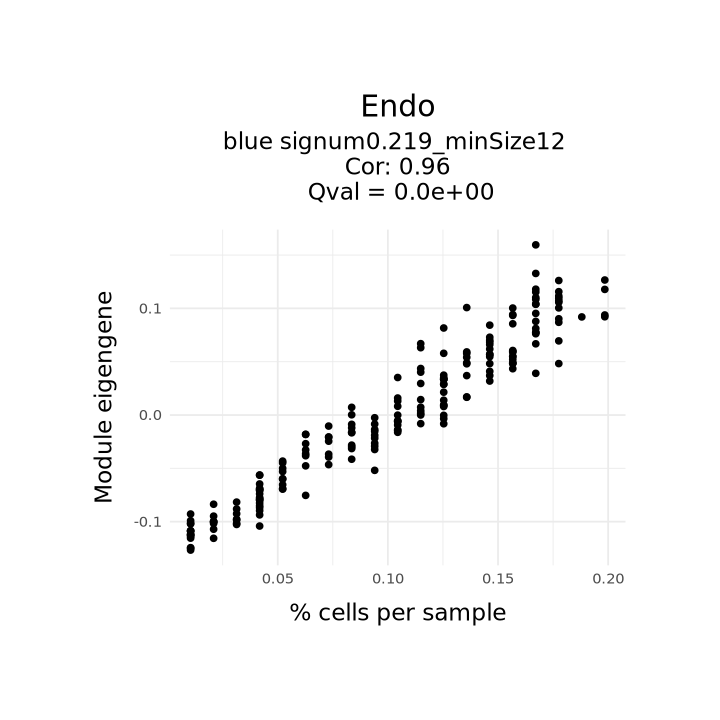

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


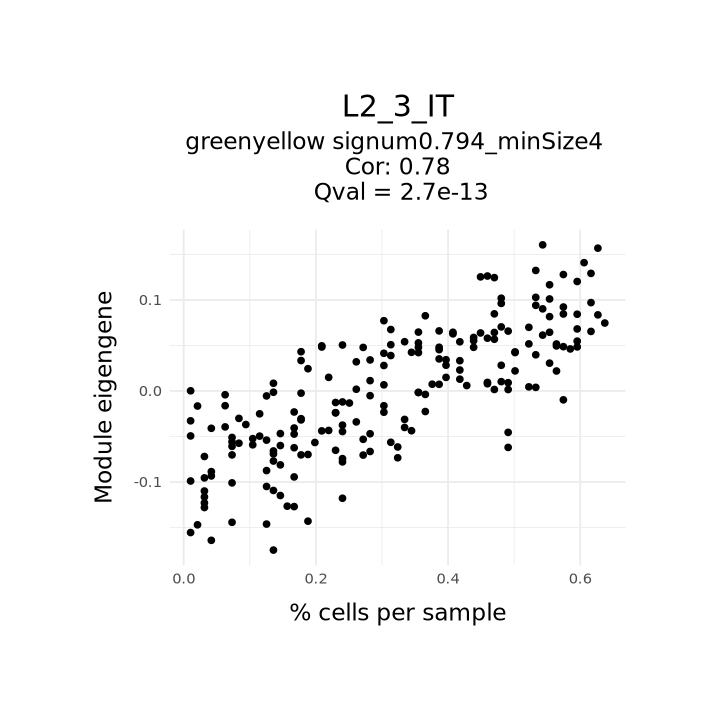

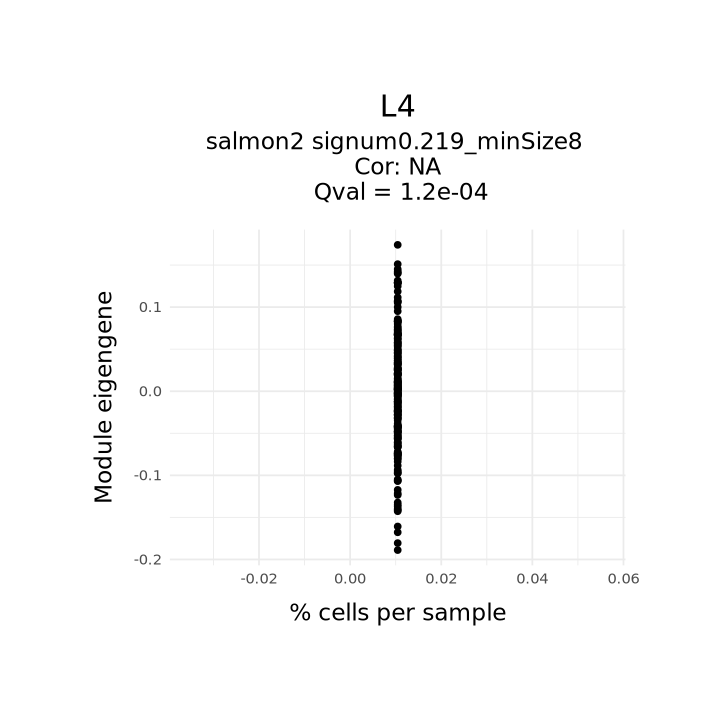

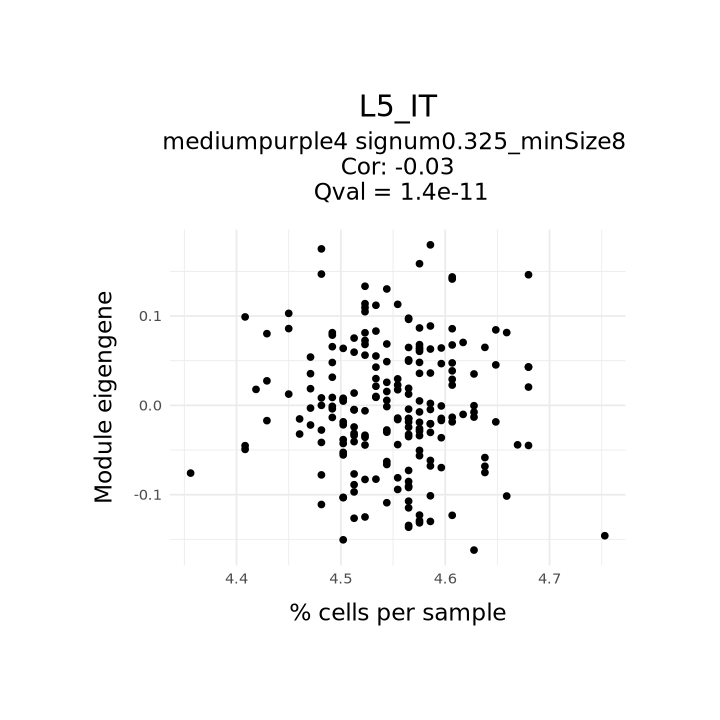

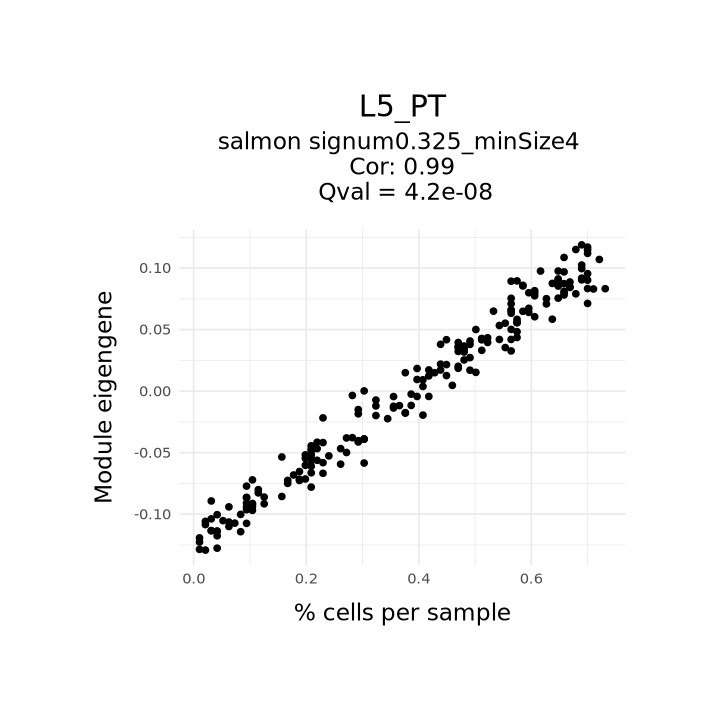

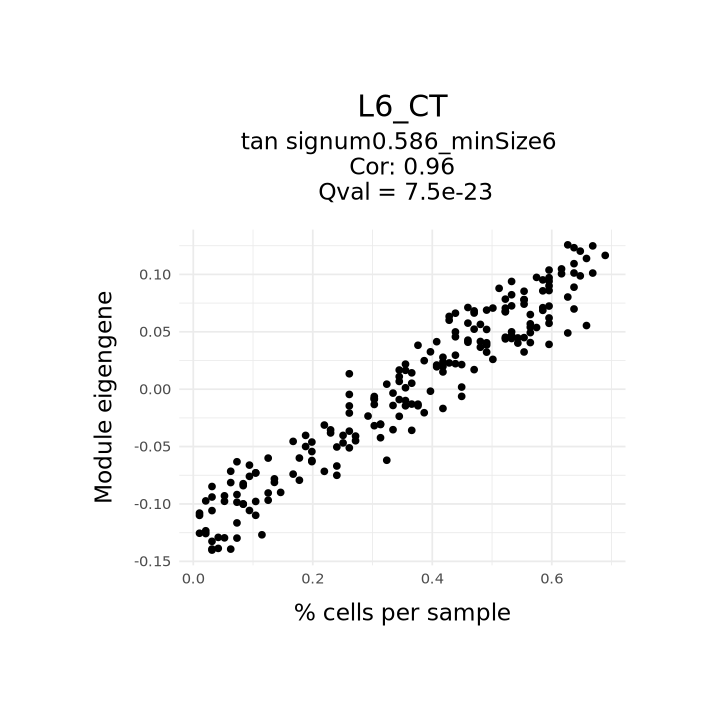

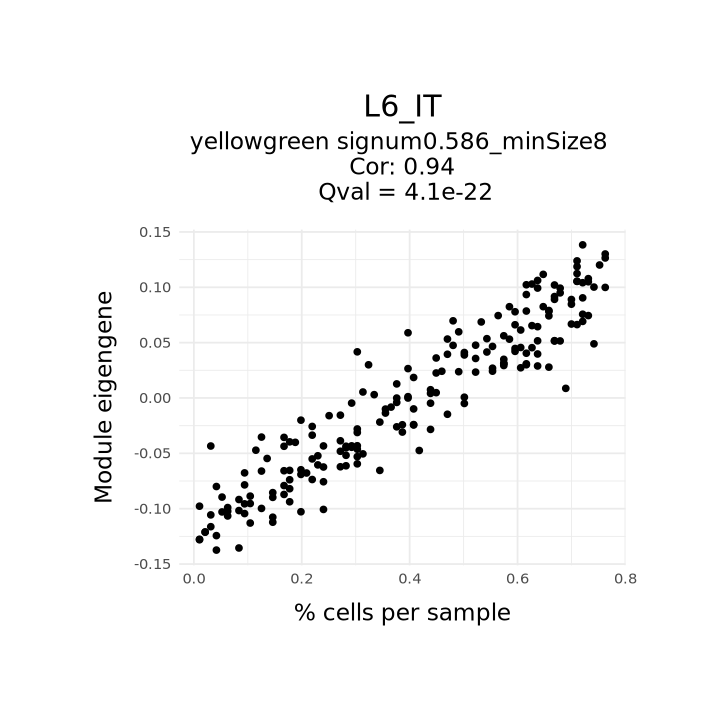

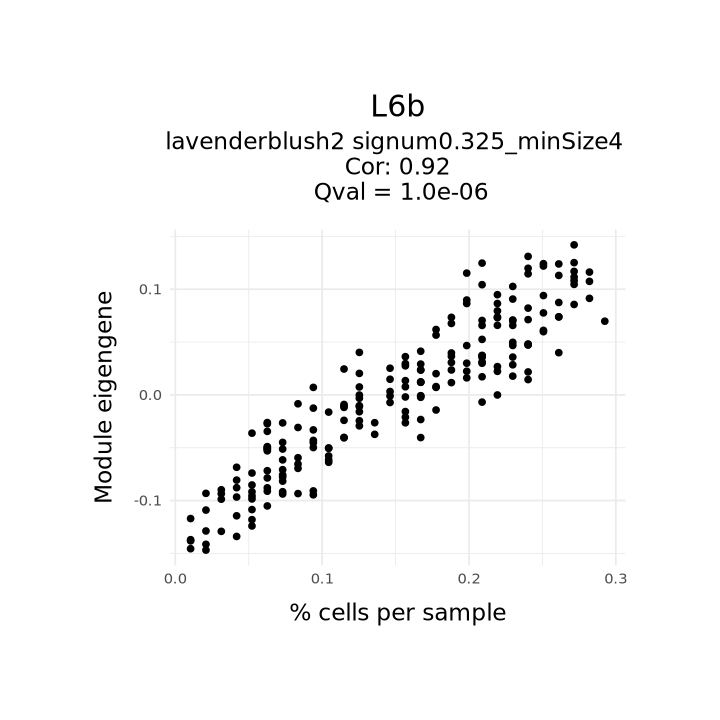

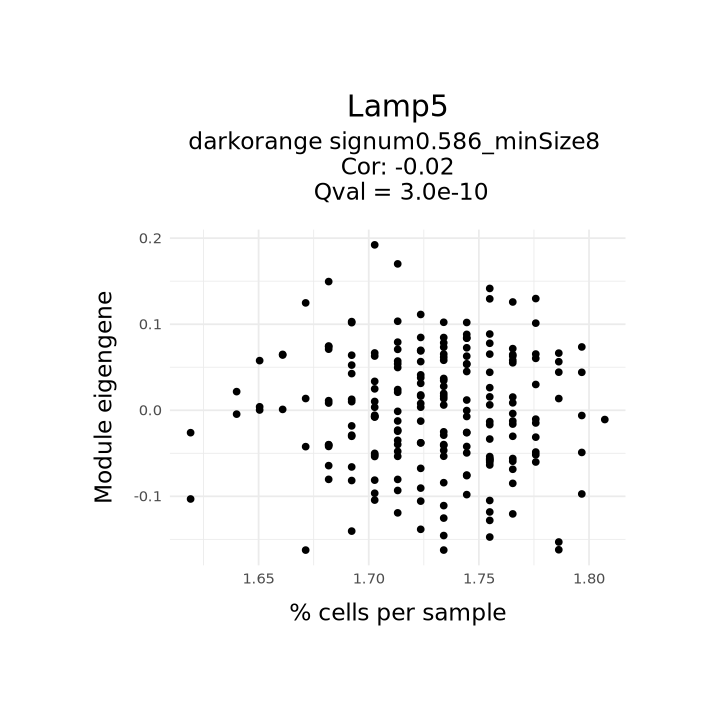

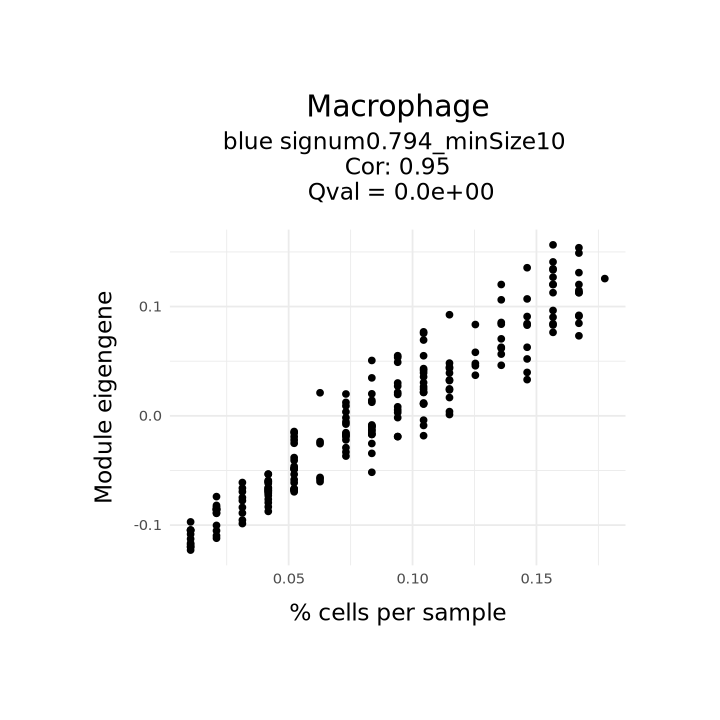

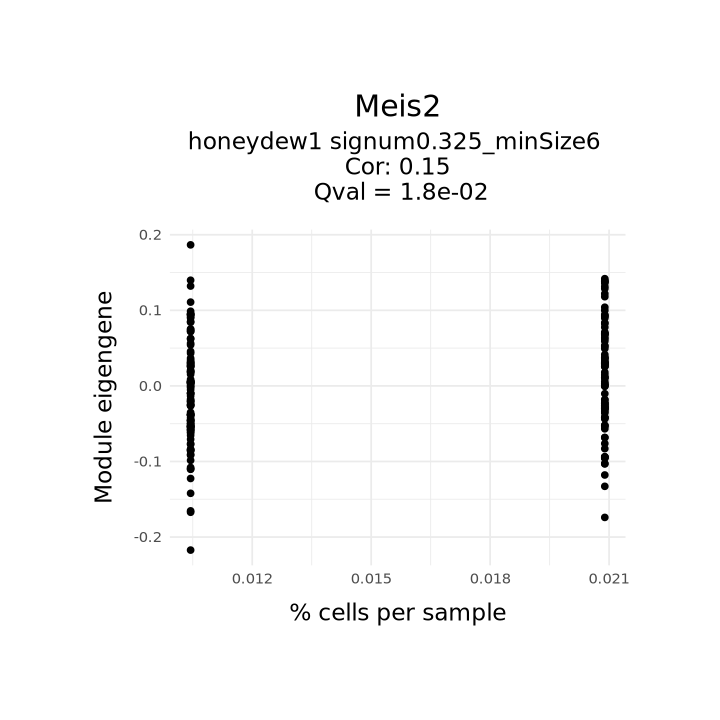

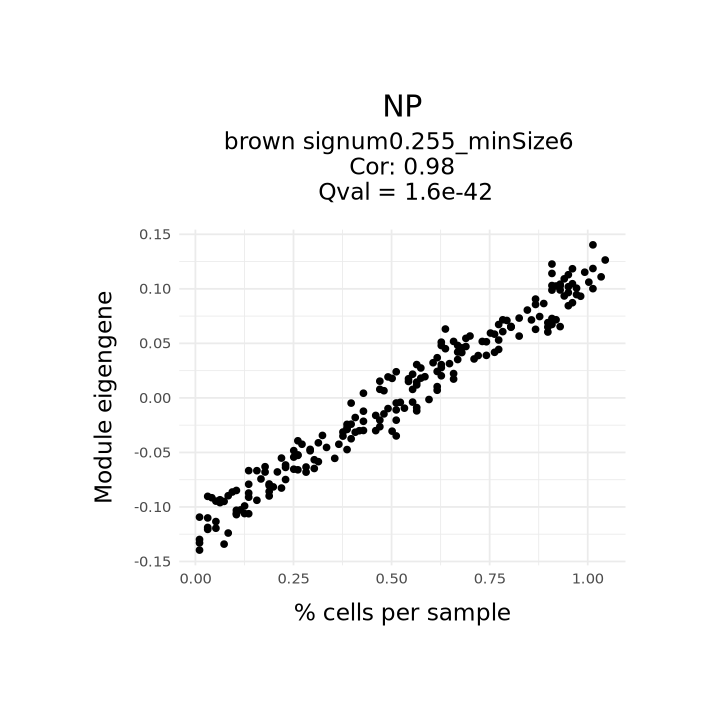

Warning message in cor(frac_per_sample, ME_vec):
“the standard deviation is zero”


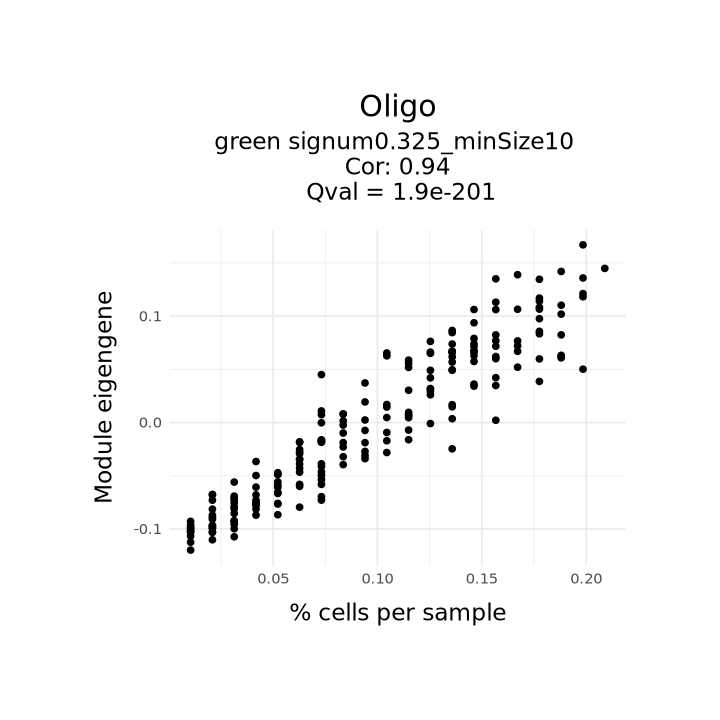

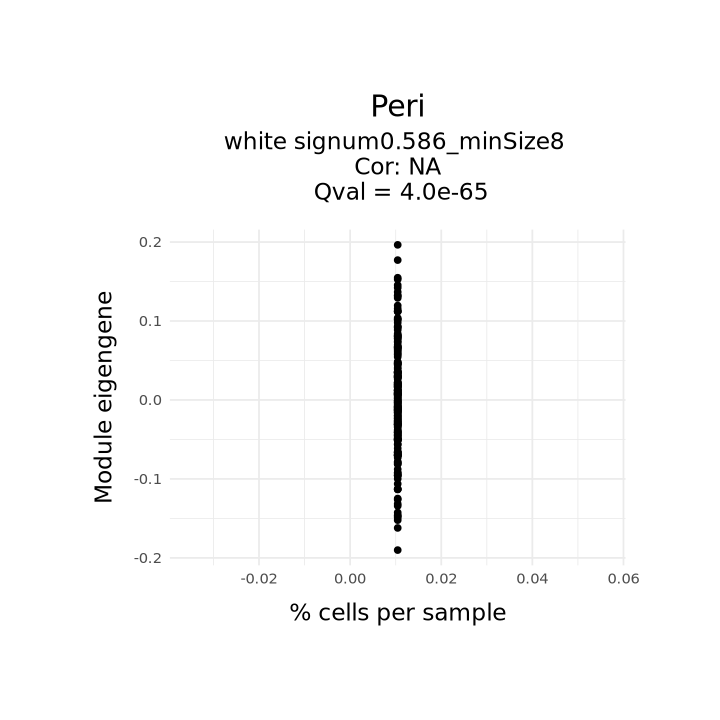

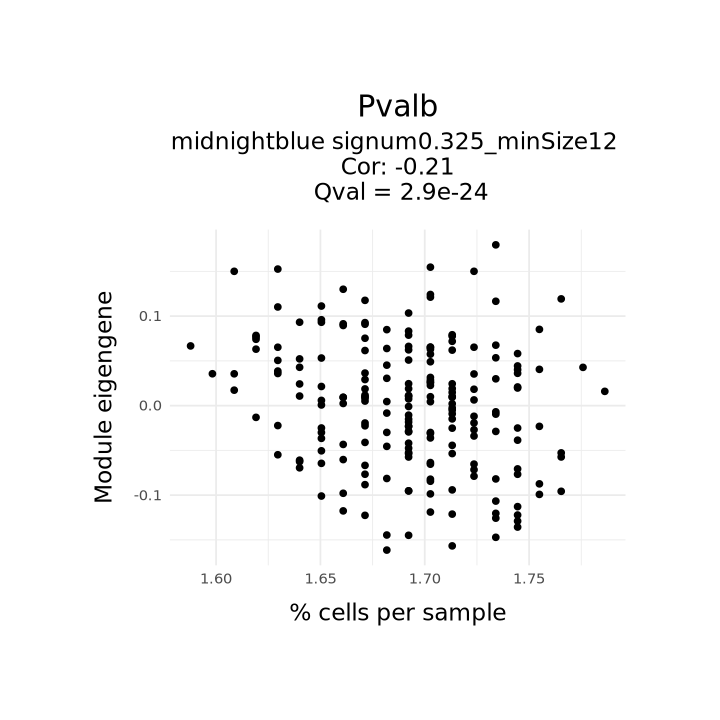

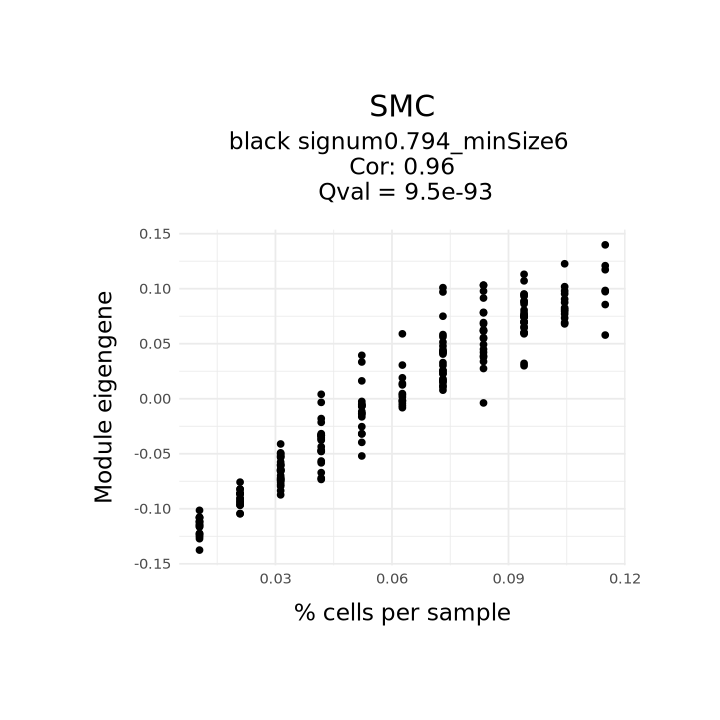

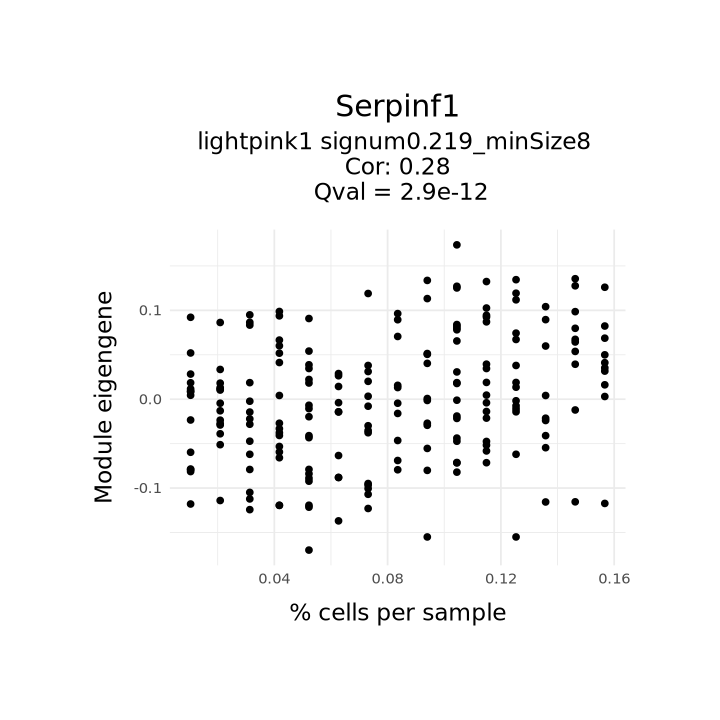

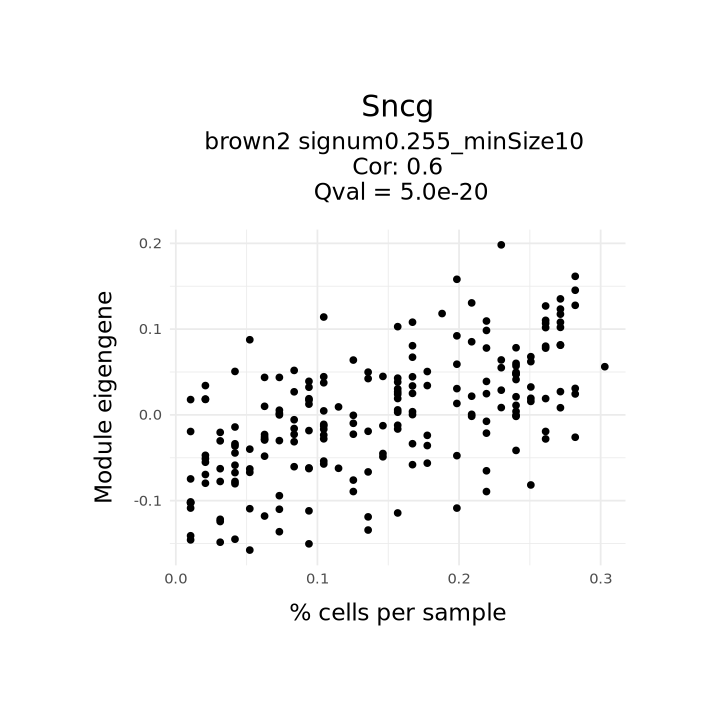

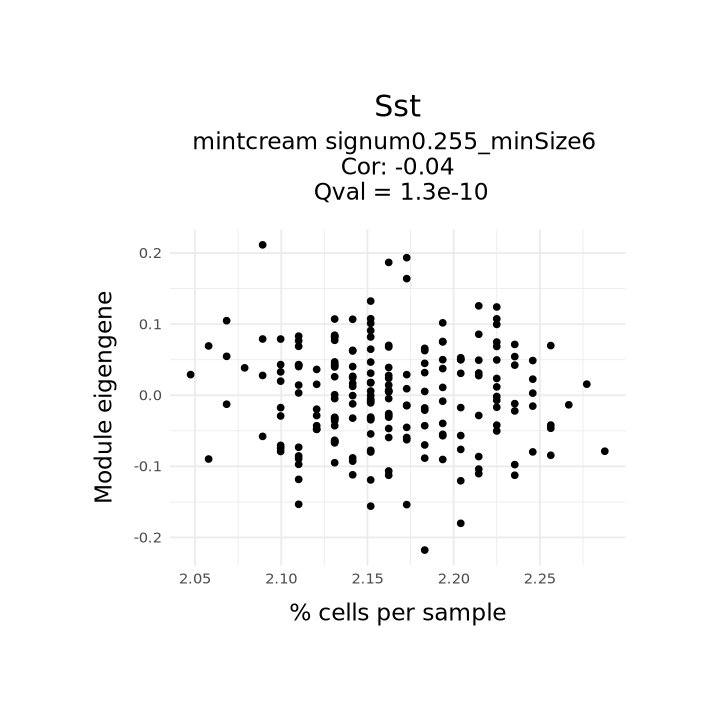

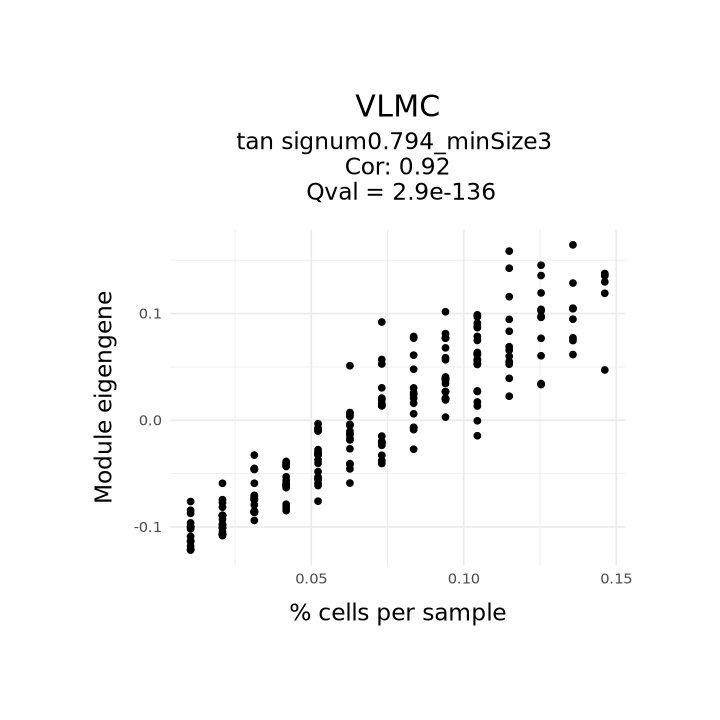

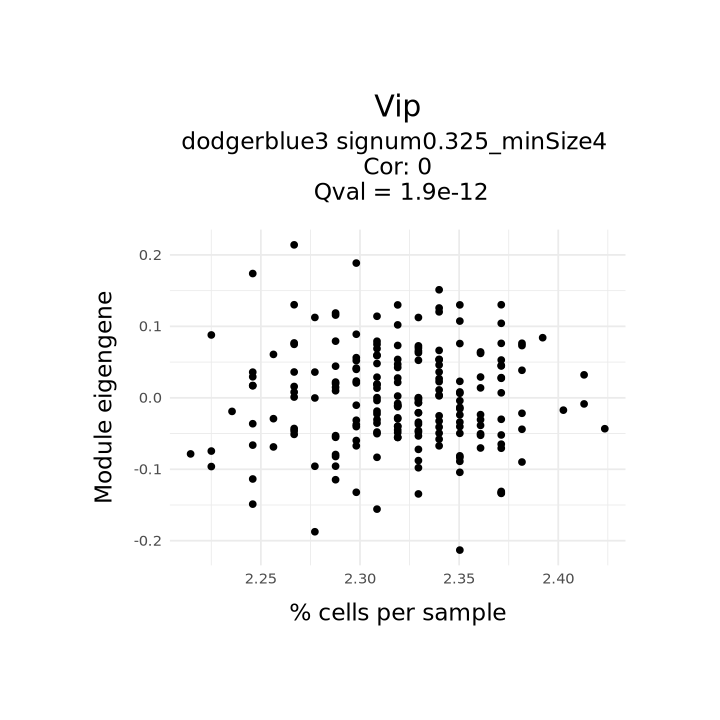

In [12]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [13]:
top_corr_mods_0.4pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_0.4pcnt_PosBC_df

Cell_type  Cor       Old_cor      Module       Old_module    
orange2      Lamp5      0.1939443 -0.022435143 orange2      darkorange    
gray53       Sst        0.2001982 -0.042783507 gray53       mintcream     
gray58       Vip        0.2119883 -0.004228451 gray58       dodgerblue3   
orchid       CR         0.2291747  0.129101599 orchid       mistyrose1    
lightsalmon3 Pvalb      0.2500620 -0.213812093 lightsalmon3 midnightblue  
gray4        Meis2      0.2845981  0.149229893 gray4        honeydew1     
darkkhaki    L5_IT      0.2855019 -0.034604339 darkkhaki    mediumpurple4 
dodgerblue1  Serpinf1   0.7316211  0.276181507 dodgerblue1  lightpink1    
darkorchid2  Sncg       0.8643323  0.598679043 darkorchid2  brown2        
tan1         VLMC       0.9211118  0.921111791 tan          tan           
thistle4     L6b        0.9278851  0.922030212 thistle4     lavenderblush2
green4       Oligo      0.9389186  0.937577729 green        green         
darkred      L6_IT      0.9476400  0.939846037 darkred      yellowgreen   
black1       SMC        0.9590460  0.958120433 black        black         
lightcyan4   L2_3_IT    0.9661427  0.777403570 lightcyan    greenyellow   
green2       Endo       0.9694787  0.963371462 green        blue          
yellow18     Macrophage 0.9739987  0.952347615 yellow       blue          
yellowgreen  L6_CT      0.9763351  0.960360097 yellowgreen  tan           
turquoise19  Astro      0.9832529  0.976700865 turquoise    turquoise     
salmon       L5_PT      0.9853628  0.985362817 salmon       salmon        
brown16      NP         0.9903595  0.981980809 brown        brown         
             Network                                            
orange2      Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151 
gray53       Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 
gray58       Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 
orchid       Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151 
lightsalmon3 Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151 
gray4        Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 
darkkhaki    Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 
dodgerblue1  Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151 
darkorchid2  Bicor-None_signum0.586_minSize3_merge_ME_0.9_20151 
tan1         Bicor-None_signum0.794_minSize3_merge_ME_0.9_20151 
thistle4     Bicor-None_signum0.219_minSize10_merge_ME_0.9_20151
green4       Bicor-None_signum0.255_minSize10_merge_ME_0.9_20151
darkred      Bicor-None_signum0.794_minSize3_merge_ME_0.9_20151 
black1       Bicor-None_signum0.794_minSize3_merge_ME_0.9_20151 
lightcyan4   Bicor-None_signum0.586_minSize10_merge_ME_0.9_20151
green2       Bicor-None_signum0.919_minSize4_merge_ME_0.9_20151 
yellow18     Bicor-None_signum0.919_minSize6_merge_ME_0.9_20151 
yellowgreen  Bicor-None_signum0.219_minSize10_merge_ME_0.9_20151
turquoise19  Bicor-None_signum0.794_minSize10_merge_ME_0.9_20151
salmon       Bicor-None_signum0.325_minSize10_merge_ME_0.9_20151
brown16      Bicor-None_signum0.919_minSize3_merge_ME_0.9_20151 
             Old_network                                         Pseudobulk_SD
orange2      Bicor-None_signum0.586_minSize8_merge_ME_0.9_20151   3.46        
gray53       Bicor-None_signum0.255_minSize6_merge_ME_0.9_20151   4.61        
gray58       Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151   3.84        
orchid       Bicor-None_signum0.219_minSize6_merge_ME_0.9_20151   0.50        
lightsalmon3 Bicor-None_signum0.325_minSize12_merge_ME_0.9_20151  3.74        
gray4        Bicor-None_signum0.325_minSize6_merge_ME_0.9_20151   0.50        
darkkhaki    Bicor-None_signum0.325_minSize8_merge_ME_0.9_20151   5.73        
dodgerblue1  Bicor-None_signum0.219_minSize8_merge_ME_0.9_20151   4.20        
darkorchid2  Bicor-None_signum0.255_minSize10_merge_ME_0.9_20151  8.13        
tan1         Bicor-None_signum0.794_minSize3_merge_ME_0.9_20151   3.63        
thistle4     Bicor-None_signum0.325_minSize4_merge_ME_0.9_20151 

# Round 4 (50% var network; PosBC module definition)

In [14]:
network_dir <- "tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_30pcntCells_50pcntVar_200samples_legend_05-16-36.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_30pcntCells_50pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [15]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [16]:
top_corr_mods_50pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_50pcnt_PosBC_df

Cell_type  Cor       Old_cor     Module          Old_module   
pink1           Sncg       0.1320302  0.08311361 pink1           lightcyan    
skyblue2        CR         0.1490367 -0.04376170 skyblue2        peru         
orange1         Meis2      0.1785107 -0.08011696 orange1         antiquewhite4
palevioletred4  Peri       0.1873673 -0.16100388 palevioletred4  blue         
lightgoldenrod4 Serpinf1   0.1938398  0.07748015 lightgoldenrod4 salmon       
mintcream       L4         0.2015220  0.07698462 mintcream       lightpink3   
mistyrose1      L6_IT      0.7960936  0.69452226 mistyrose1      darkorange2  
darkolivegreen  VLMC       0.8453615  0.83210083 darkolivegreen  orange       
darkorange      Oligo      0.8554086  0.82541326 darkorange      darkturquoise
yellow          Macrophage 0.8790042  0.87358583 yellow          magenta      
yellow1         Macrophage 0.8790042  0.87409913 yellow          purple       
brown           SMC        0.8828202  0.87072285 brown           royalblue    
firebrick4      L2_3_IT    0.8873879  0.63916993 firebrick4      salmon2      
yellow19        Astro      0.8945385  0.88709521 yellow          yellow       
pink2           Endo       0.9001138  0.89385788 pink            pink         
pink4           L6_CT      0.9035261  0.83224451 pink4           thistle2     
darkgrey1       Vip        0.9058163  0.87250655 darkgrey        green        
greenyellow1    Sst        0.9083775  0.90084316 greenyellow     green        
bisque4         L5_PT      0.9086067  0.89459633 bisque4         salmon4      
darkred1        Pvalb      0.9241352  0.76534598 darkred         brown        
darkgrey        Lamp5      0.9250482  0.86207782 darkgrey        red          
midnightblue4   NP         0.9274852  0.90239443 midnightblue    cyan         
turquoise28     L5_IT      0.9284386  0.90622033 turquoise       turquoise    
                Network                                            
pink1           Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151  
skyblue2        Bicor-None_signum0.629_minSize4_merge_ME_0.9_20151 
orange1         Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151 
palevioletred4  Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151  
lightgoldenrod4 Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151  
mintcream       Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151 
mistyrose1      Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151 
darkolivegreen  Bicor-None_signum0.629_minSize10_merge_ME_0.9_20151
darkorange      Bicor-None_signum0.842_minSize3_merge_ME_0.9_20151 
yellow          Bicor-None_signum0.968_minSize3_merge_ME_0.9_20151 
yellow1         Bicor-None_signum0.968_minSize3_merge_ME_0.9_20151 
brown           Bicor-None_signum0.968_minSize3_merge_ME_0.9_20151 
firebrick4      Bicor-None_signum0.465_minSize10_merge_ME_0.9_20151
yellow19        Bicor-None_signum0.928_minSize3_merge_ME_0.9_20151 
pink2           Bicor-None_signum0.842_minSize3_merge_ME_0.9_20151 
pink4           Bicor-None_signum0.465_minSize10_merge_ME_0.9_20151
darkgrey1       Bicor-None_signum0.629_minSize10_merge_ME_0.9_20151
greenyellow1    Bicor-None_signum0.842_minSize10_merge_ME_0.9_20151
bisque4         Bicor-None_signum0.465_minSize10_merge_ME_0.9_20151
darkred1        Bicor-None_signum0.629_minSize4_merge_ME_0.9_20151 
darkgrey        Bicor-None_signum0.842_minSize3_merge_ME_0.9_20151 
midnightblue4   Bicor-None_signum0.842_minSize4_merge_ME_0.9_20151 
turquoise28     Bicor-None_signum0.968_minSize5_merge_ME_0.9_20151 
                Old_network                                        
pink1           Bicor-None_signum0.629_minSize6_merge_ME_0.9_20151 
skyblue2        Bicor-None_signum0.53_minSize4_merge_ME_0.9_20151  
orange1         Bicor-None_signum0.629_minSize8_merge_ME_0.9_20151 
palevioletred4  Bicor-None_signum0.968_minSize3_merge_ME_0.9_20151 
lightgoldenrod4 Bicor-None_signum0.465_minSize5_merge_ME_0.9_20151 
mintcream       Bicor-None_signum0.465_minSize10_merge_ME_0.9_20151
mistyrose1  

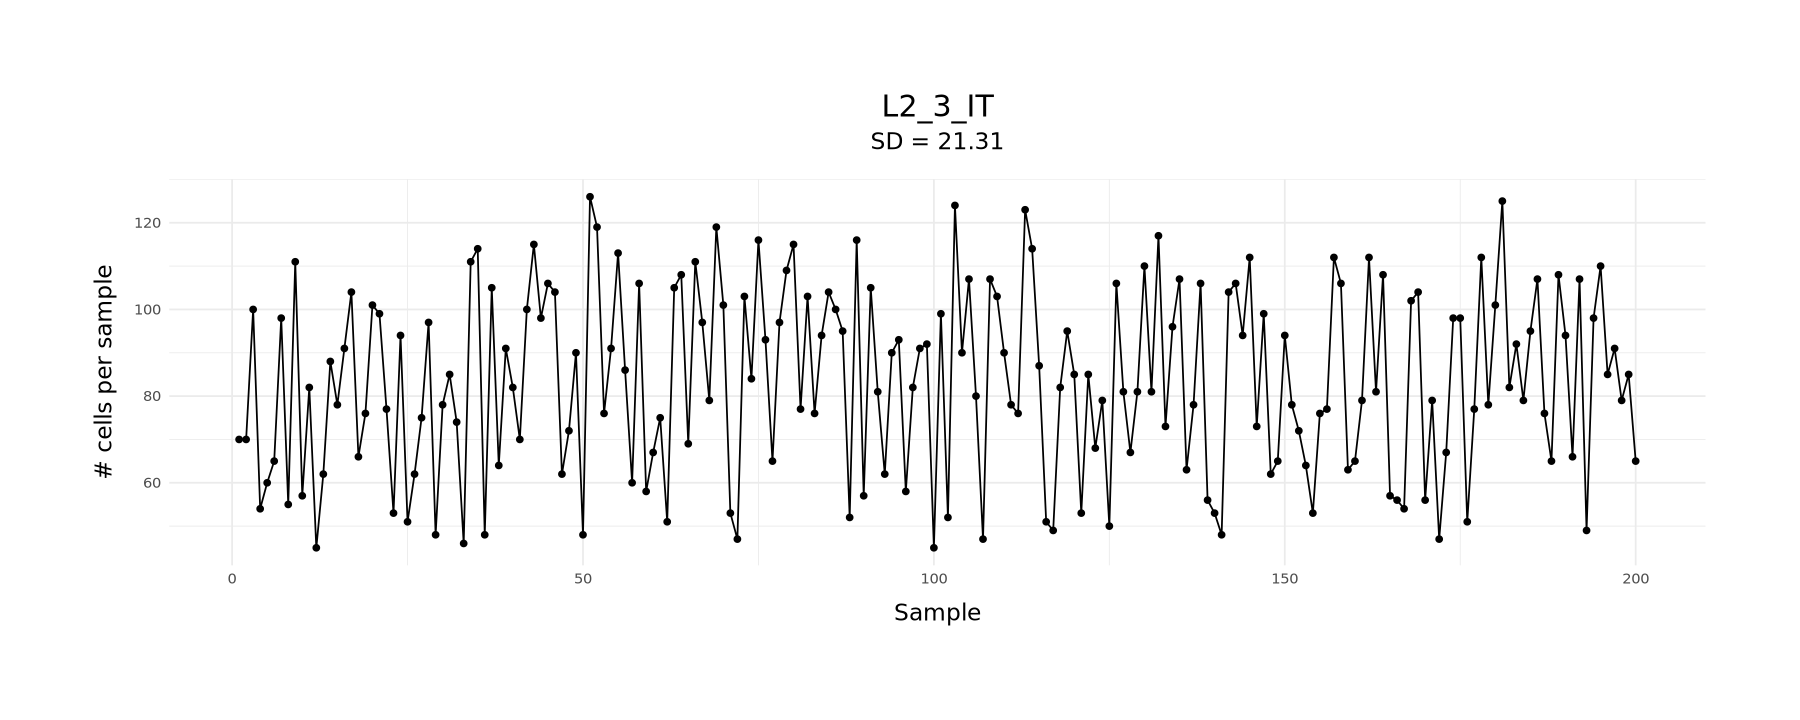

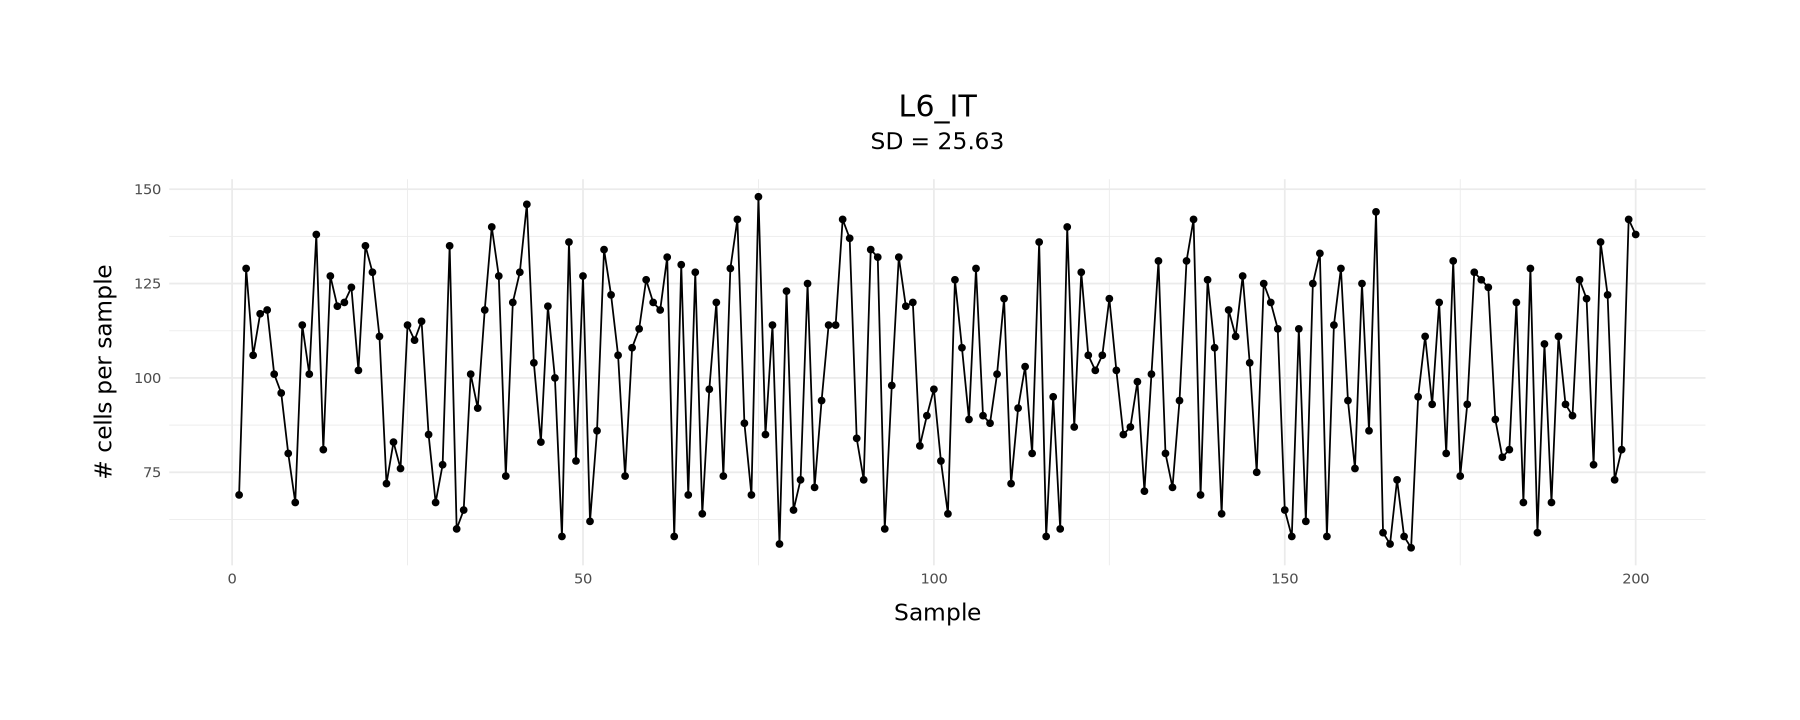

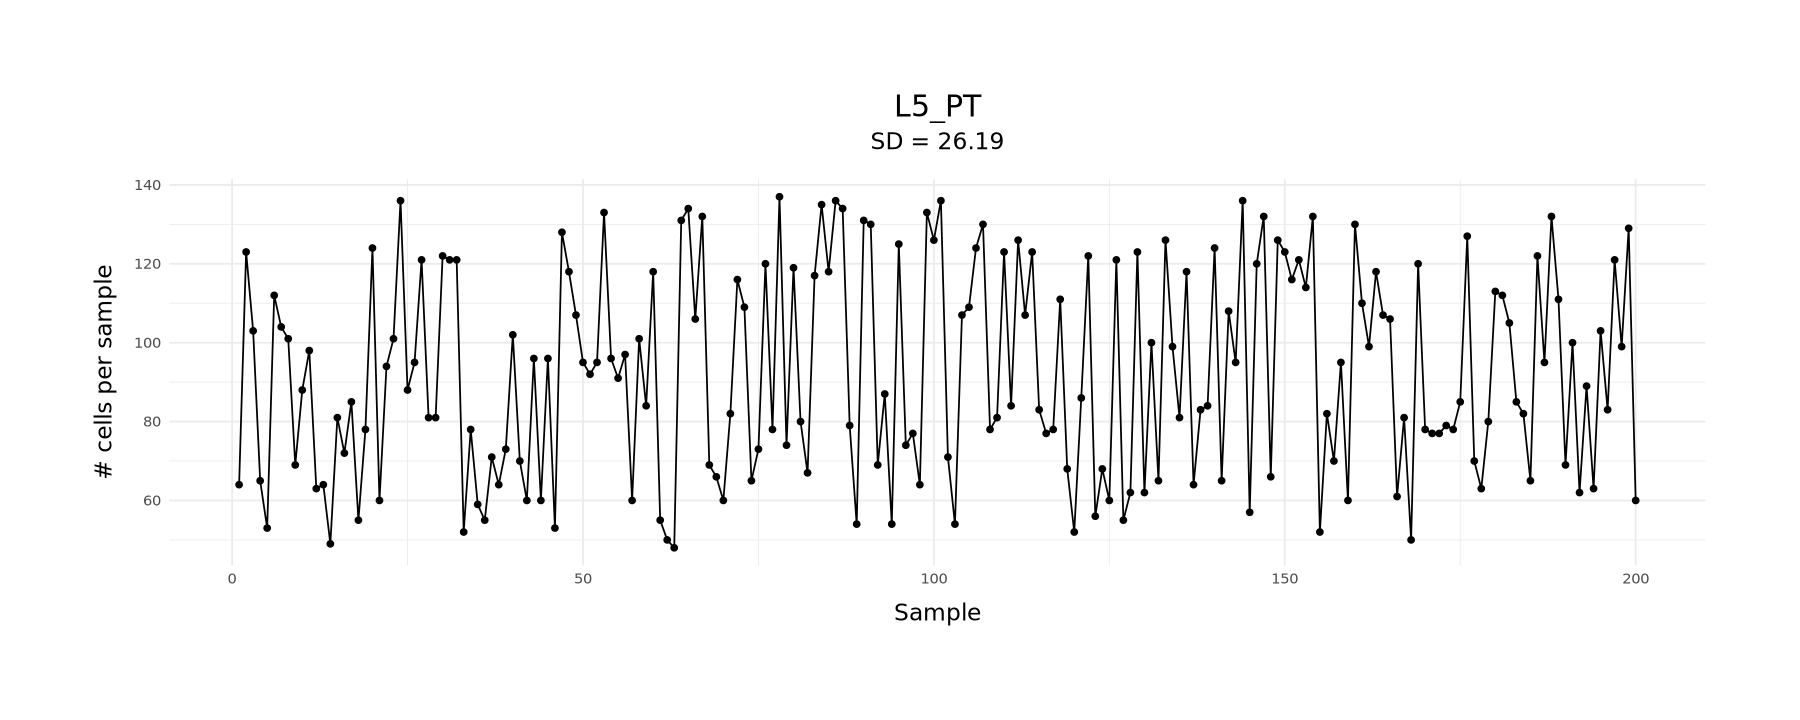

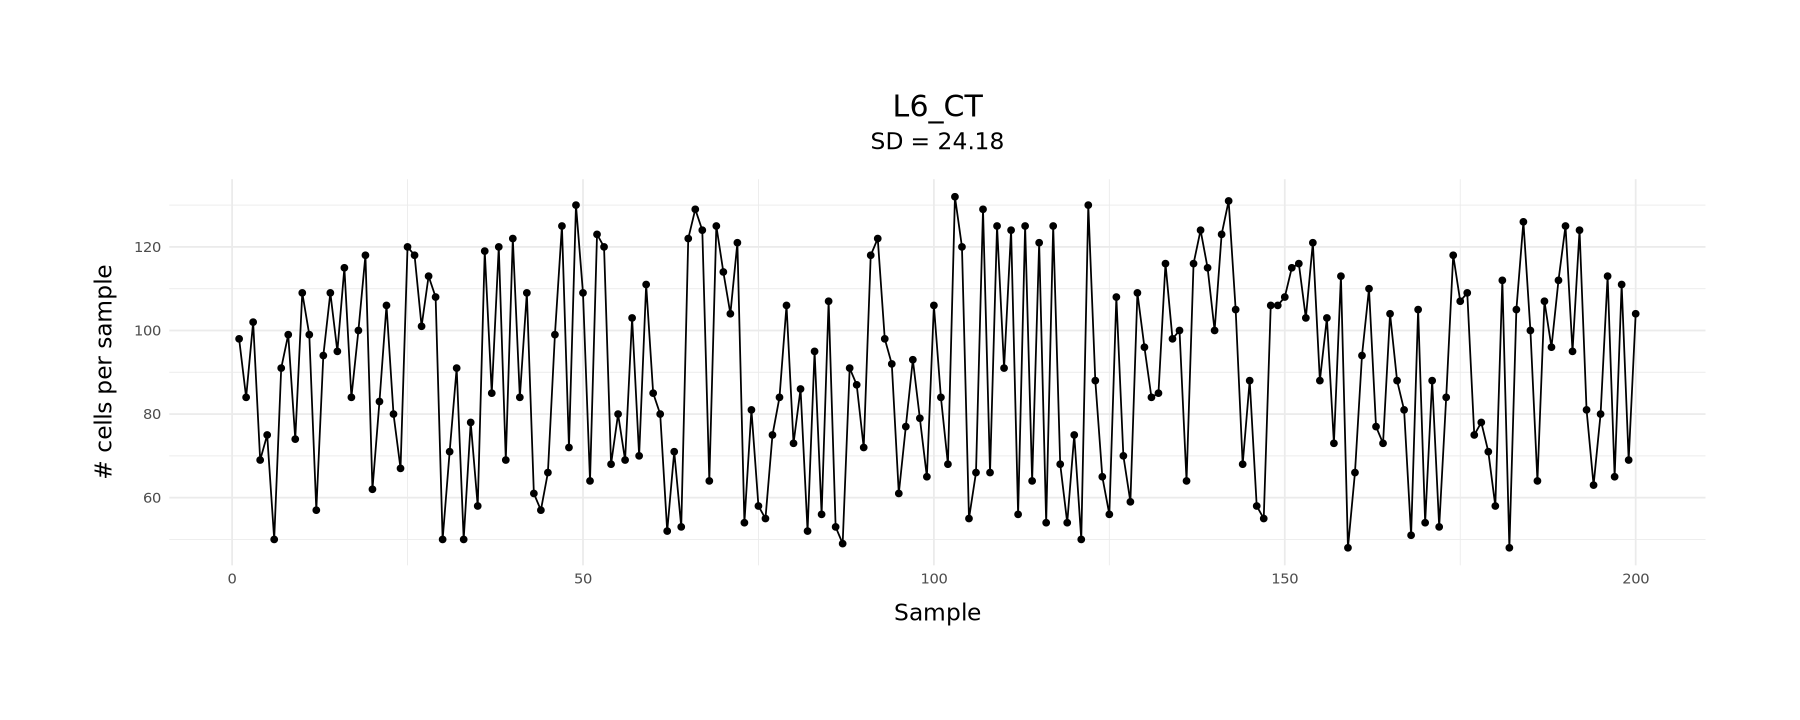

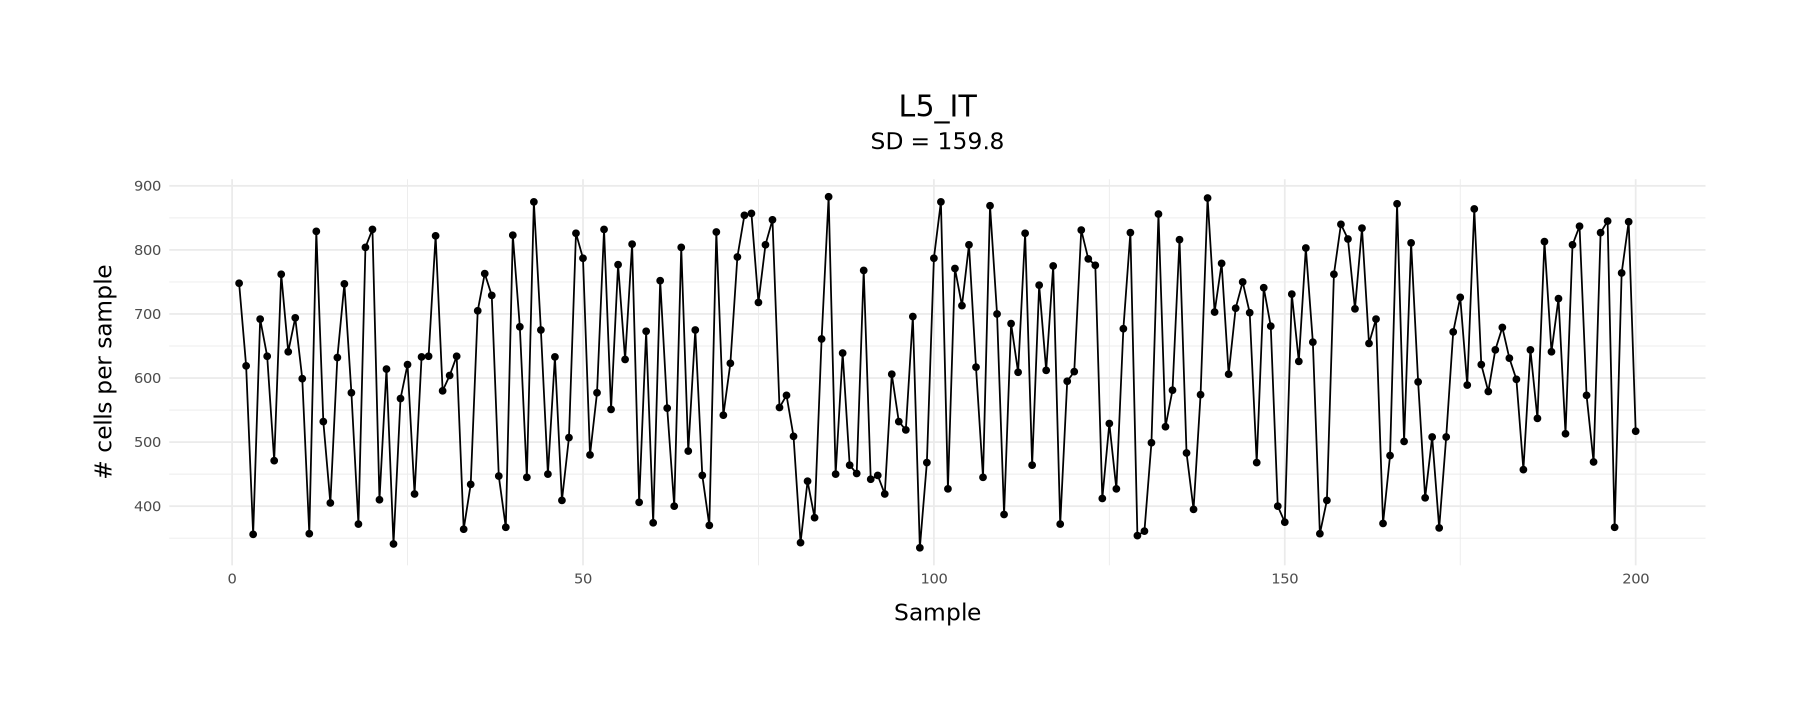

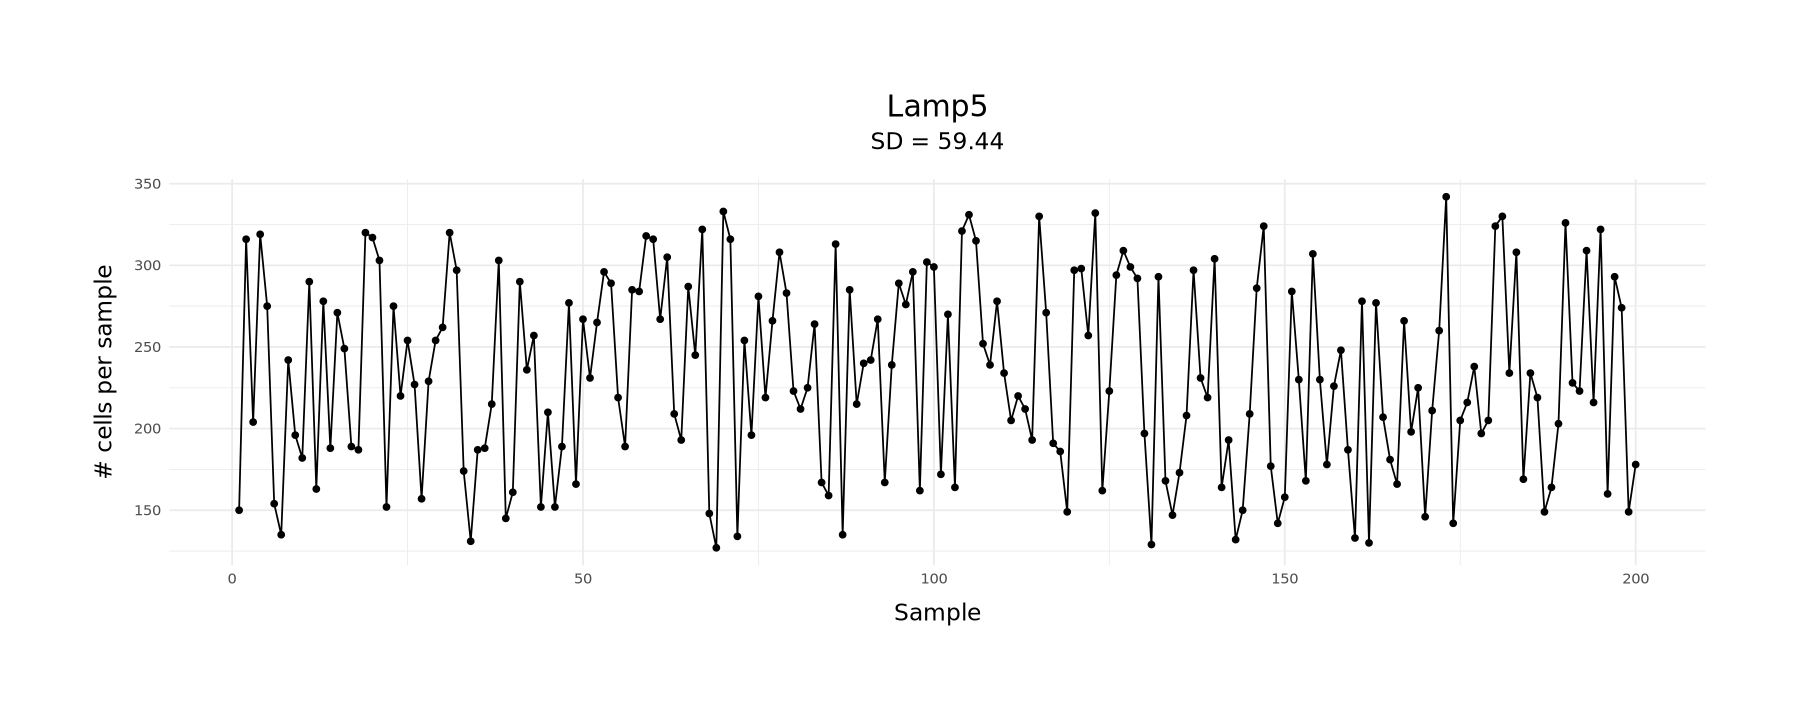

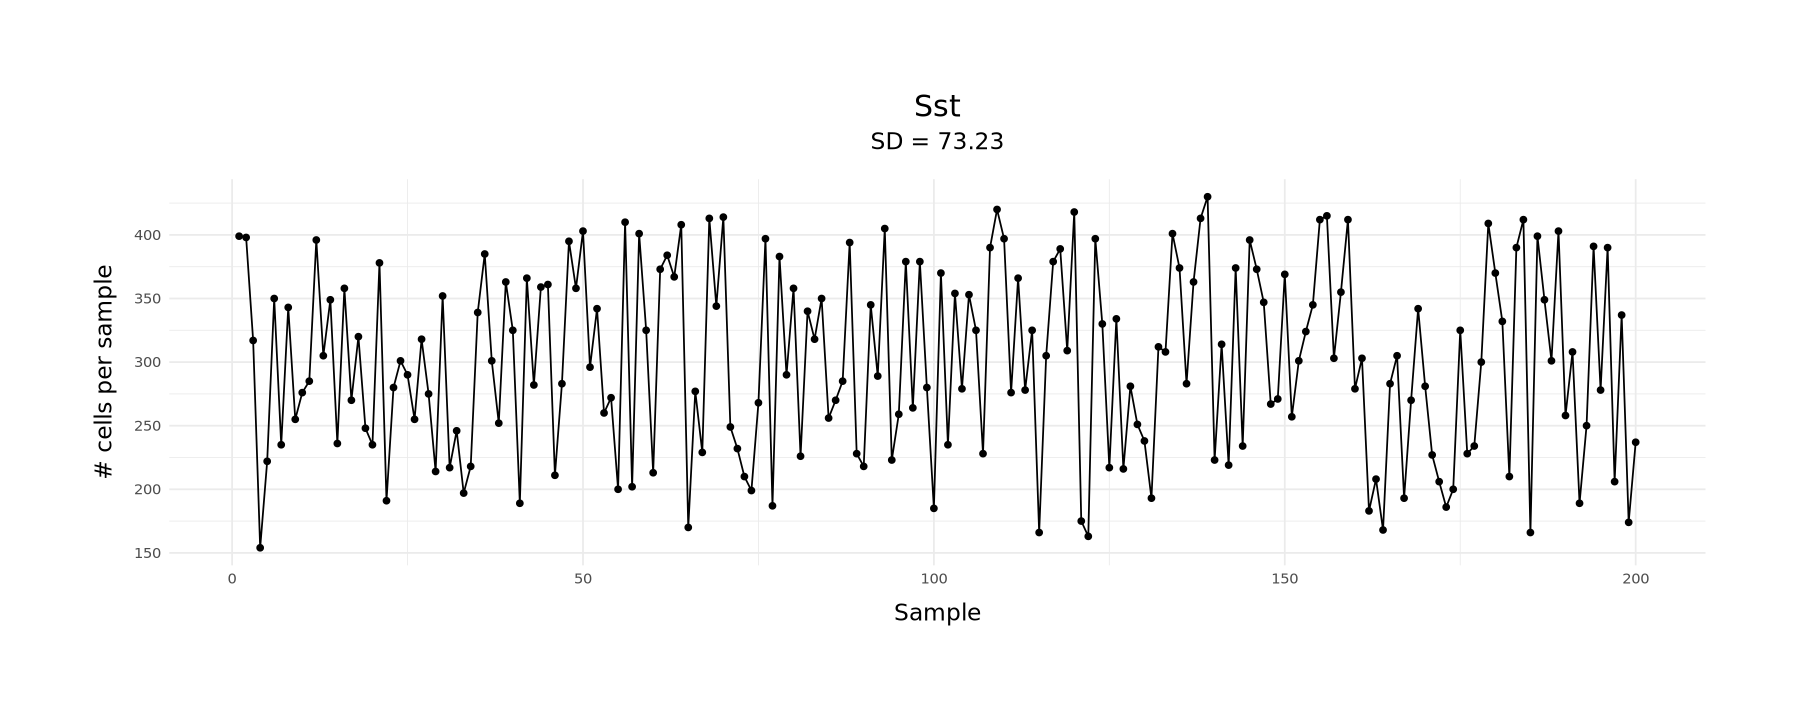

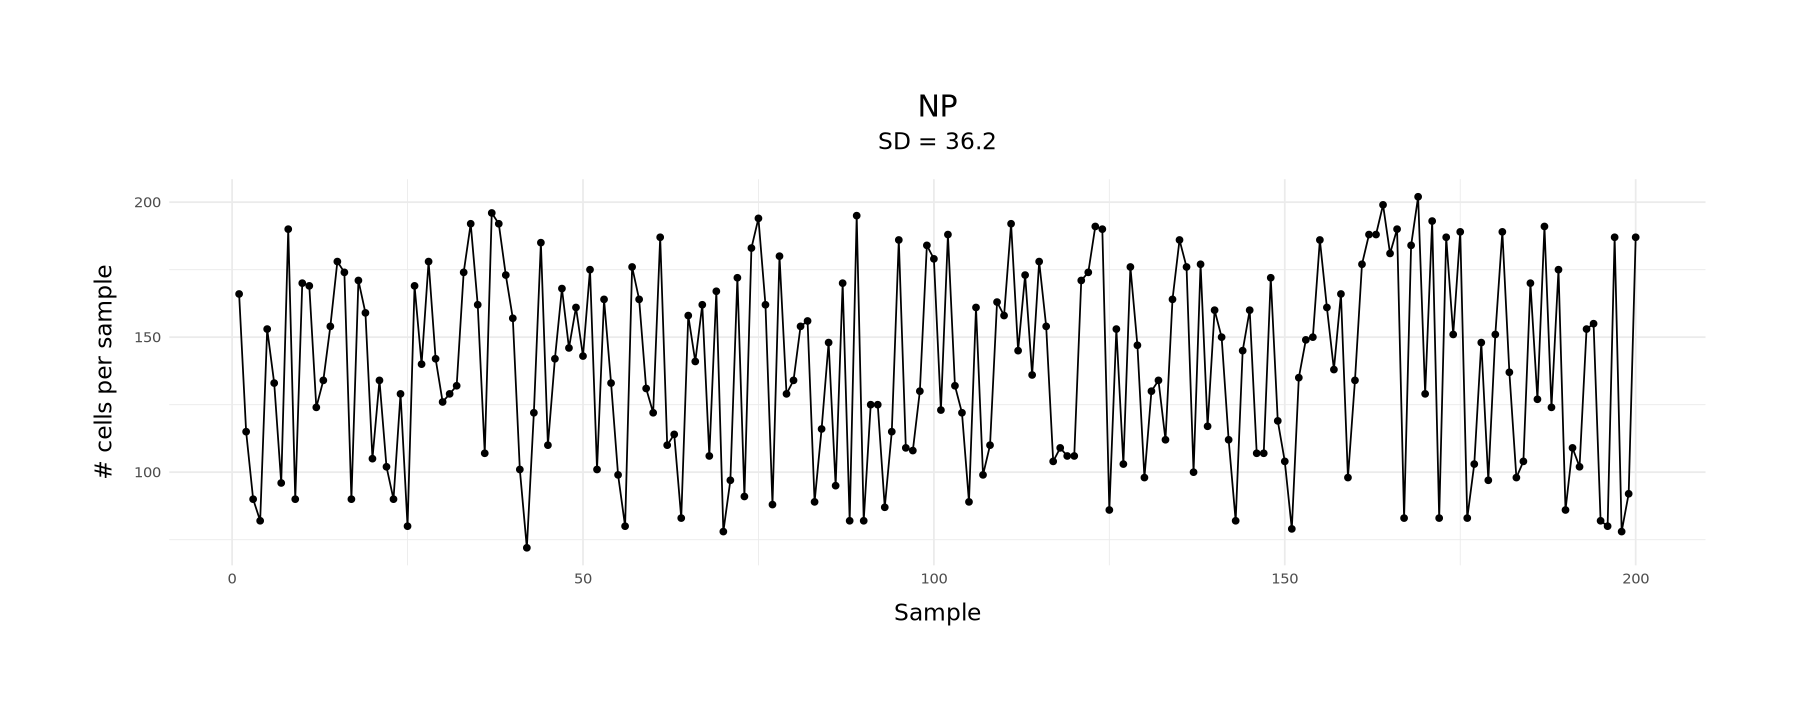

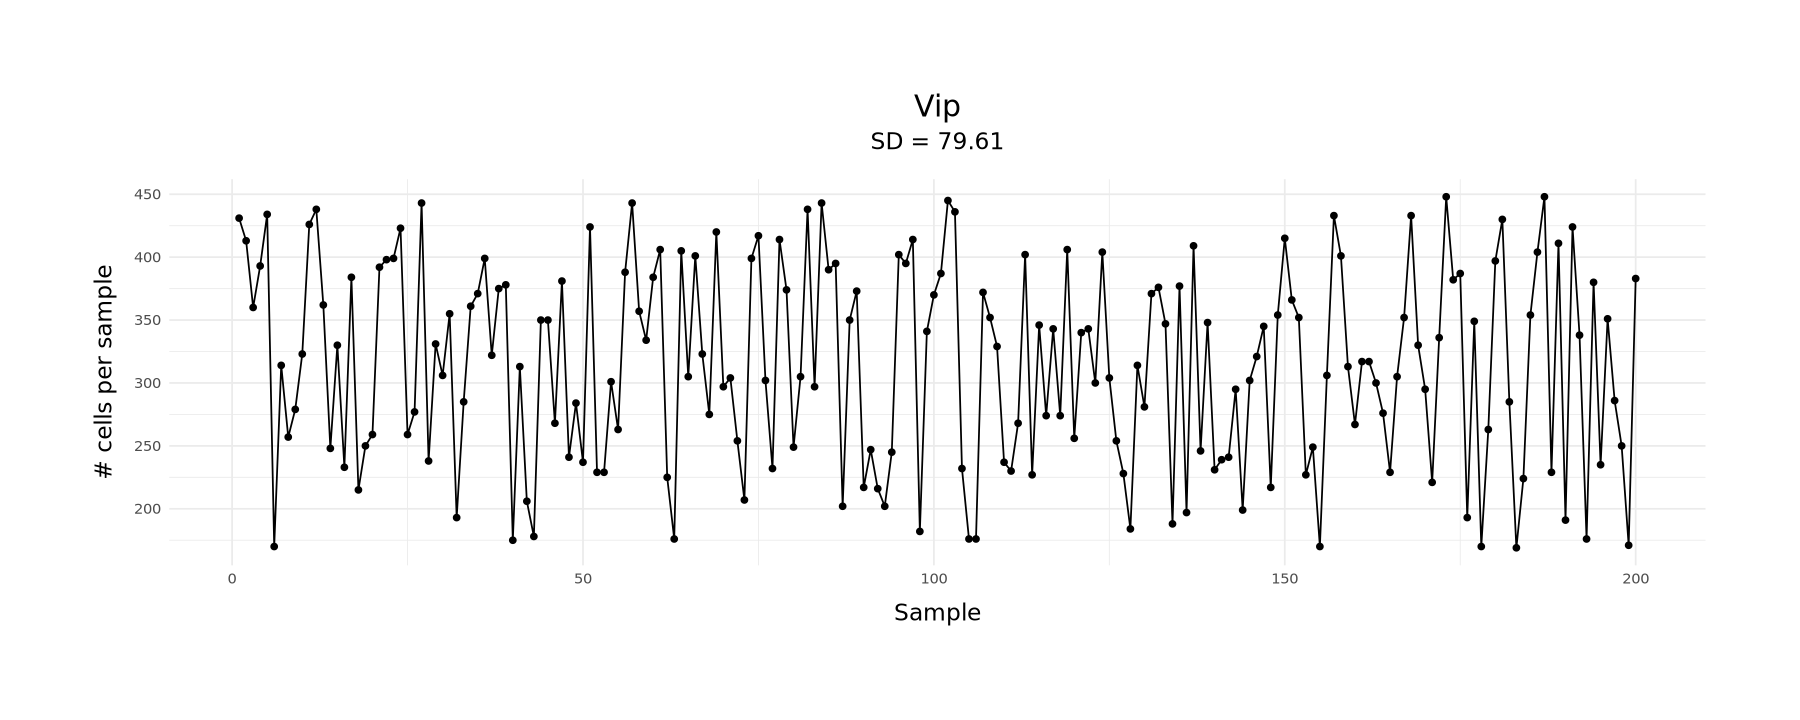

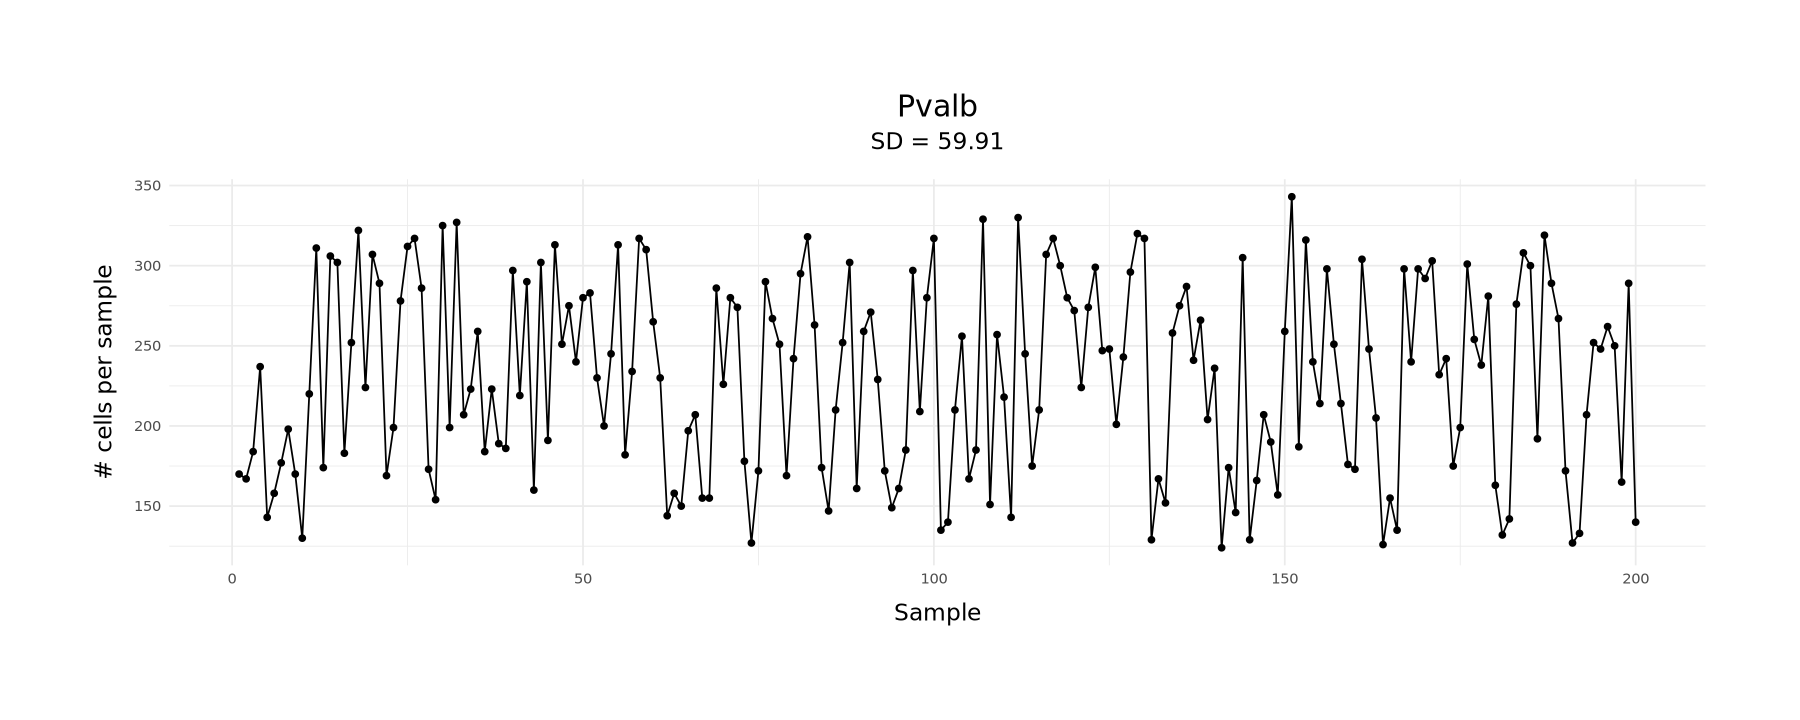

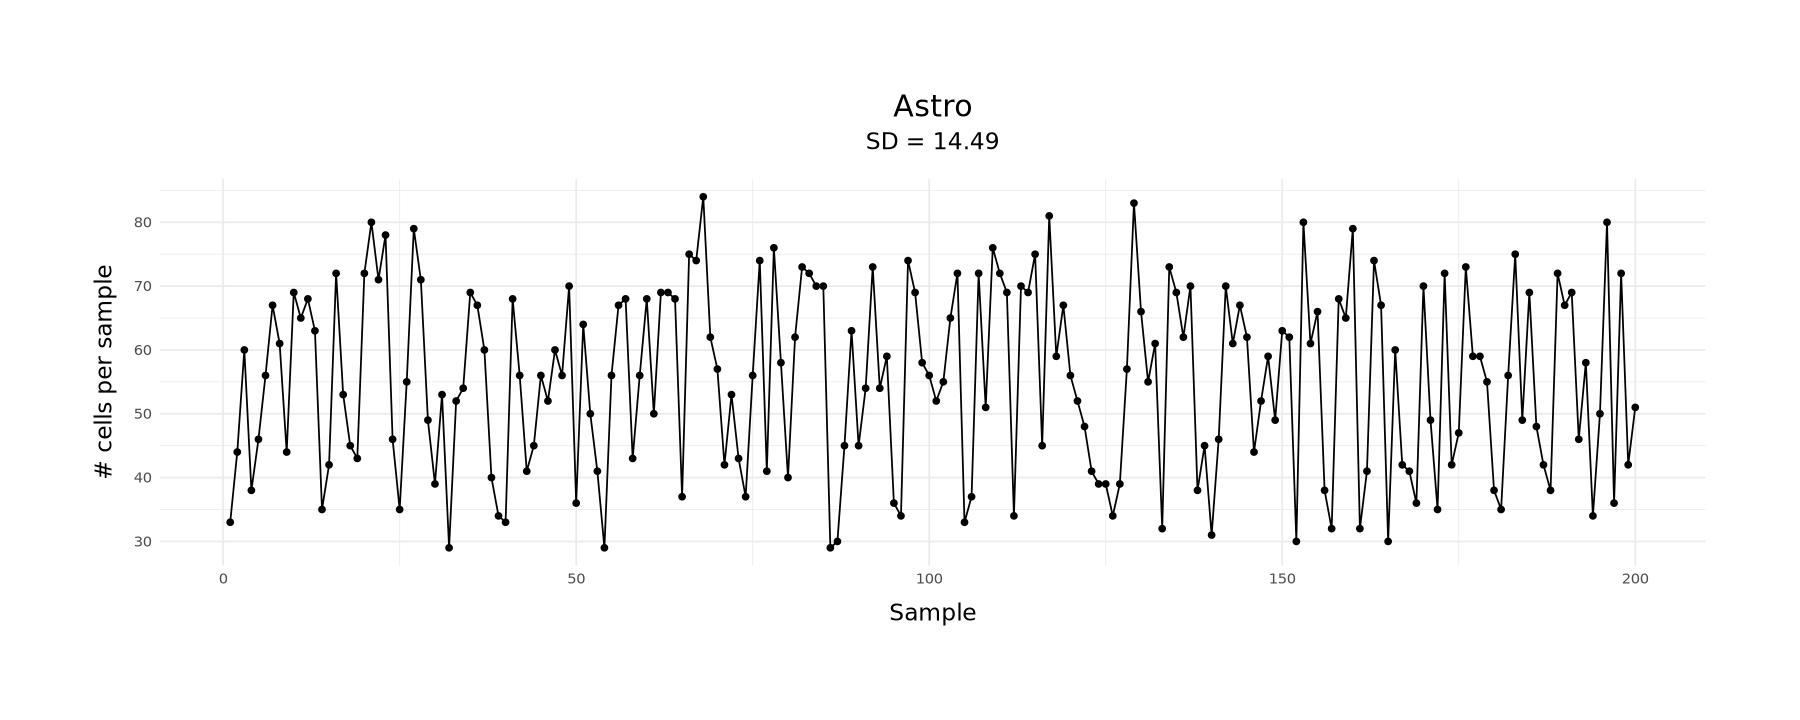

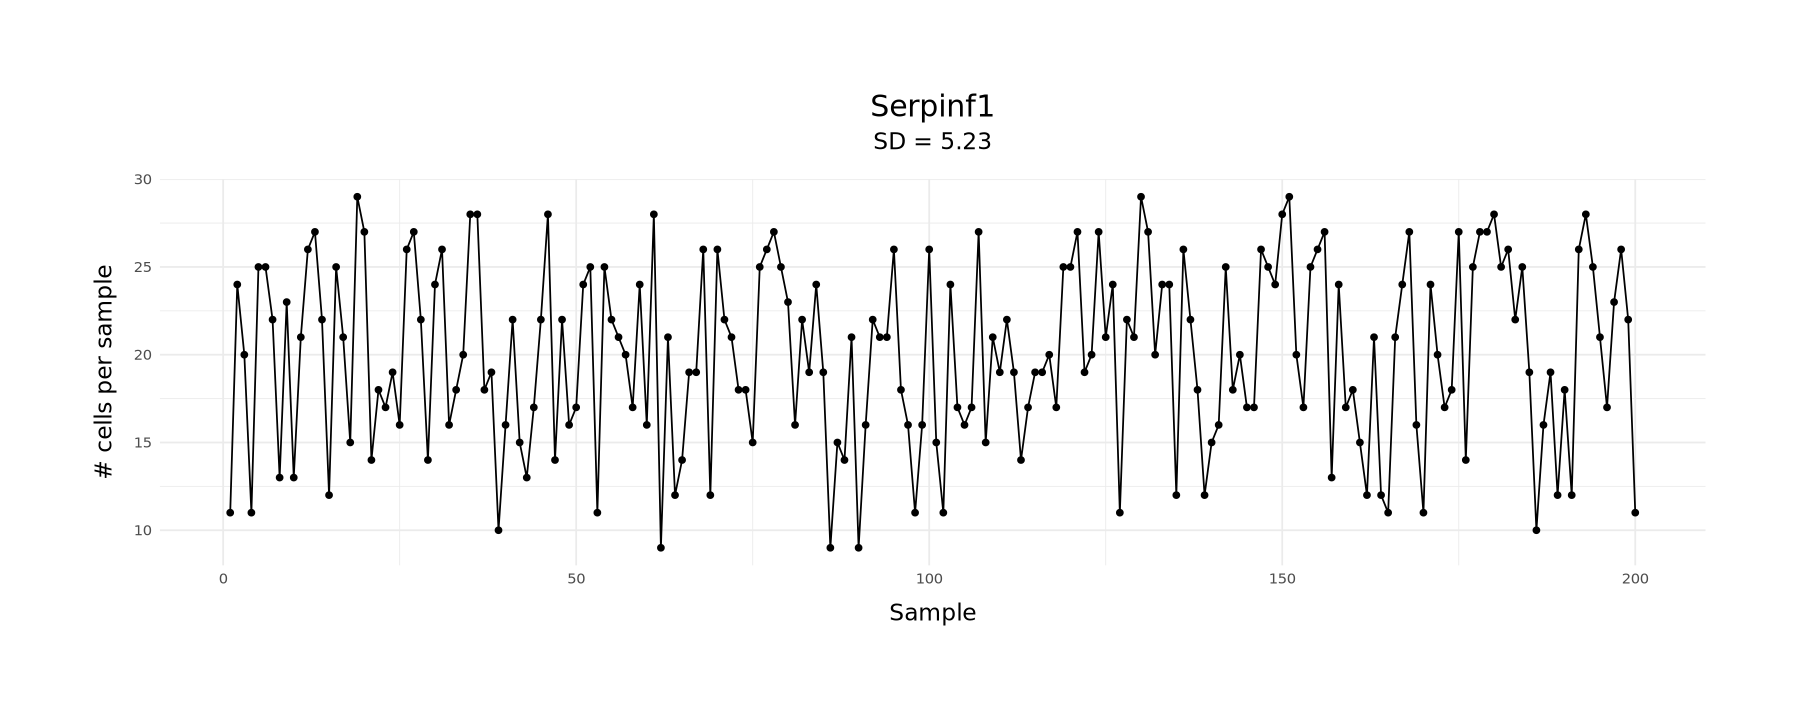

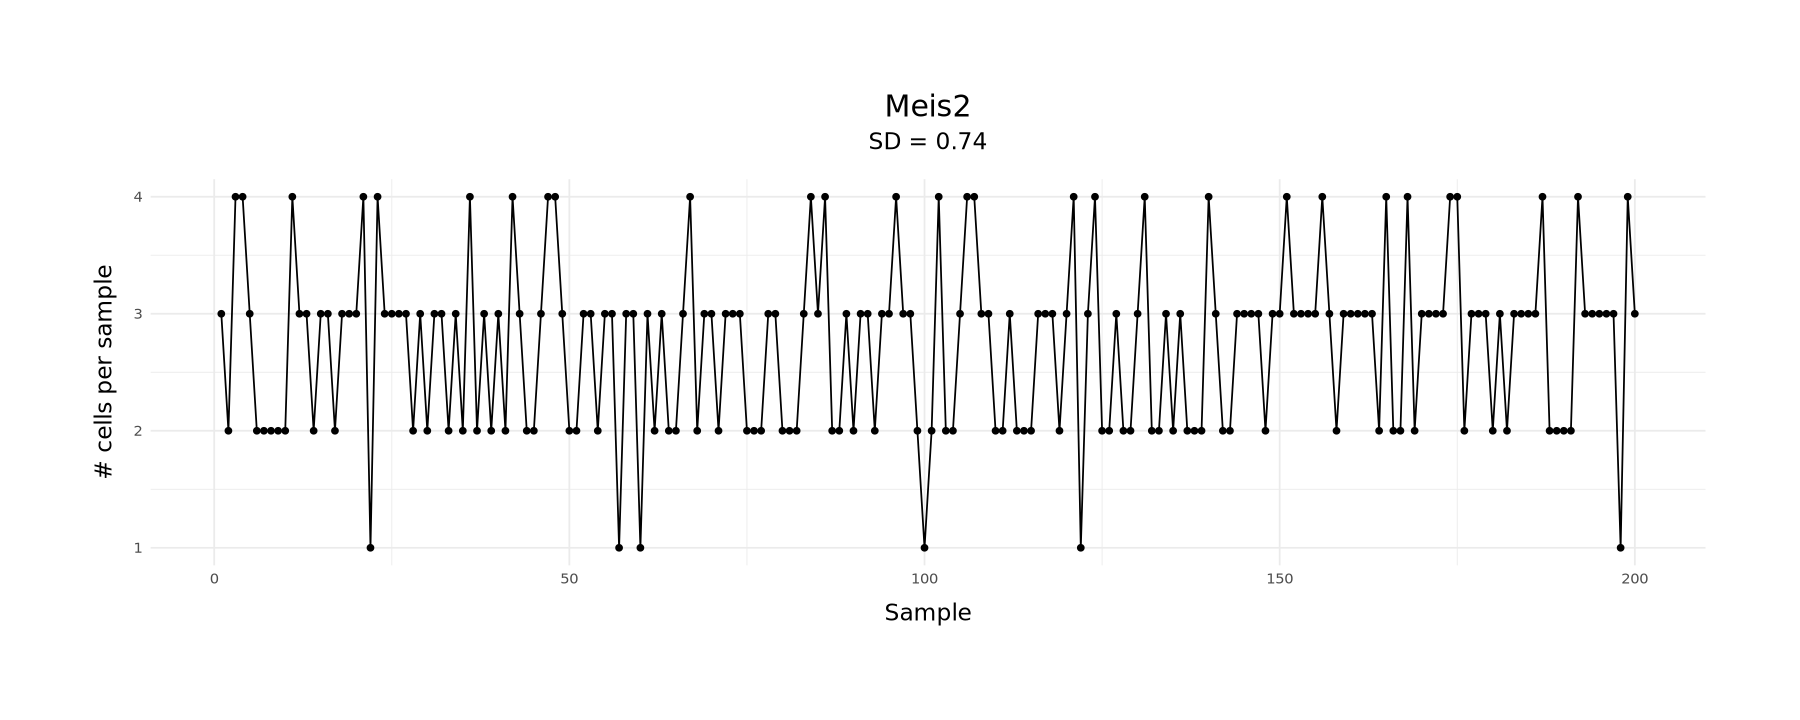

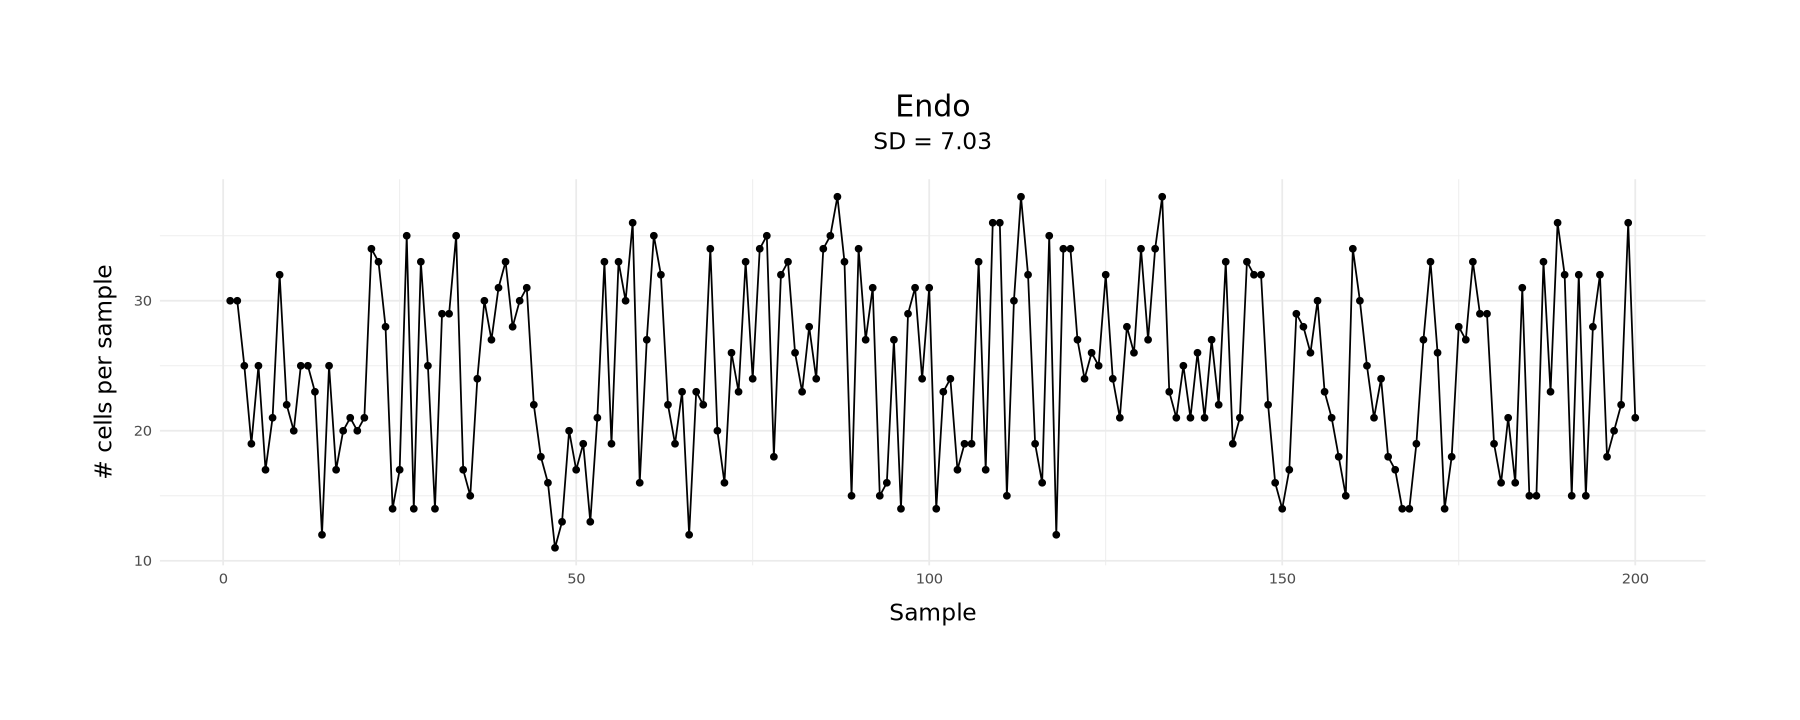

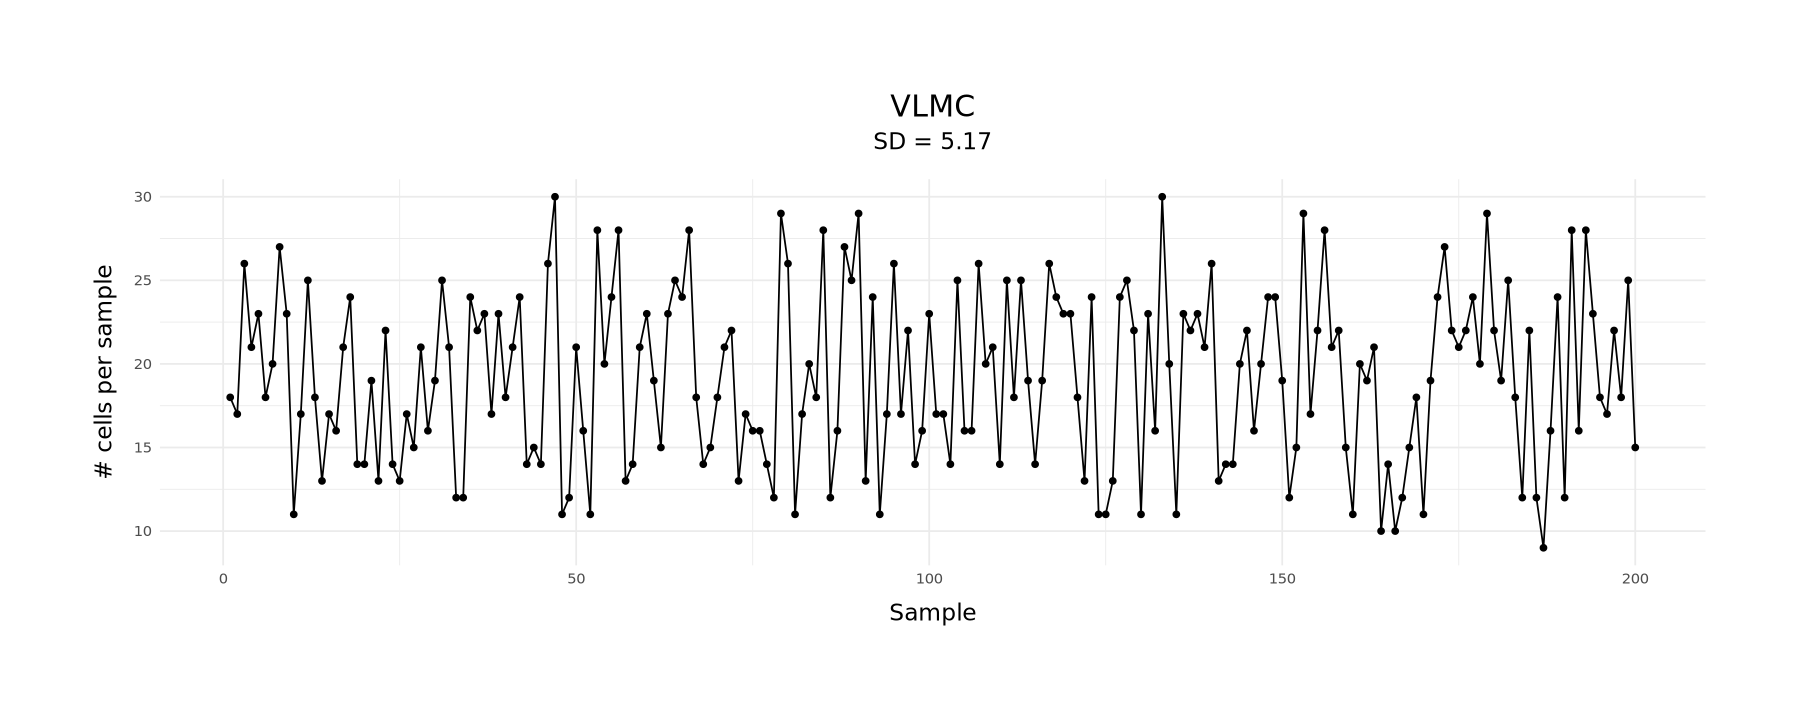

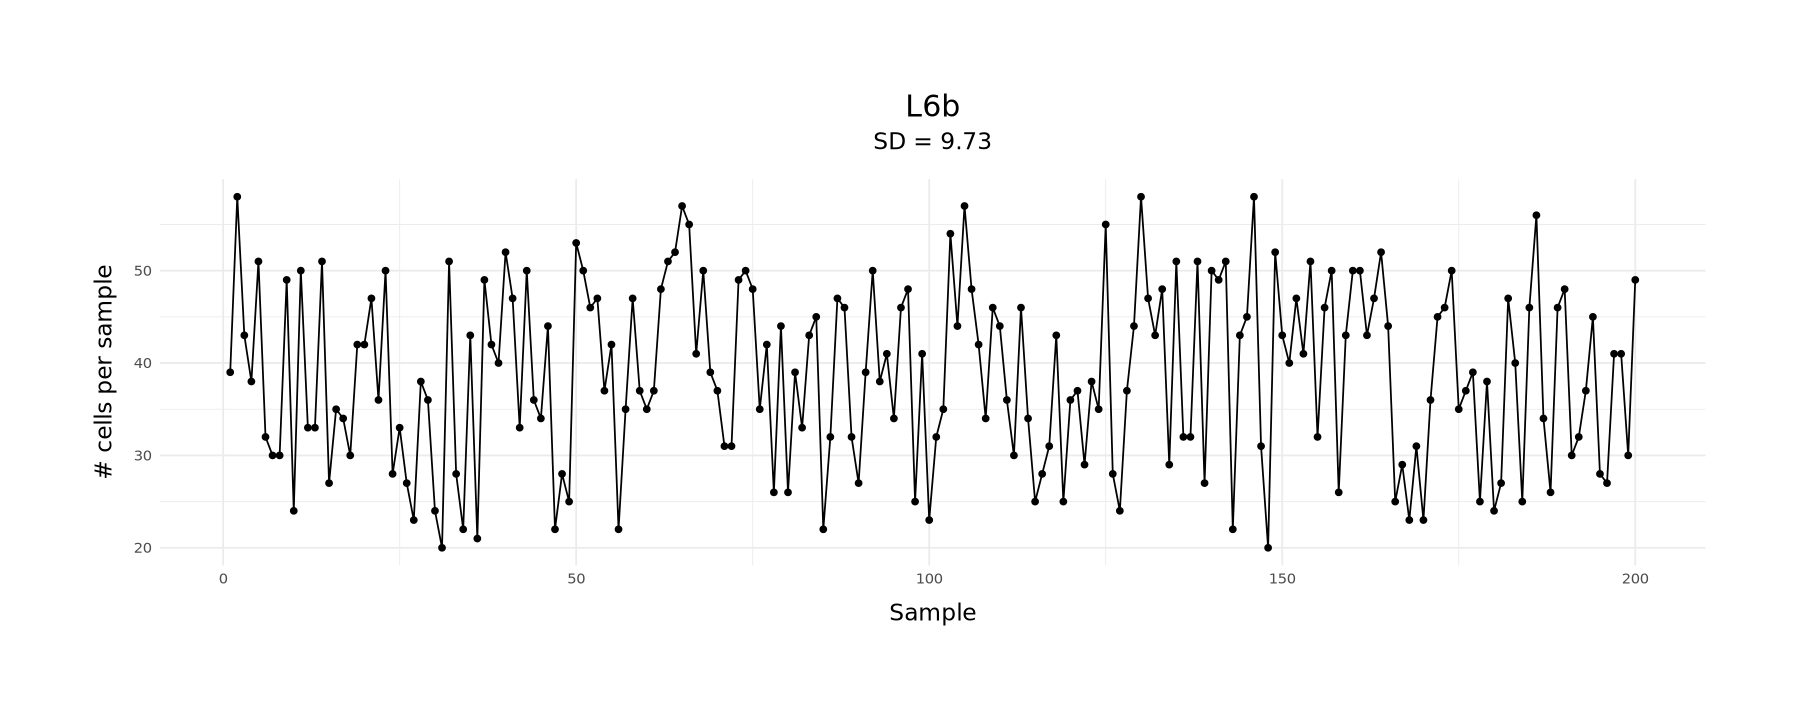

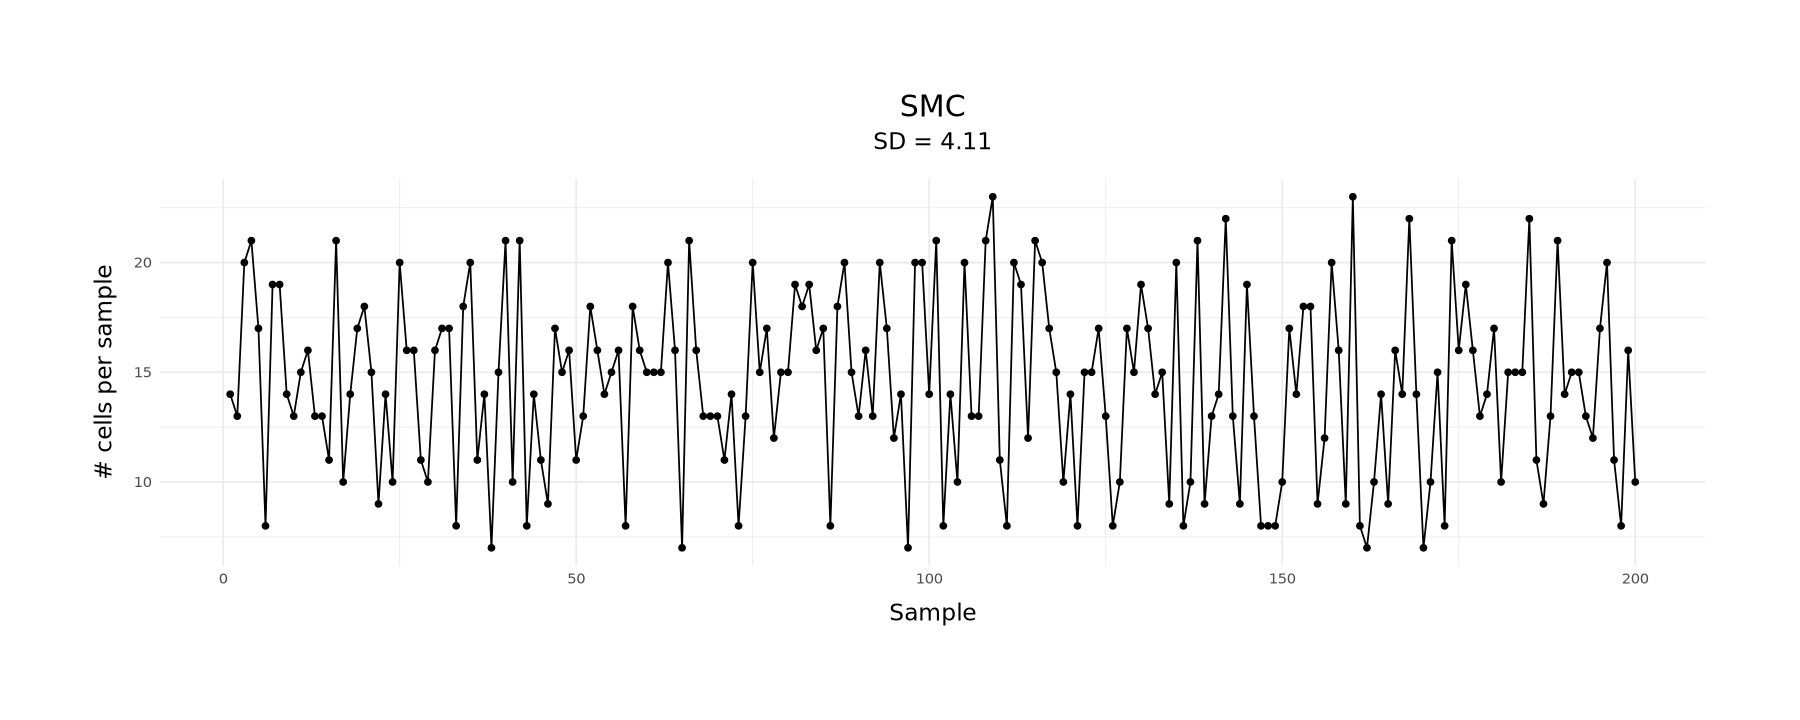

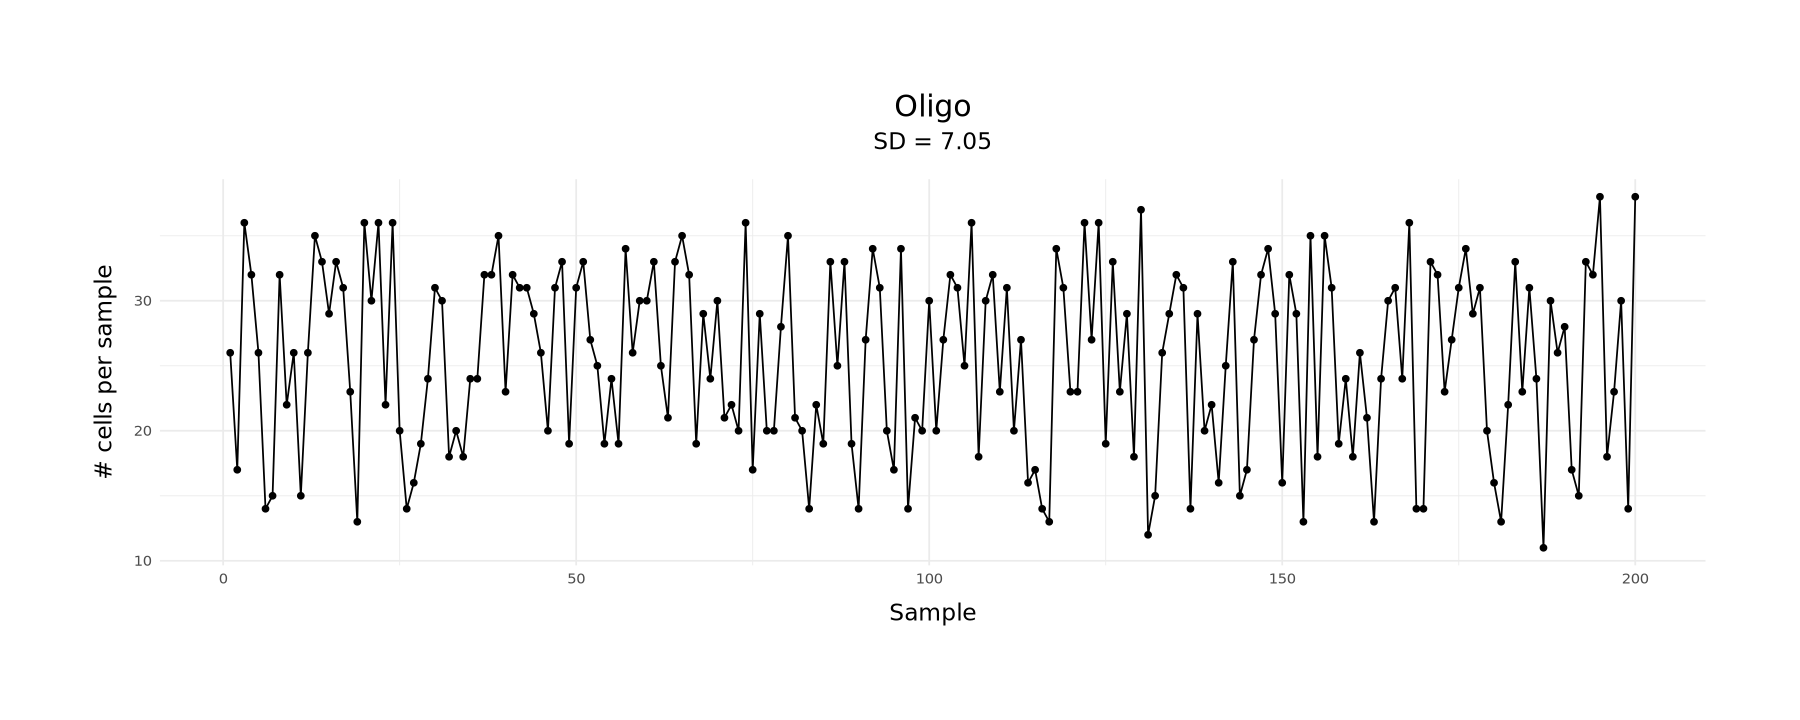

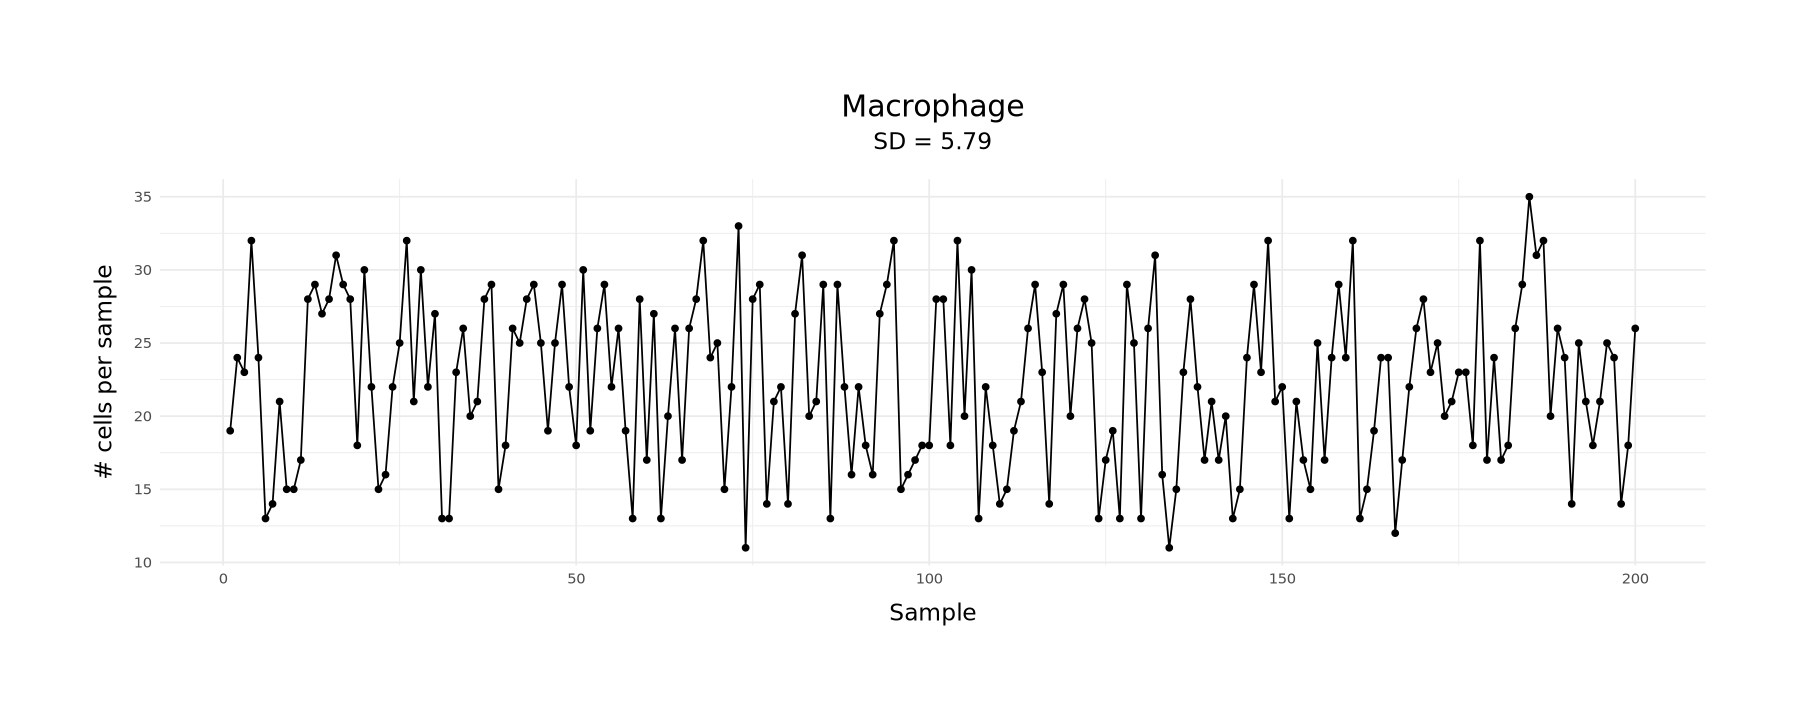

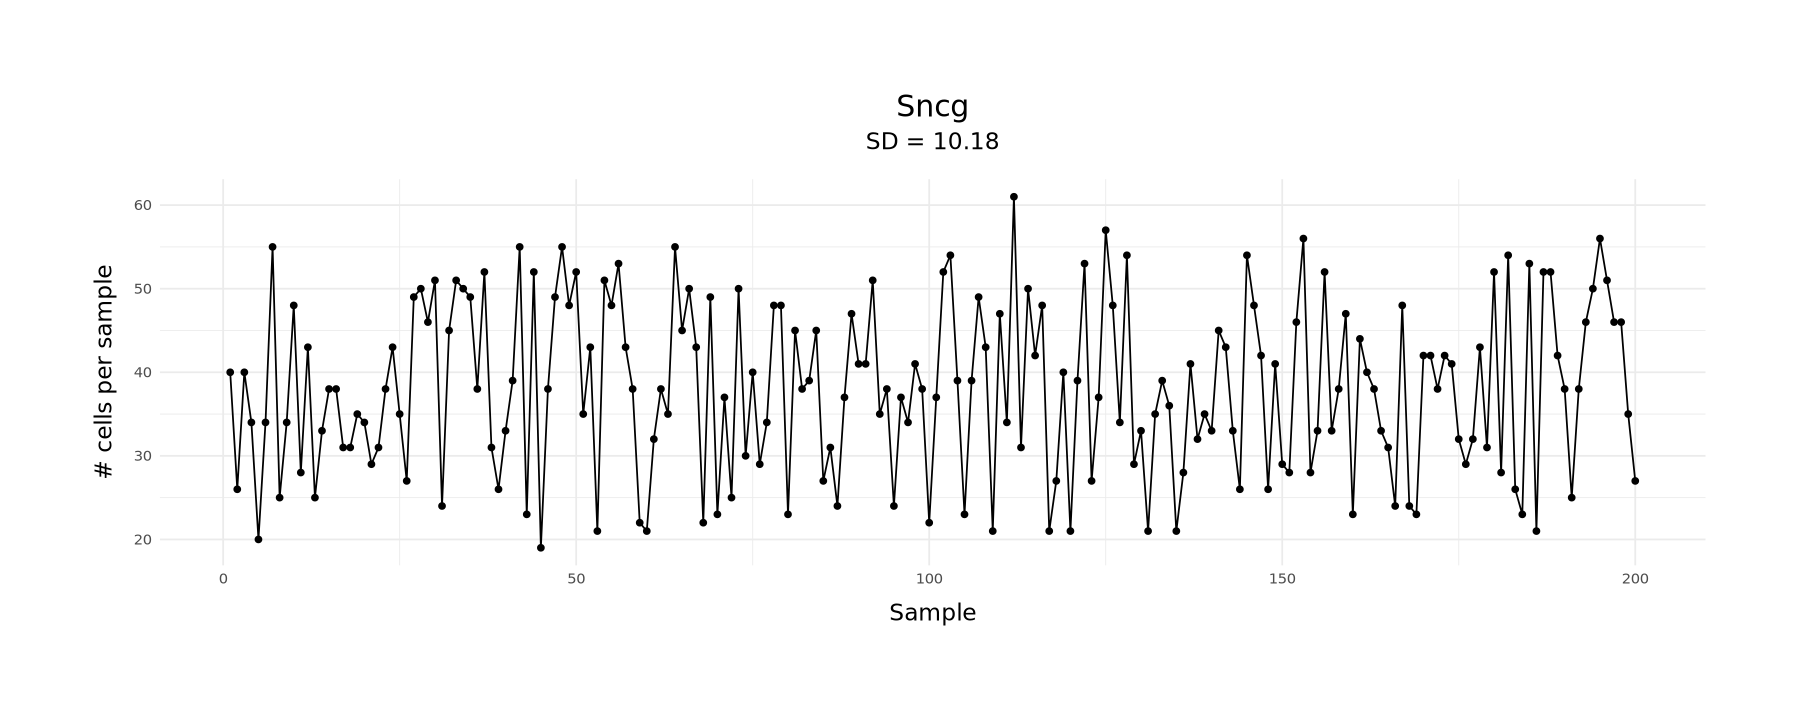

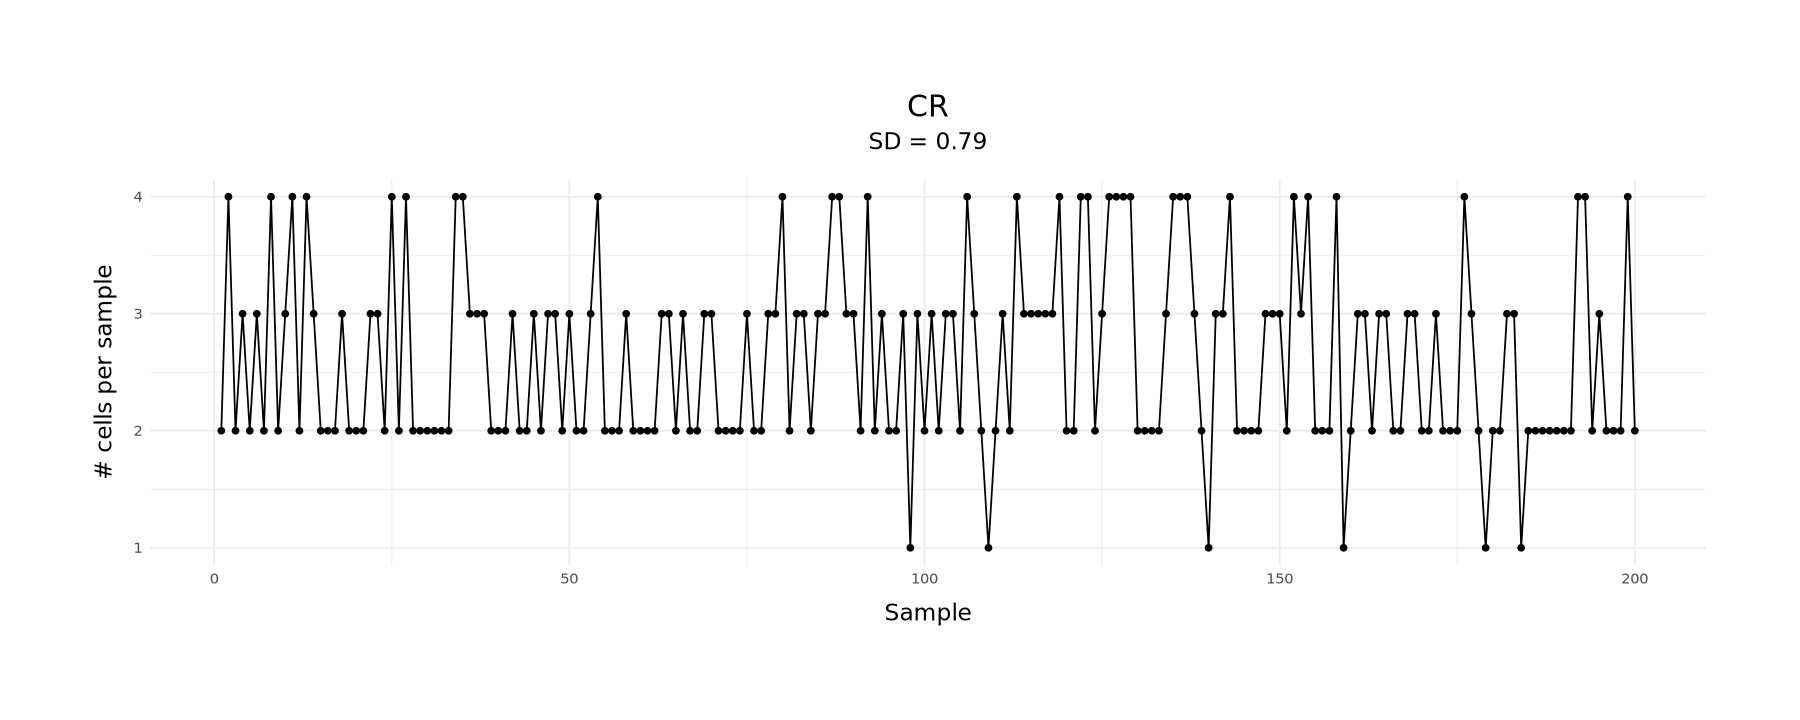

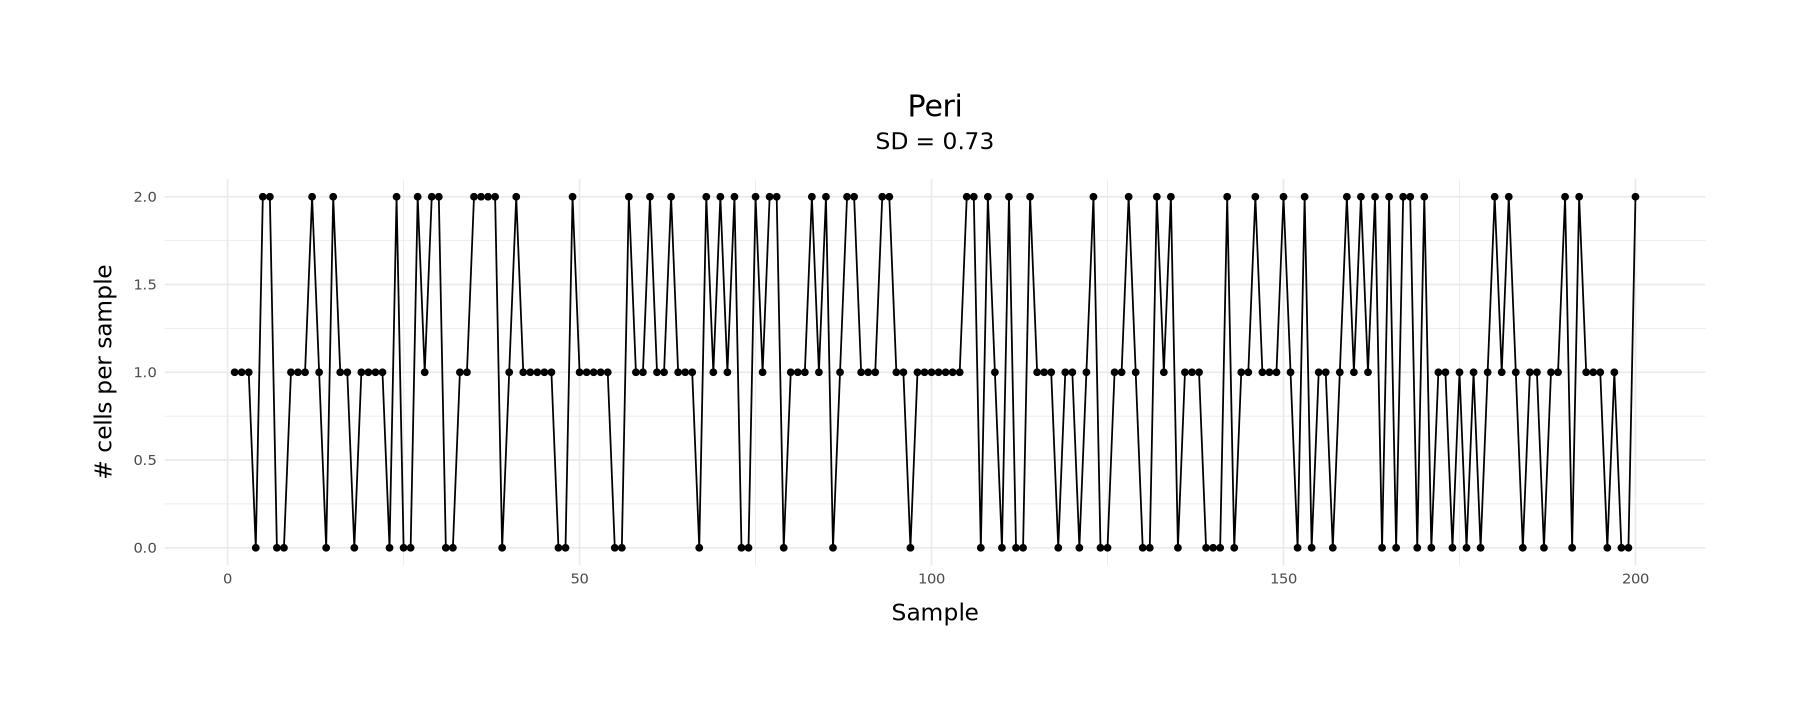

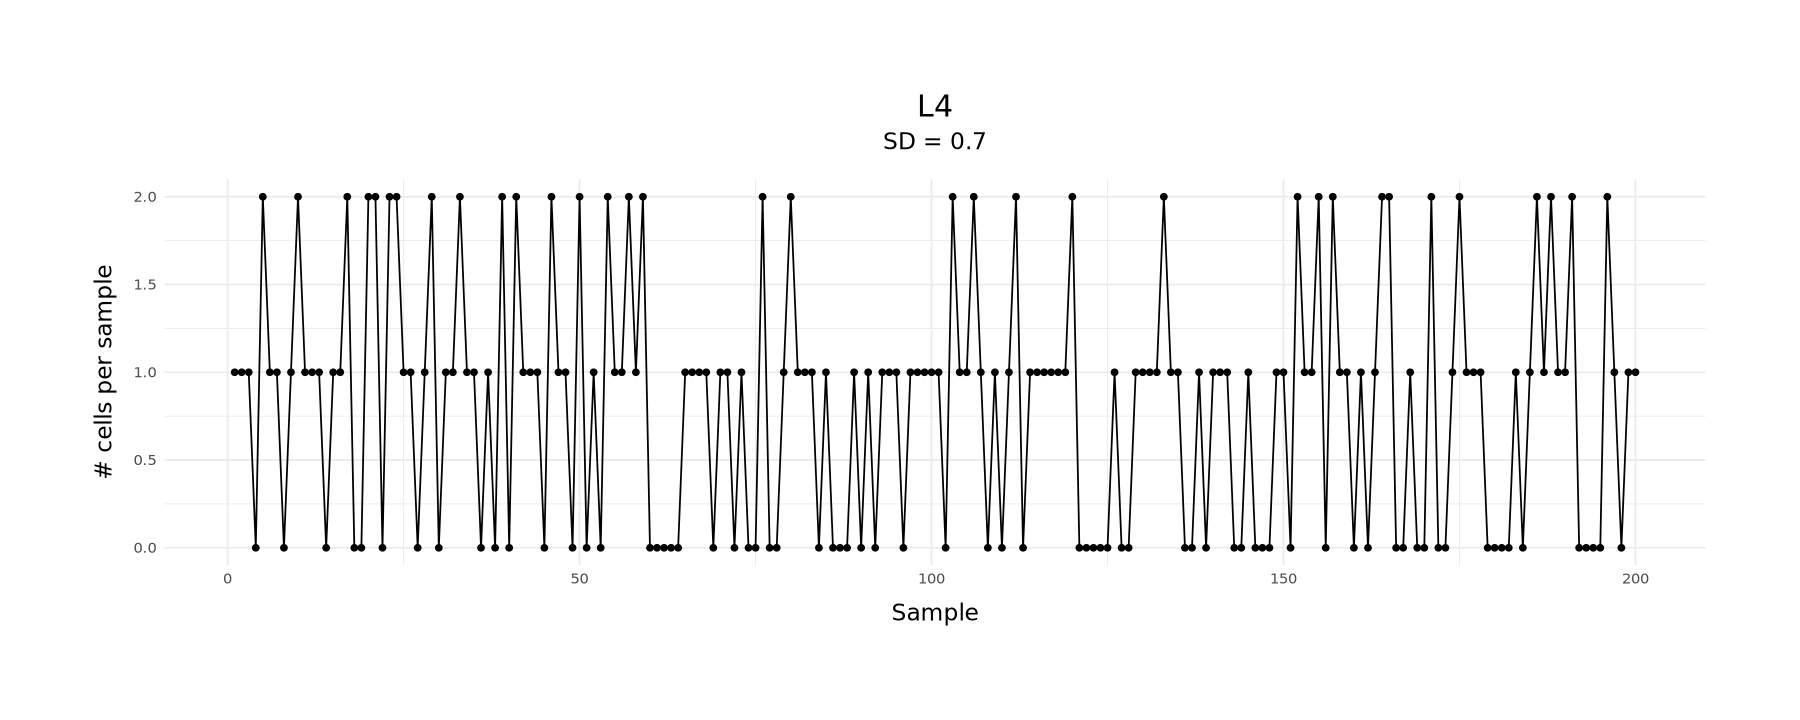

In [17]:
plot_ctype_abundance(pseudobulk_legend)

# Round 5 (50% var network; PosFDR module definition)

In [18]:
# network_dir <- "tasic_2018_ALM_STAR_30pcntCells_50pcntVar_200samples_log2_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_30pcntCells_50pcntVar_200samples_legend_05-16-36.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_30pcntCells_50pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [19]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [20]:
# top_corr_mods_50pcnt_PosFDR_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_50pcnt_PosFDR_df

# Round 6 (10% var network, PosFDR module definition)

In [21]:
# network_dir <- "tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules"

# pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_10pcntVar_200samples_legend_11-31-12.csv")
# pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
# pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

# top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_10pcntVar_200samples_log2_pseudobulk_PosFDR_top_Qval_modules.csv")

In [22]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [23]:
# top_corr_mods_10pcnt_PosFDR_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
# top_corr_mods_10pcnt_PosFDR_df

# Round 7 (10% var network, PosBC module definition)

In [24]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_10pcntVar_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_10pcntVar_200samples_legend_11-31-12.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_10pcntVar_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [25]:
# plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [26]:
top_corr_mods_10pcnt_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_10pcnt_PosBC_df

Cell_type  Cor       Old_cor    Module          Old_module   
rosybrown3      VLMC       0.2176395 0.09400113 rosybrown3      darkslateblue
yellow1         Serpinf1   0.2191469 0.04851468 yellow1         floralwhite  
greenyellow     Meis2      0.2200408 0.02326452 greenyellow     antiquewhite 
lightgoldenrod4 Sncg       0.2376732 0.11588496 lightgoldenrod4 orangered4   
steelblue3      CR         0.2723505 0.12232763 steelblue3      gray2        
plum2           Oligo      0.3083297 0.10097966 plum2           grey60       
royalblue       SMC        0.3581447 0.35386647 royalblue       purple       
magenta3        L6_IT      0.3912662 0.37324554 magenta3        hotpink3     
palevioletred4  L6_CT      0.4346011 0.42529993 palevioletred4  gray15       
grey12          L2_3_IT    0.4443491 0.27588970 grey12          magenta      
lightyellow2    L5_PT      0.4496355 0.41607542 lightyellow2    snow         
coral4          Endo       0.5163198 0.39715810 coral4          coral2       
slateblue3      Astro      0.5454351 0.46270702 slateblue3      pink         
magenta4        Macrophage 0.5541167 0.38740222 magenta4        black        
palevioletred31 NP         0.6424483 0.63868408 palevioletred3  moccasin     
steelblue       Lamp5      0.6650802 0.66508023 steelblue       steelblue    
tan             Vip        0.6663662 0.66380159 tan             violet       
yellow2         Pvalb      0.7129983 0.69291413 yellow2         navajowhite2 
mediumpurple2   Sst        0.7676593 0.68994282 mediumpurple2   skyblue3     
brown           L5_IT      0.8490237 0.75876648 brown           turquoise    
                Network                                            
rosybrown3      Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151 
yellow1         Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151 
greenyellow     Bicor-None_signum0.349_minSize10_merge_ME_0.9_20151
lightgoldenrod4 Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151 
steelblue3      Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151 
plum2           Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151 
royalblue       Bicor-None_signum0.705_minSize3_merge_ME_0.9_20151 
magenta3        Bicor-None_signum0.539_minSize3_merge_ME_0.9_20151 
palevioletred4  Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151 
grey12          Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151 
lightyellow2    Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151 
coral4          Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151 
slateblue3      Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151 
magenta4        Bicor-None_signum0.203_minSize5_merge_ME_0.9_20151 
palevioletred31 Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151 
steelblue       Bicor-None_signum0.156_minSize10_merge_ME_0.9_20151
tan             Bicor-None_signum0.705_minSize3_merge_ME_0.9_20151 
yellow2         Bicor-None_signum0.156_minSize5_merge_ME_0.9_20151 
mediumpurple2   Bicor-None_signum0.156_minSize10_merge_ME_0.9_20151
brown           Bicor-None_signum0.705_minSize3_merge_ME_0.9_20151 
                Old_network                                        
rosybrown3      Bicor-None_signum0.539_minSize4_merge_ME_0.9_20151 
yellow1         Bicor-None_signum0.349_minSize4_merge_ME_0.9_20151 
greenyellow     Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151 
lightgoldenrod4 Bicor-None_signum0.349_minSize6_merge_ME_0.9_20151 
steelblue3      Bicor-None_signum0.349_minSize3_merge_ME_0.9_20151 
plum2           Bicor-None_signum0.539_minSize6_merge_ME_0.9_20151 
royalblue       Bicor-None_signum0.539_minSize3_merge_ME_0.9_20151 
magenta3        Bicor-None_signum0.349_minSize4_merge_ME_0.9_20151 
palevioletred4  Bicor-None_signum0.173_minSize5_merge_ME_0.9_20151 
grey12          Bicor-None_signum0.705_minSize4_merge_ME_0.9_20151 
lightyellow2    Bicor-None_signum0.173_minSize5_merge_ME_0.9_20151 
coral4          Bicor-None_signum0.349_minSize5_merge_ME_0.9_20151 
slateblue3      Bicor-None_signum0.349_minSize10_merge_ME_0.9_2015

# Round 8 (kappa = 25 network, PosBC module definition)

In [27]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_25kappa_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

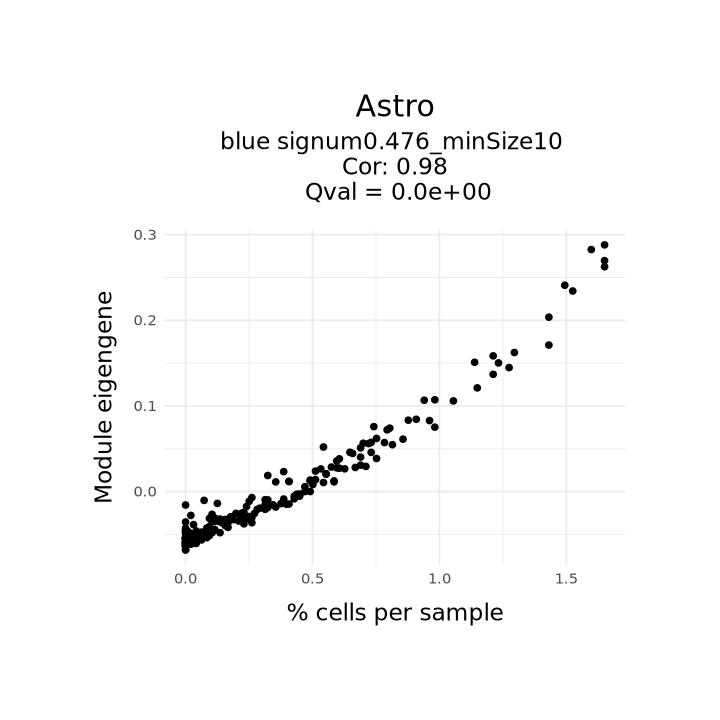

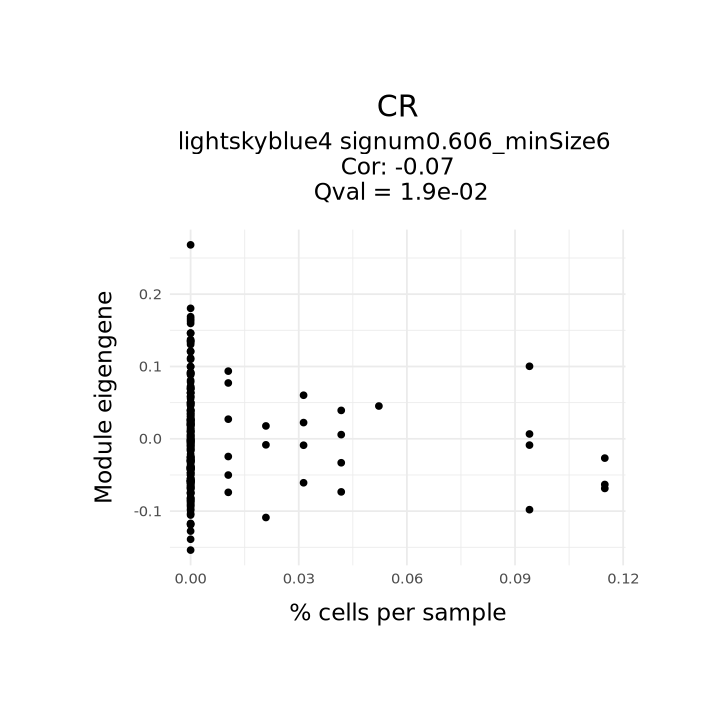

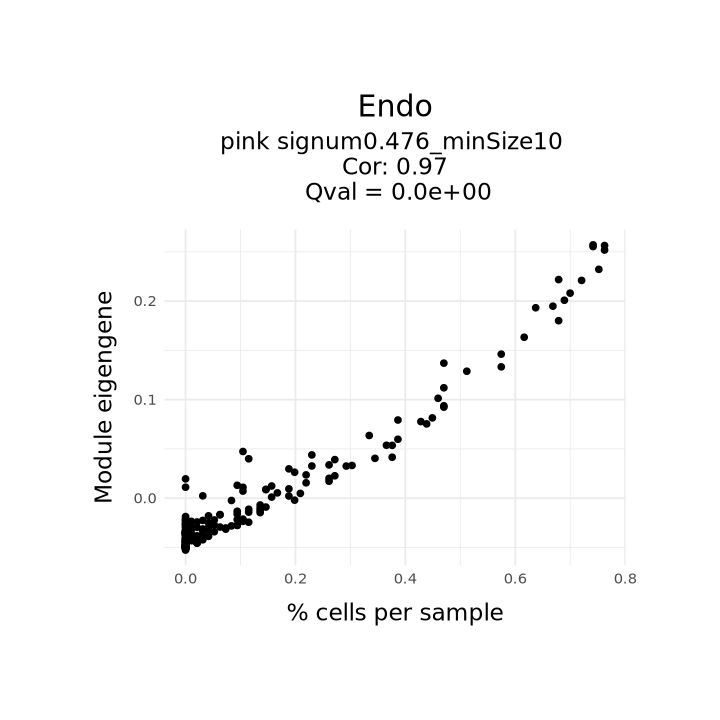

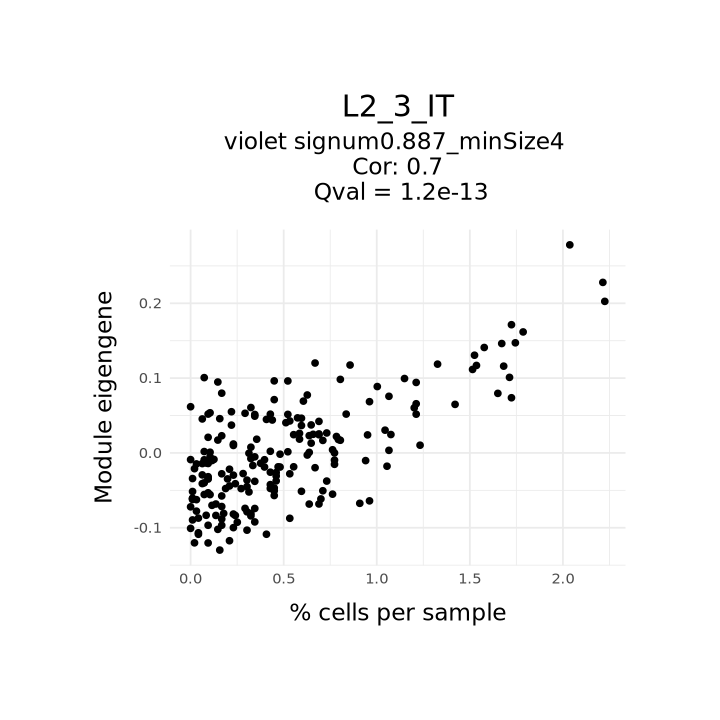

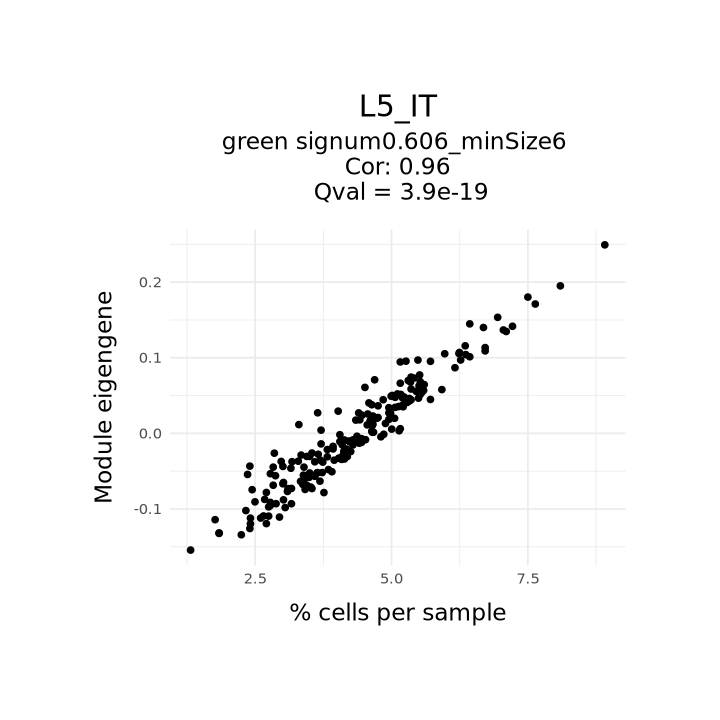

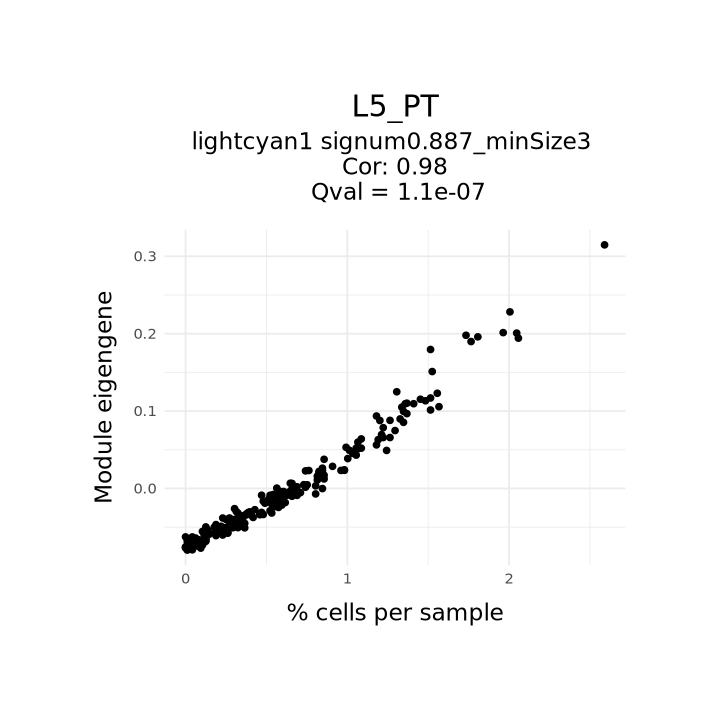

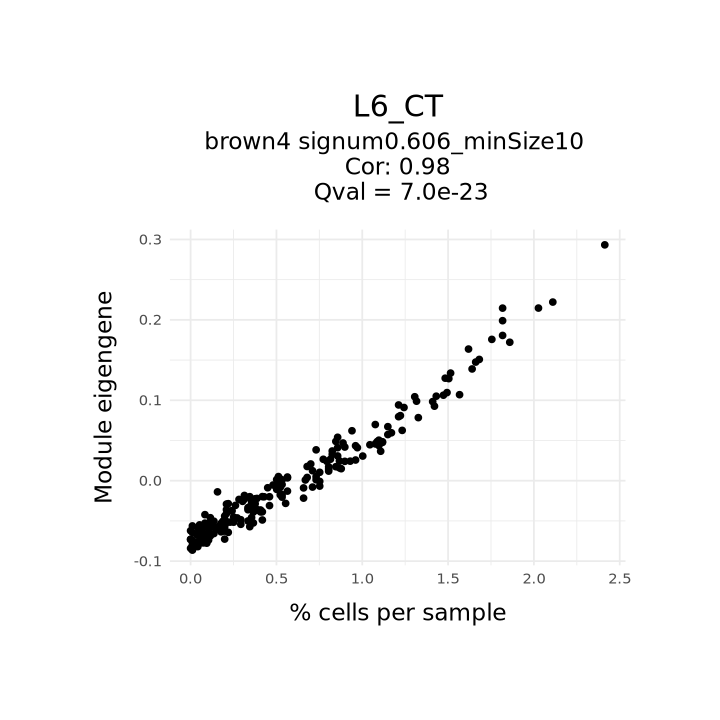

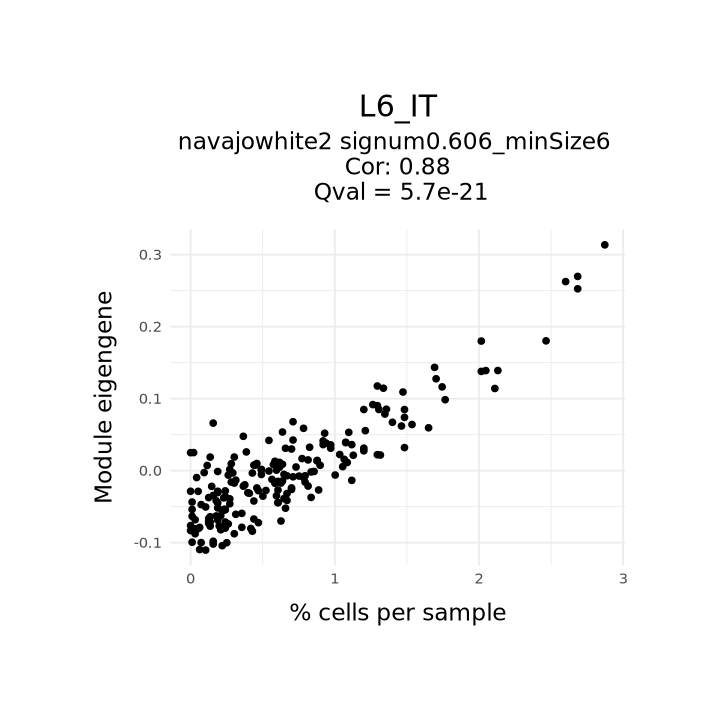

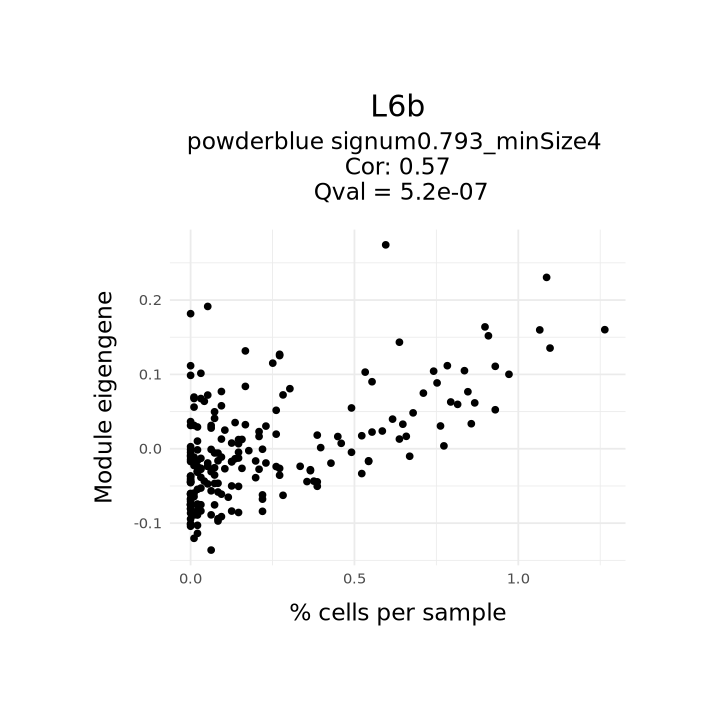

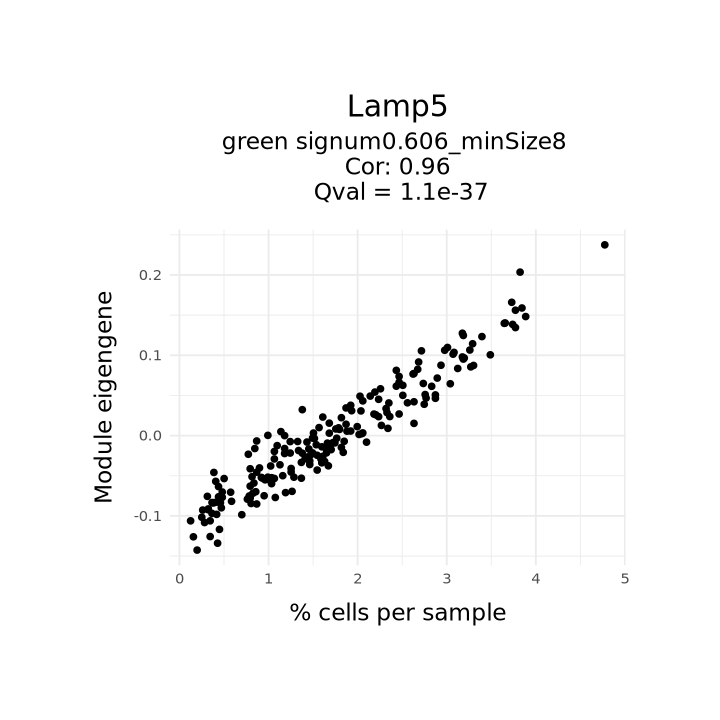

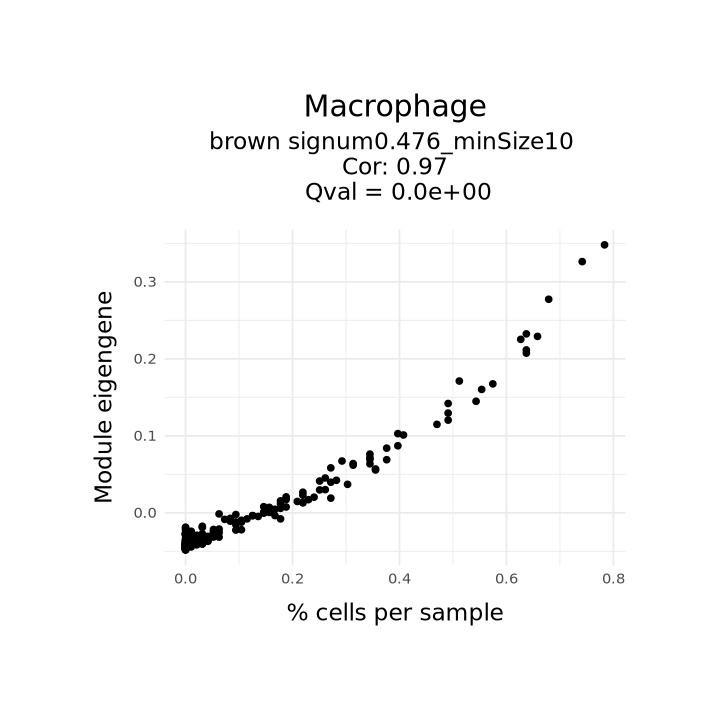

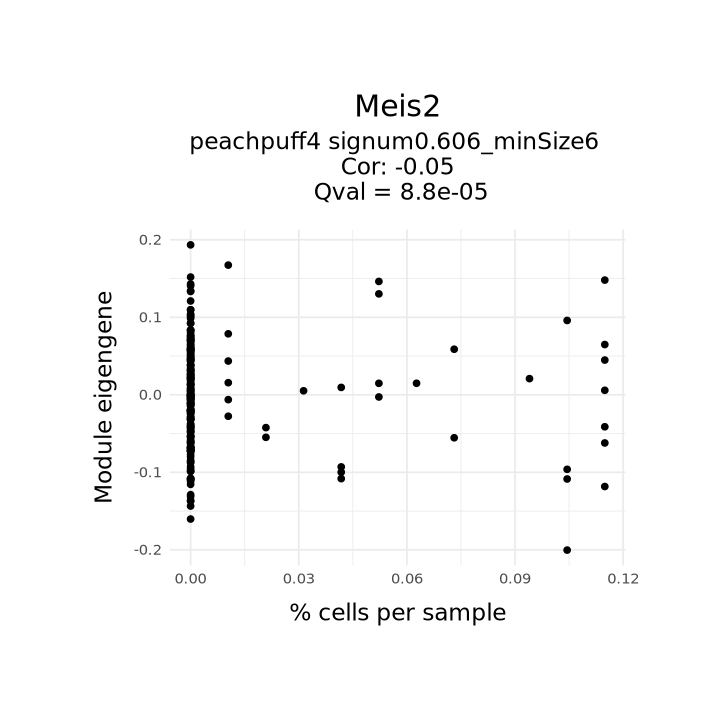

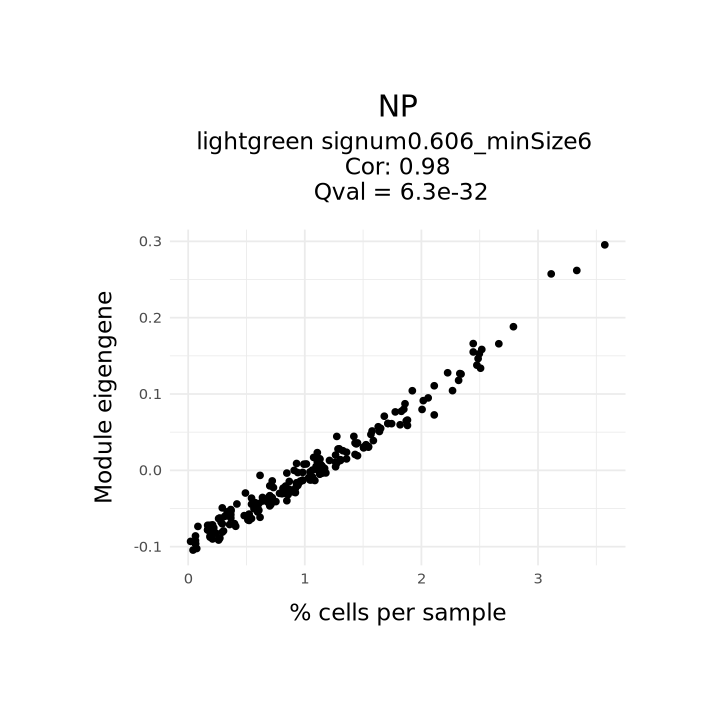

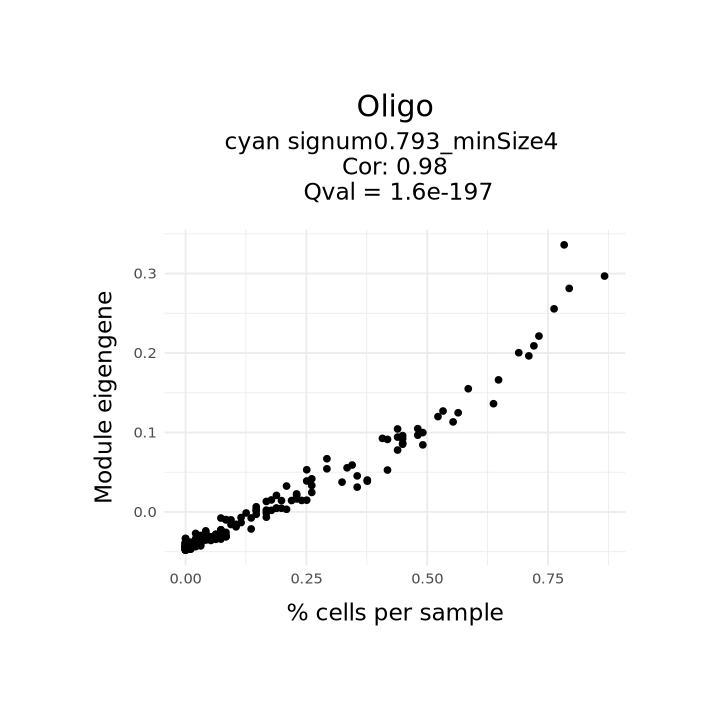

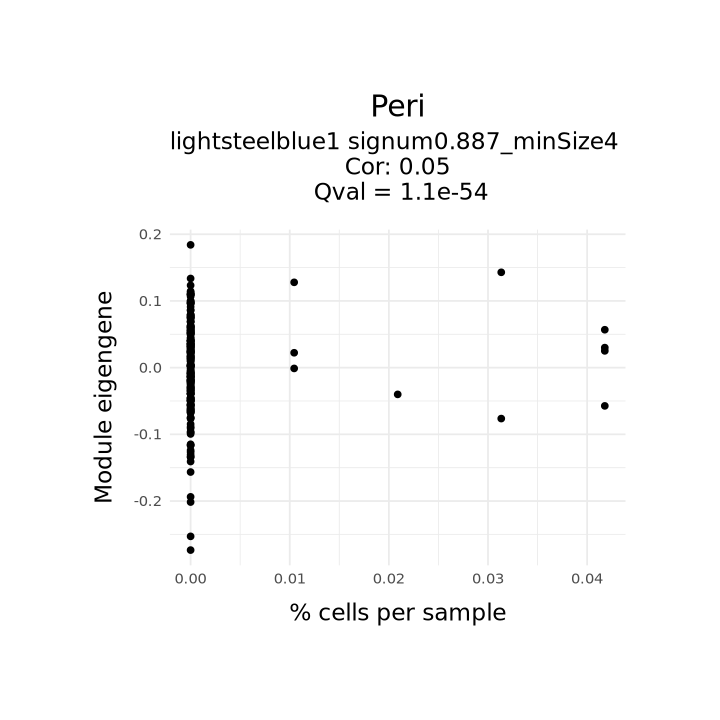

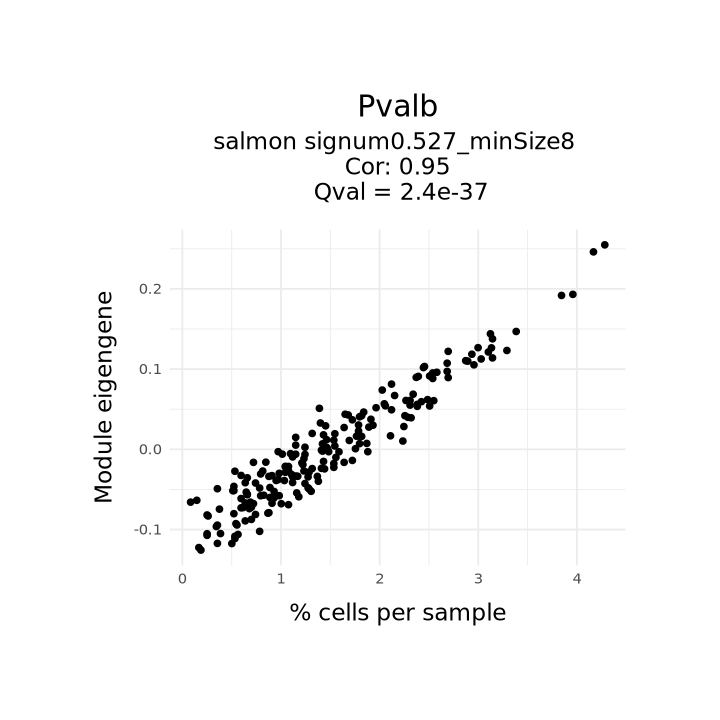

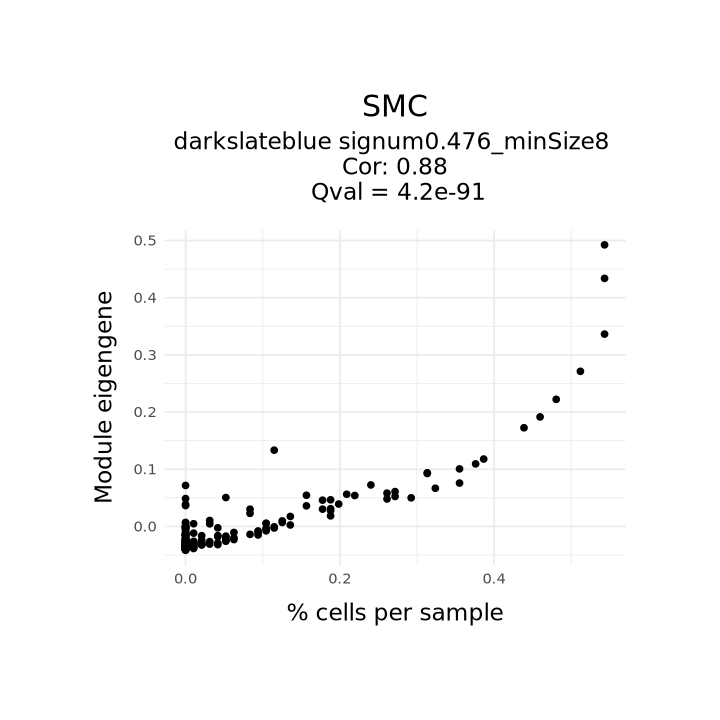

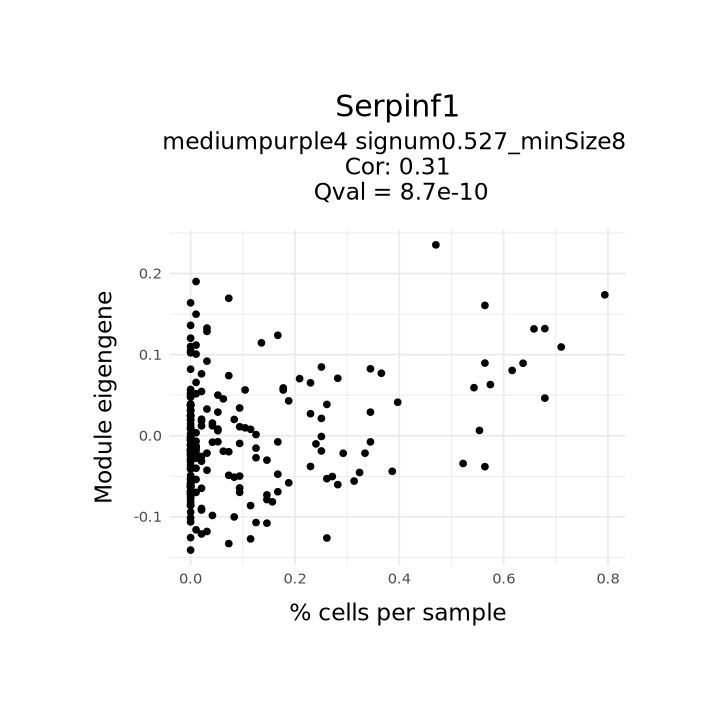

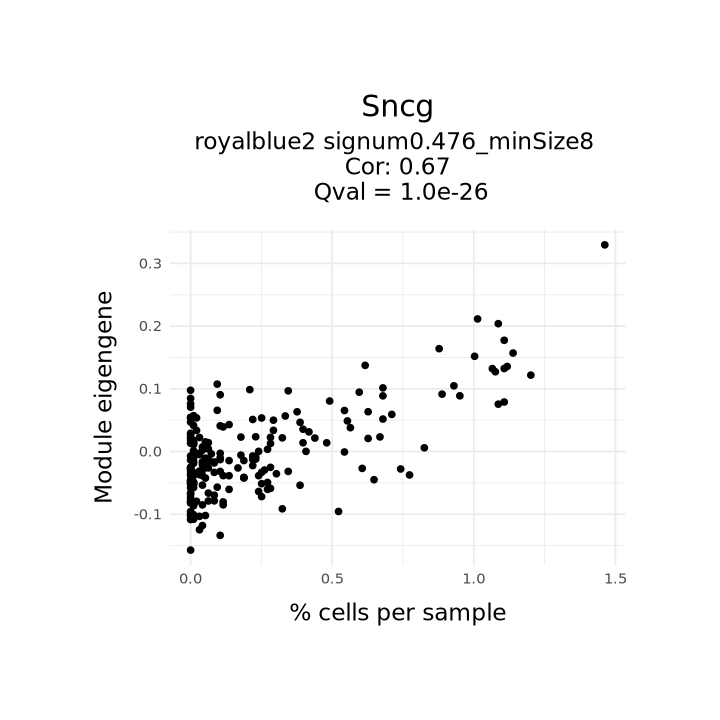

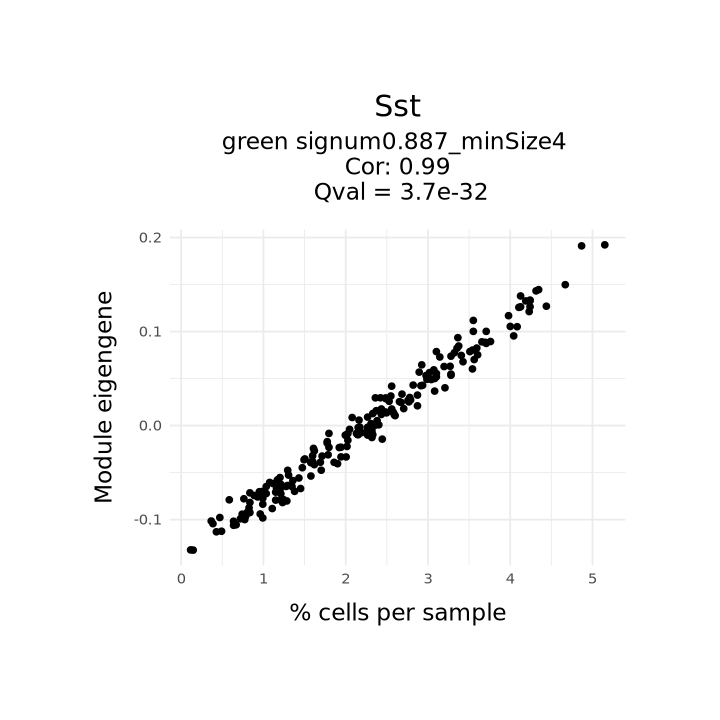

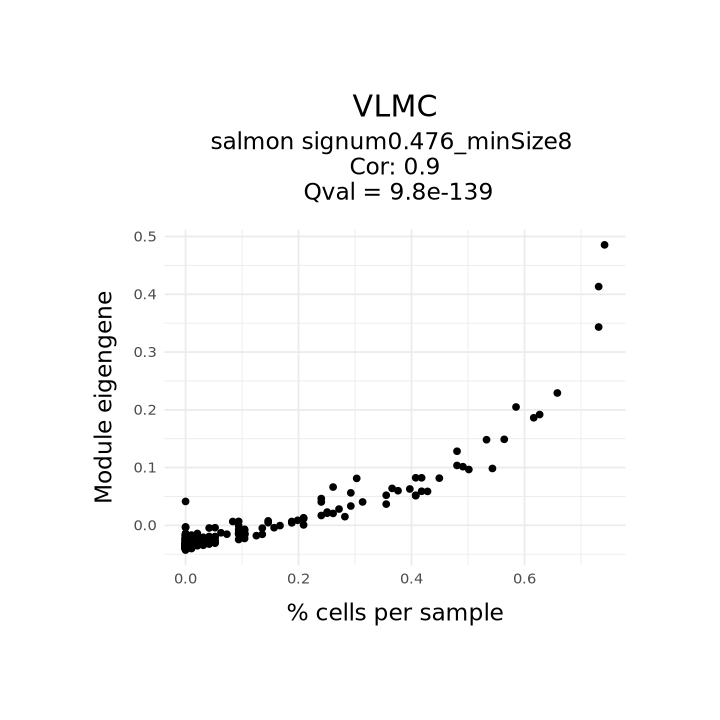

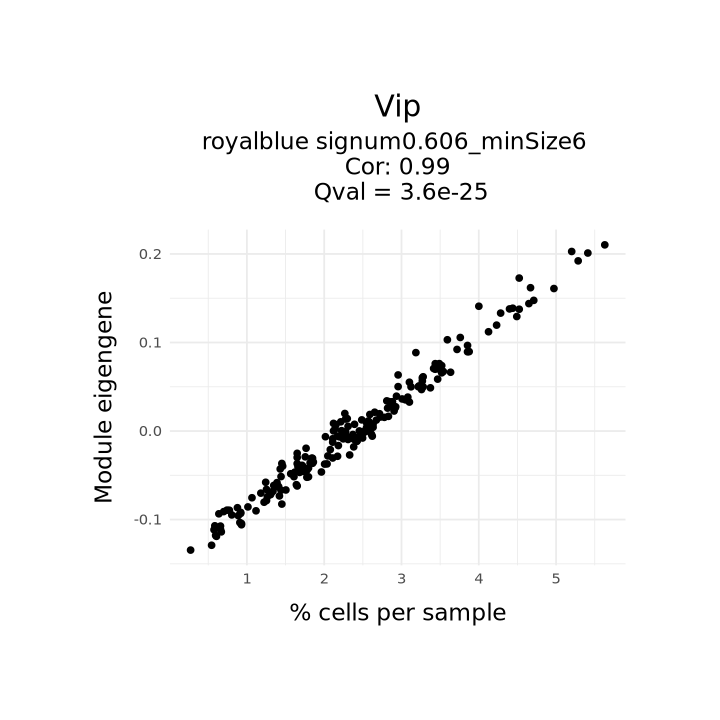

In [28]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

In [29]:
top_corr_mods_25kappa_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_25kappa_PosBC_df

Cell_type  Cor       Old_cor     Module         Old_module     
navajowhite1   Peri       0.1932410  0.05267446 navajowhite    lightsteelblue1
firebrick1     CR         0.2303541 -0.06763805 firebrick1     lightskyblue4  
brown3         Meis2      0.3125991 -0.05137787 brown3         peachpuff4     
honeydew       Serpinf1   0.4026167  0.30979272 honeydew       mediumpurple4  
powderblue     L6b        0.5722537  0.57225369 powderblue     powderblue     
firebrick11    Sncg       0.6889803  0.66953336 firebrick1     royalblue2     
darkslateblue  SMC        0.8800080  0.88000800 darkslateblue  darkslateblue  
ivory          L6_IT      0.9108326  0.87961021 ivory          navajowhite2   
palevioletred3 VLMC       0.9117353  0.90136592 palevioletred3 salmon         
burlywood      L2_3_IT    0.9793319  0.70228174 burlywood      violet         
yellow4        L5_IT      0.9793463  0.95661023 yellow         green          
salmon1        Oligo      0.9823470  0.97737571 salmon         cyan           
lavenderblush3 L5_PT      0.9832736  0.98207678 lavenderblush3 lightcyan1     
lightgreen     L6_CT      0.9857231  0.97939516 lightgreen     brown4         
salmon11       Vip        0.9896692  0.98710093 salmon         royalblue      
yellow         NP         0.9899614  0.98435235 yellow         lightgreen     
tan            Lamp5      0.9912068  0.95672816 tan            green          
violet         Pvalb      0.9934442  0.95402249 violet         salmon         
darkred        Sst        0.9939074  0.98827527 darkred        green          
turquoise11    Astro      0.9940807  0.97566956 turquoise      blue           
salmon         Endo       0.9963366  0.97349791 salmon         pink           
brown2         Macrophage 0.9965619  0.97445447 brown          brown          
               Network                                            
navajowhite1   Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151 
firebrick1     Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151 
brown3         Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151 
honeydew       Bicor-None_signum0.887_minSize3_merge_ME_0.9_20151 
powderblue     Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151 
firebrick11    Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151 
darkslateblue  Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151 
ivory          Bicor-None_signum0.793_minSize5_merge_ME_0.9_20151 
palevioletred3 Bicor-None_signum0.793_minSize6_merge_ME_0.9_20151 
burlywood      Bicor-None_signum0.476_minSize10_merge_ME_0.9_20151
yellow4        Bicor-None_signum0.941_minSize4_merge_ME_0.9_20151 
salmon1        Bicor-None_signum0.887_minSize3_merge_ME_0.9_20151 
lavenderblush3 Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151 
lightgreen     Bicor-None_signum0.793_minSize10_merge_ME_0.9_20151
salmon11       Bicor-None_signum0.793_minSize5_merge_ME_0.9_20151 
yellow         Bicor-None_signum0.887_minSize10_merge_ME_0.9_20151
tan            Bicor-None_signum0.941_minSize3_merge_ME_0.9_20151 
violet         Bicor-None_signum0.887_minSize3_merge_ME_0.9_20151 
darkred        Bicor-None_signum0.476_minSize10_merge_ME_0.9_20151
turquoise11    Bicor-None_signum0.977_minSize3_merge_ME_0.9_20151 
salmon         Bicor-None_signum0.941_minSize3_merge_ME_0.9_20151 
brown2         Bicor-None_signum0.977_minSize3_merge_ME_0.9_20151 
               Old_network                                        
navajowhite1   Bicor-None_signum0.887_minSize4_merge_ME_0.9_20151 
firebrick1     Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151 
brown3         Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151 
honeydew       Bicor-None_signum0.527_minSize8_merge_ME_0.9_20151 
powderblue     Bicor-None_signum0.793_minSize4_merge_ME_0.9_20151 
firebrick11    Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151 
darkslateblue  Bicor-None_signum0.476_minSize8_merge_ME_0.9_20151 
ivory          Bicor-None_signum0.606_minSize6_merge_ME_0.9_20151 
palevioletred3 Bicor-None_signum0.476_minSize8_merge_M

# Round 9 (kappa = 25 network, PosBC module definition; merge param = 0.85)

In [30]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_log2_pseudobulk_mergeParam0.85_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_25kappa_200samples_log2_pseudobulk_mergeParam0.85_PosBC_top_Qval_modules.csv")

In [31]:
top_corr_mods_25kappa_merge0.85_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_25kappa_merge0.85_PosBC_df

Cell_type  Cor       Old_cor     Module         Old_module  
plum           Peri       0.1932410  0.05267446 plum           darkgrey    
plum21         Serpinf1   0.2668425  0.25484687 plum2          royalblue2  
antiquewhite2  Meis2      0.3125991 -0.12519679 antiquewhite2  maroon      
firebrick4     L6b        0.5722537  0.57225369 firebrick4     firebrick4  
palevioletred2 Sncg       0.6695334  0.66953336 palevioletred2 navajowhite1
ivory          SMC        0.8800080  0.88000800 ivory          ivory       
lightgreen     VLMC       0.9033068  0.89501574 lightgreen     lightgreen  
sienna31       L6_IT      0.9108326  0.91083265 sienna3        sienna3     
magenta1       Pvalb      0.9720580  0.88210199 magenta        black       
coral3         L2_3_IT    0.9793319  0.94704261 coral3         skyblue     
red1           L5_IT      0.9805647  0.95791055 red            pink        
plum2          L5_PT      0.9832736  0.93201266 plum2          lightcyan1  
midnightblue2  Oligo      0.9844586  0.96884614 midnightblue   cyan        
grey60         L6_CT      0.9857231  0.90342927 grey60         orange      
tan            Vip        0.9896692  0.97321869 tan            cyan        
yellow         Sst        0.9899247  0.97709150 yellow         pink        
greenyellow11  NP         0.9913649  0.95642328 greenyellow    salmon      
purple         Lamp5      0.9922547  0.97796030 purple         greenyellow 
turquoise8     Astro      0.9940807  0.97597533 turquoise      blue        
greenyellow1   Endo       0.9963366  0.97407924 greenyellow    purple      
blue2          Macrophage 0.9965619  0.97445447 blue           red         
               Network                                             
plum           Bicor-None_signum0.793_minSize4_merge_ME_0.85_20151 
plum21         Bicor-None_signum0.607_minSize6_merge_ME_0.85_20151 
antiquewhite2  Bicor-None_signum0.607_minSize6_merge_ME_0.85_20151 
firebrick4     Bicor-None_signum0.793_minSize4_merge_ME_0.85_20151 
palevioletred2 Bicor-None_signum0.476_minSize10_merge_ME_0.85_20151
ivory          Bicor-None_signum0.476_minSize8_merge_ME_0.85_20151 
lightgreen     Bicor-None_signum0.527_minSize10_merge_ME_0.85_20151
sienna31       Bicor-None_signum0.793_minSize5_merge_ME_0.85_20151 
magenta1       Bicor-None_signum0.95_minSize3_merge_ME_0.85_20151  
coral3         Bicor-None_signum0.476_minSize8_merge_ME_0.85_20151 
red1           Bicor-None_signum0.897_minSize6_merge_ME_0.85_20151 
plum2          Bicor-None_signum0.793_minSize4_merge_ME_0.85_20151 
midnightblue2  Bicor-None_signum0.897_minSize3_merge_ME_0.85_20151 
grey60         Bicor-None_signum0.793_minSize10_merge_ME_0.85_20151
tan            Bicor-None_signum0.793_minSize5_merge_ME_0.85_20151 
yellow         Bicor-None_signum0.897_minSize10_merge_ME_0.85_20151
greenyellow11  Bicor-None_signum0.897_minSize5_merge_ME_0.85_20151 
purple         Bicor-None_signum0.95_minSize3_merge_ME_0.85_20151  
turquoise8     Bicor-None_signum0.98_minSize3_merge_ME_0.85_20151  
greenyellow1   Bicor-None_signum0.95_minSize3_merge_ME_0.85_20151  
blue2          Bicor-None_signum0.98_minSize3_merge_ME_0.85_20151  
               Old_network                                         
plum           Bicor-None_signum0.897_minSize4_merge_ME_0.85_20151 
plum21         Bicor-None_signum0.476_minSize8_merge_ME_0.85_20151 
antiquewhite2  Bicor-None_signum0.793_minSize4_merge_ME_0.85_20151 
firebrick4     Bicor-None_signum0.793_minSize4_merge_ME_0.85_20151 
palevioletred2 Bicor-None_signum0.476_minSize8_merge_ME_0.85_20151 
ivory          Bicor-None_signum0.476_minSize8_merge_ME_0.85_20151 
lightgreen     Bicor-None_signum0.607_minSize6_merge_ME_0.85_20151 
sienna31       Bicor-None_signum0.793_minSize5_merge_ME_0.85_20151 
magenta1       Bicor-None_signum0.476_minSize8_merge_ME_0.85_20151 
coral3         Bicor-None_signum0.607_minSize10_merge_ME_0.85_20151
red1           Bicor-None_signum0.527_minSize8_merge_ME_0.85_20151 
plum2          Bicor-None_signu

# Round 9 (kappa = 25 network, PosBC module definition; no log2 transform)

In [45]:
network_dir <- "tasic_2018_ALM_STAR_20pcntCells_25kappa_200samples_pseudobulk_Modules"

pseudobulk_legend <- read.csv("data/SyntheticDatasets/SyntheticDataset1_20pcntCells_25kappa_200samples_legend_08-10-34.csv")
pseudobulk_legend$Cell.type <- gsub("/", "_", pseudobulk_legend$Cell.type, fixed=TRUE)
pseudobulk_legend$Cell.type <- gsub(" ", "_", pseudobulk_legend$Cell.type)

top_qval_mods_df <- read.csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_DE_genes_dream_unique_20pcntCells_25kappa_200samples_pseudobulk_PosBC_top_Qval_modules.csv")

In [33]:
top_corr_mods_25kappa_nolog_PosBC_df <- get_top_corr_mods(network_dir, pseudobulk_legend, top_qval_mods_df)
top_corr_mods_25kappa_nolog_PosBC_df

Cell_type  Cor       Old_cor     Module        Old_module    
coral4        Peri       0.1944085  0.05282139 coral4        yellowgreen   
lightyellow2  CR         0.2300683 -0.05805480 lightyellow2  red1          
rosybrown2    Meis2      0.3197981 -0.12495399 rosybrown2    palevioletred2
dodgerblue3   Serpinf1   0.5693761  0.56937609 dodgerblue3   dodgerblue3   
chocolate3    L6b        0.5733157  0.57331574 chocolate3    chocolate3    
lightyellow21 Sncg       0.7011322  0.70113222 lightyellow2  darkgoldenrod 
lightpink3    SMC        0.8564179  0.79531759 lightpink3    tomato        
coral2        VLMC       0.8802448  0.87387963 coral2        purple        
darkslateblue L6_IT      0.9029690  0.88095034 darkslateblue skyblue1      
grey601       Oligo      0.9637300  0.96228492 grey60        greenyellow   
darkgrey      Macrophage 0.9714174  0.96833512 darkgrey      yellow        
turquoise7    Astro      0.9780475  0.96521325 turquoise     turquoise     
sienna        L2_3_IT    0.9786095  0.73656553 sienna        paleturquoise 
salmon        Endo       0.9821506  0.97748455 salmon        red           
mediumorchid  L5_PT      0.9826412  0.98132944 mediumorchid  yellowgreen   
brown8        L5_IT      0.9829472  0.94872014 brown         green         
grey60        L6_CT      0.9847716  0.98076481 grey60        paleturquoise 
midnightblue  NP         0.9866012  0.97710219 midnightblue  salmon        
green         Vip        0.9880487  0.98675899 green         lightyellow   
tan1          Lamp5      0.9897281  0.95035317 tan           red           
thistle1      Pvalb      0.9903057  0.95680939 thistle1      tan           
salmon1       Sst        0.9914202  0.98557814 salmon        black         
              Network                                            
coral4        Bicor-None_signum0.787_minSize4_merge_ME_0.9_20151 
lightyellow2  Bicor-None_signum0.474_minSize8_merge_ME_0.9_20151 
rosybrown2    Bicor-None_signum0.474_minSize8_merge_ME_0.9_20151 
dodgerblue3   Bicor-None_signum0.474_minSize8_merge_ME_0.9_20151 
chocolate3    Bicor-None_signum0.787_minSize4_merge_ME_0.9_20151 
lightyellow21 Bicor-None_signum0.474_minSize8_merge_ME_0.9_20151 
lightpink3    Bicor-None_signum0.603_minSize6_merge_ME_0.9_20151 
coral2        Bicor-None_signum0.892_minSize3_merge_ME_0.9_20151 
darkslateblue Bicor-None_signum0.787_minSize4_merge_ME_0.9_20151 
grey601       Bicor-None_signum0.787_minSize6_merge_ME_0.9_20151 
darkgrey      Bicor-None_signum0.787_minSize10_merge_ME_0.9_20151
turquoise7    Bicor-None_signum0.94_minSize10_merge_ME_0.9_20151 
sienna        Bicor-None_signum0.474_minSize10_merge_ME_0.9_20151
salmon        Bicor-None_signum0.787_minSize10_merge_ME_0.9_20151
mediumorchid  Bicor-None_signum0.787_minSize4_merge_ME_0.9_20151 
brown8        Bicor-None_signum0.961_minSize3_merge_ME_0.9_20151 
grey60        Bicor-None_signum0.787_minSize10_merge_ME_0.9_20151
midnightblue  Bicor-None_signum0.787_minSize10_merge_ME_0.9_20151
green         Bicor-None_signum0.892_minSize10_merge_ME_0.9_20151
tan1          Bicor-None_signum0.94_minSize3_merge_ME_0.9_20151  
thistle1      Bicor-None_signum0.787_minSize4_merge_ME_0.9_20151 
salmon1       Bicor-None_signum0.787_minSize4_merge_ME_0.9_20151 
              Old_network                                         Pseudobulk_SD
coral4        Bicor-None_signum0.892_minSize4_merge_ME_0.9_20151    0.65       
lightyellow2  Bicor-None_signum0.603_minSize6_merge_ME_0.9_20151    1.96       
rosybrown2    Bicor-None_signum0.787_minSize5_merge_ME_0.9_20151    2.71       
dodgerblue3   Bicor-None_signum0.474_minSize8_merge_ME_0.9_20151   16.64       
chocolate3    Bicor-None_signum0.787_minSize4_merge_ME_0.9_20151   27.72       
lightyellow21 Bicor-None_signum0.526_minSize8_merge_ME_0.9_20151   30.88       
lightpink3    Bicor-None_signum0.474_minSize10_merge_ME_0.9_20151  11.55       
coral2        Bicor-None_signum0.474_minSize10_merge_ME_0.9_20151  16.84       
darkslateblue Bicor-None_sig

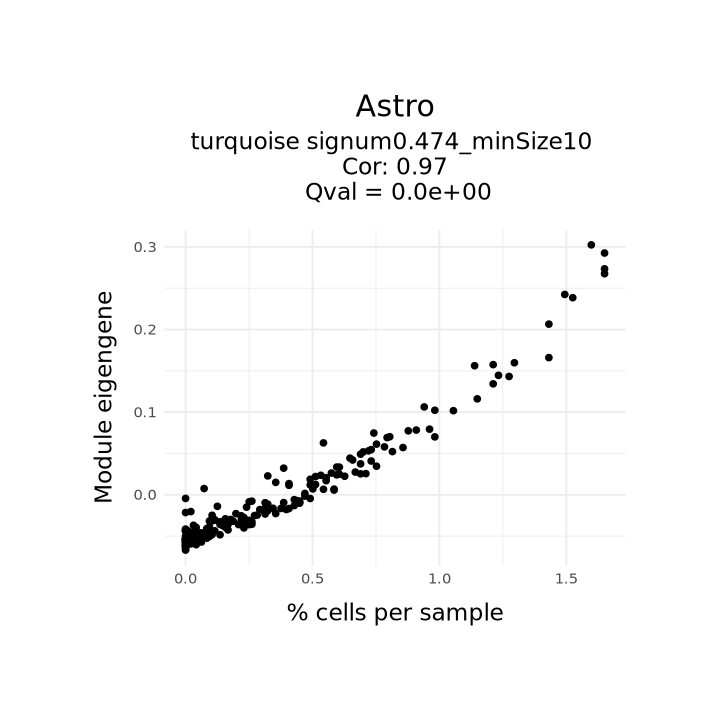

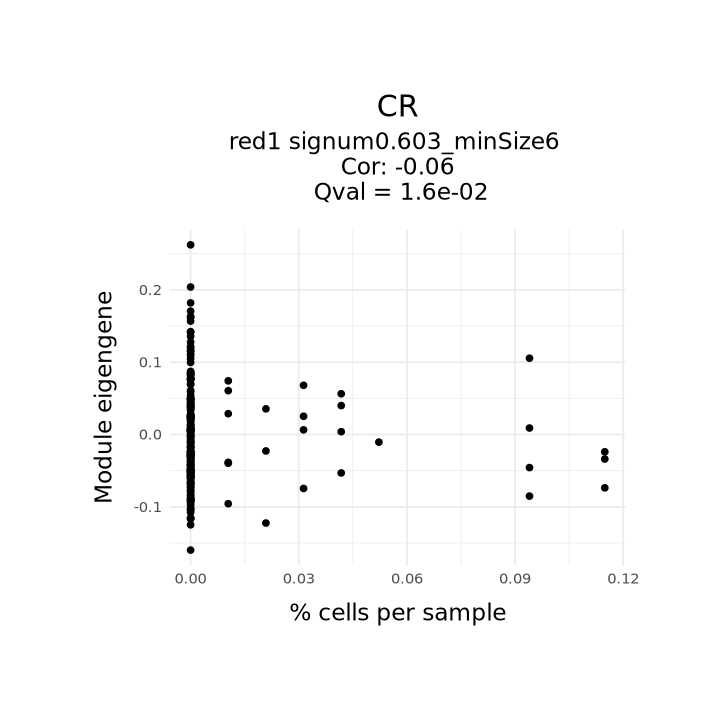

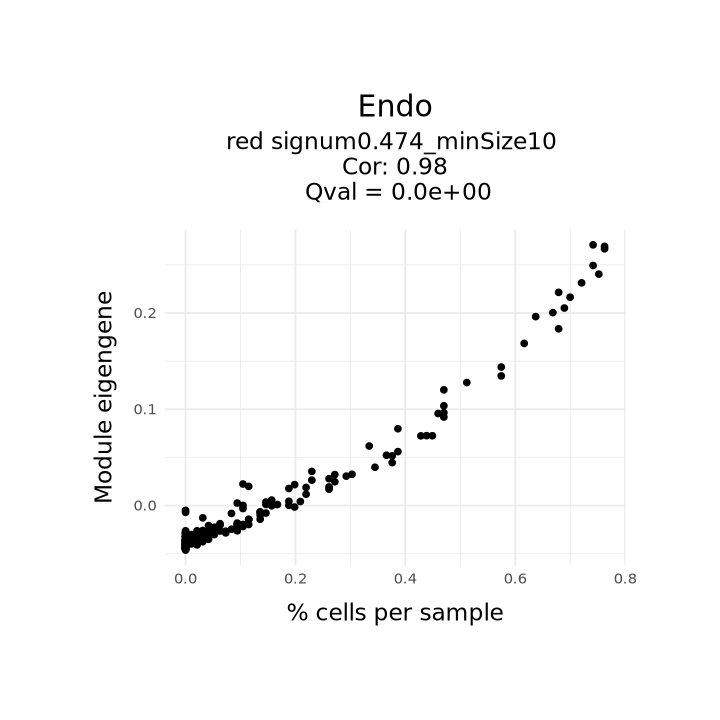

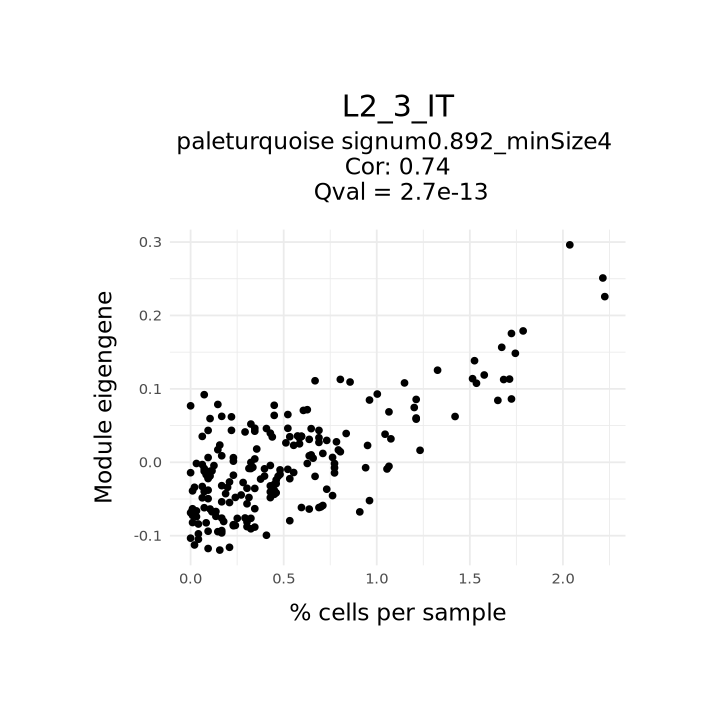

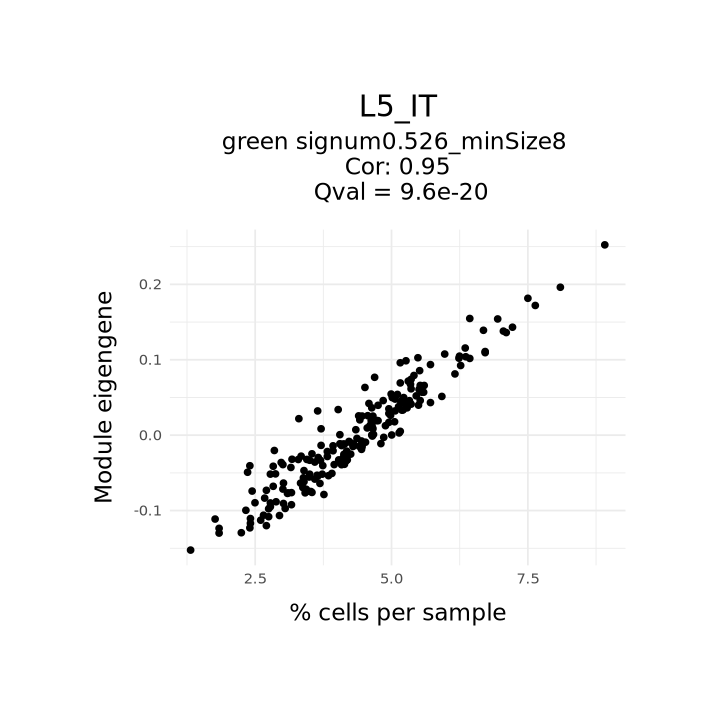

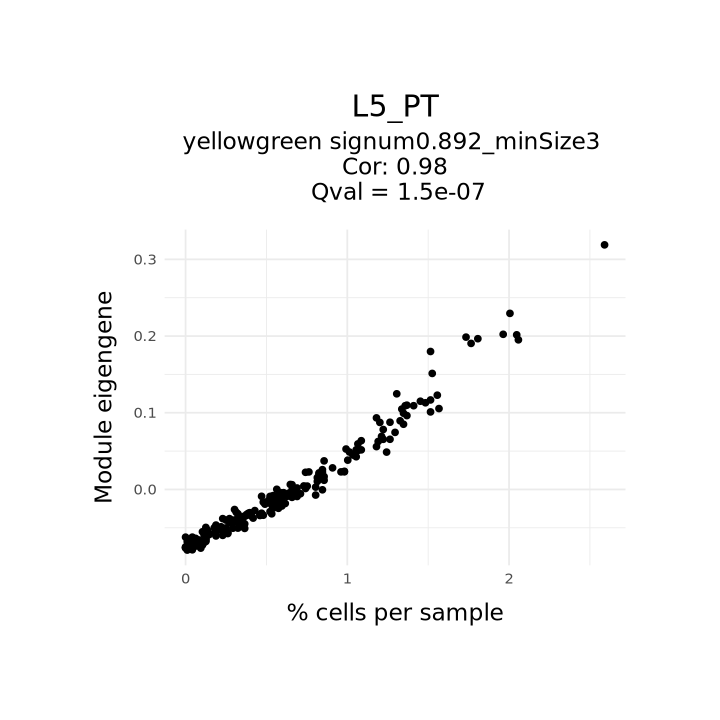

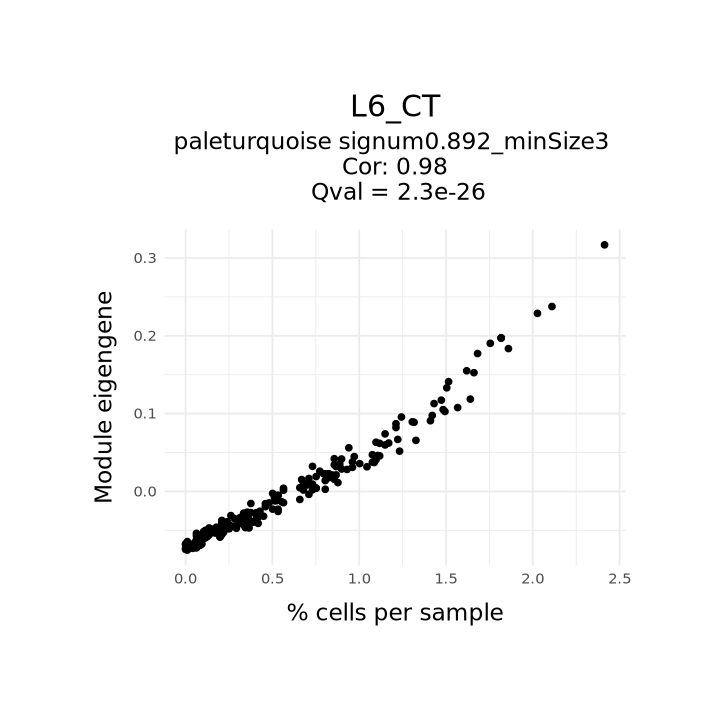

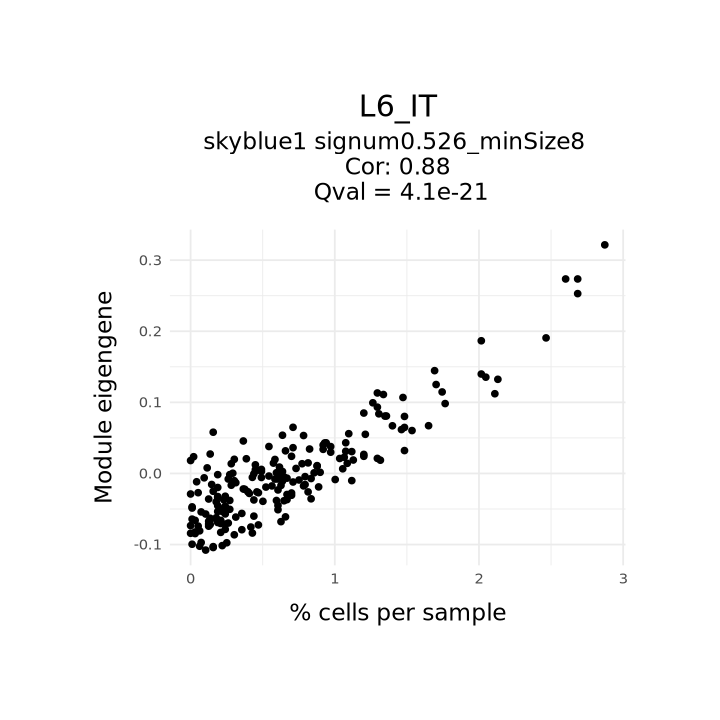

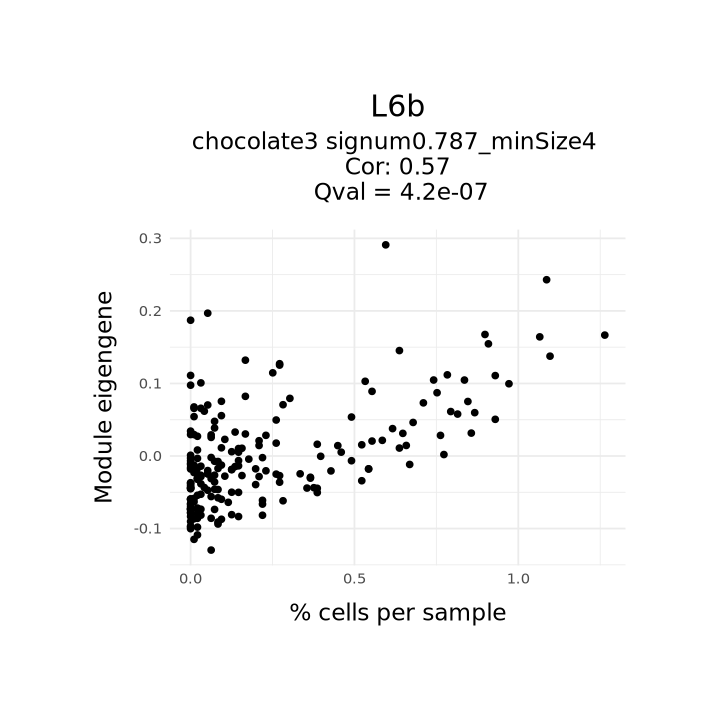

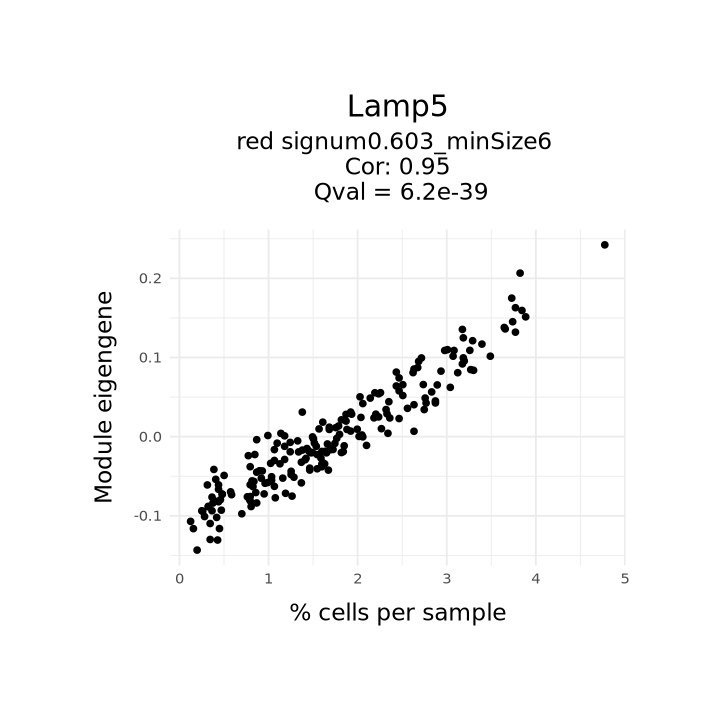

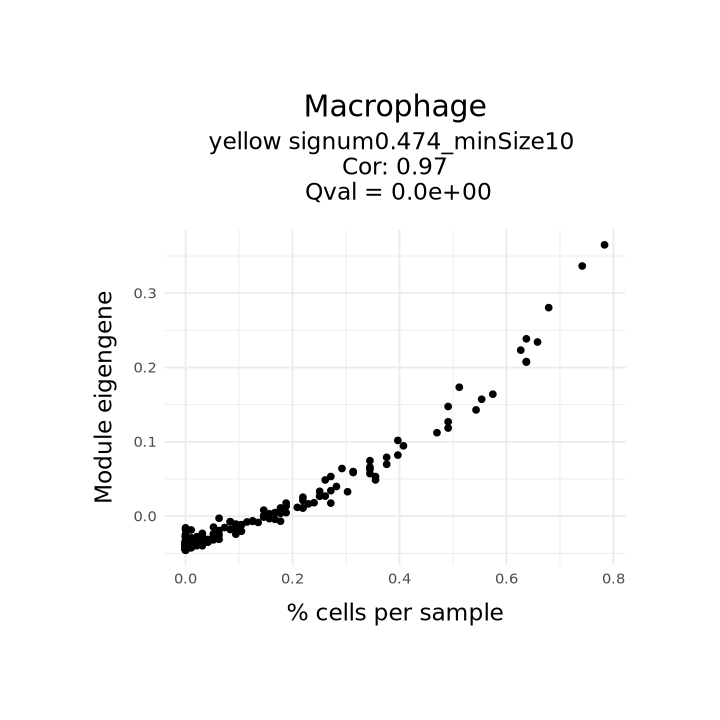

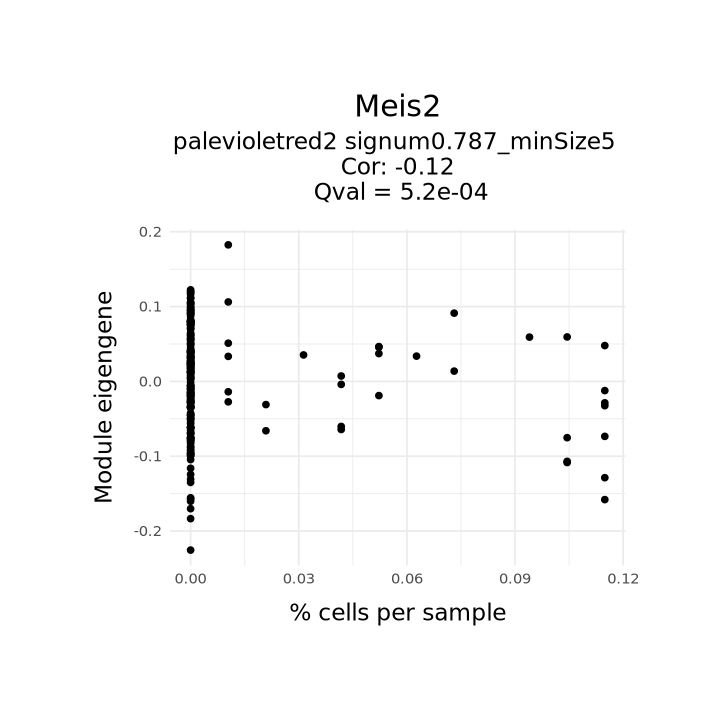

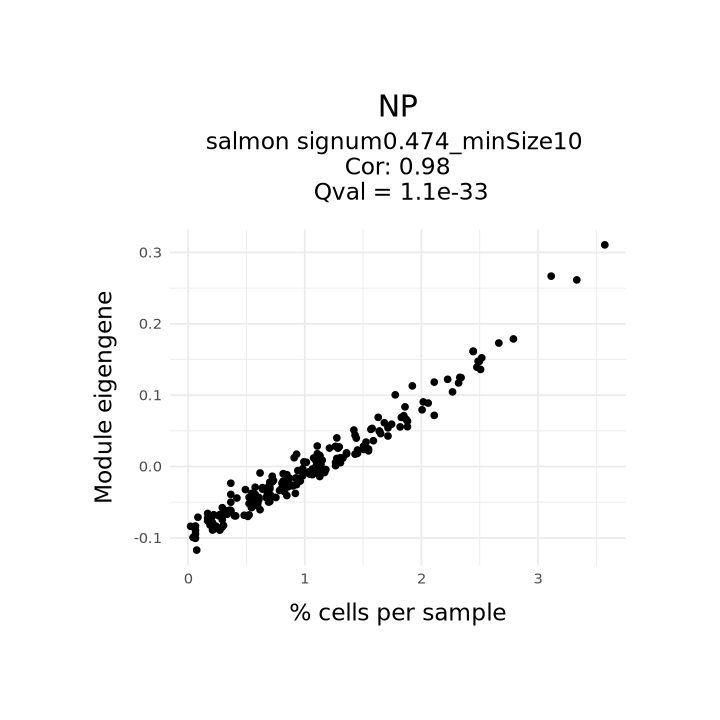

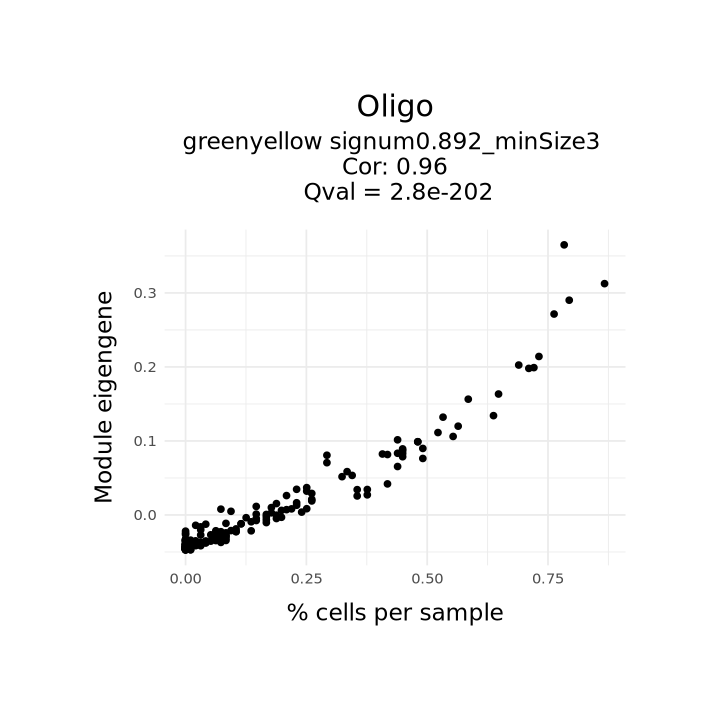

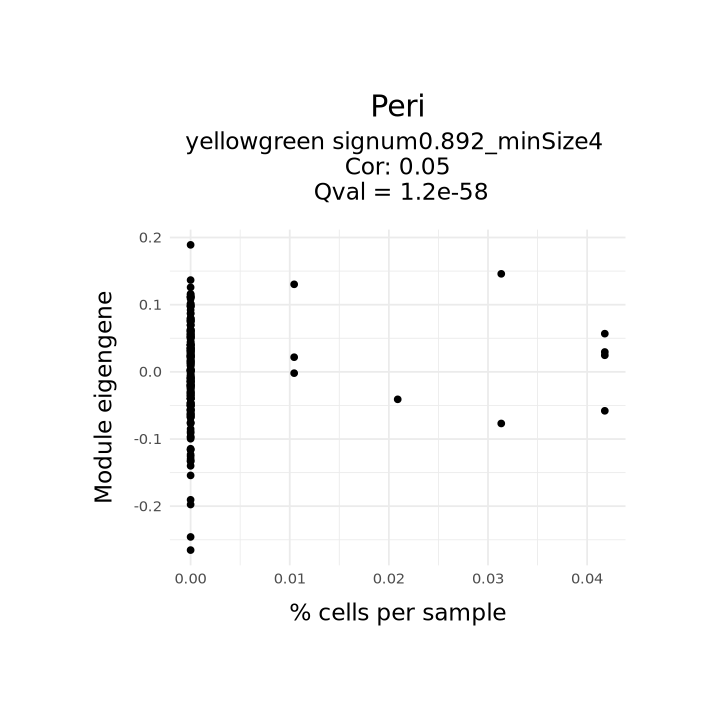

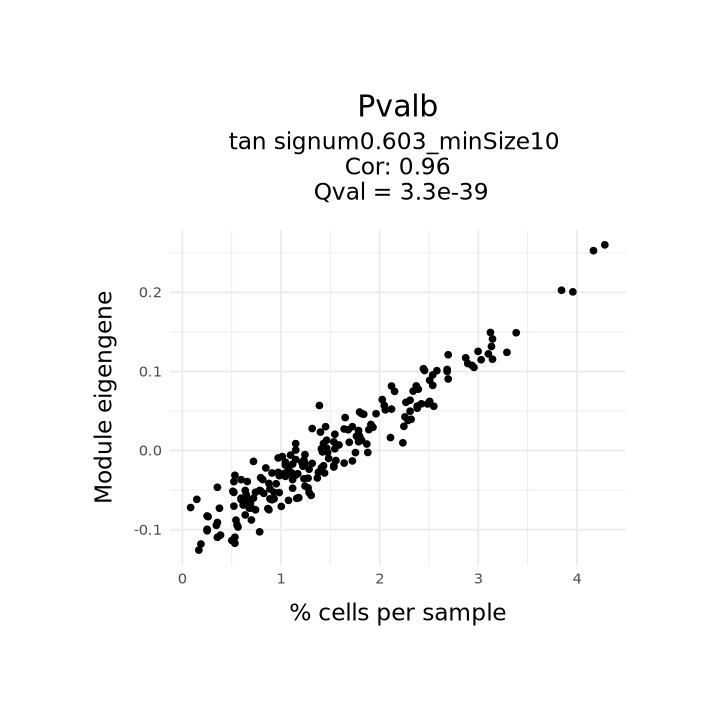

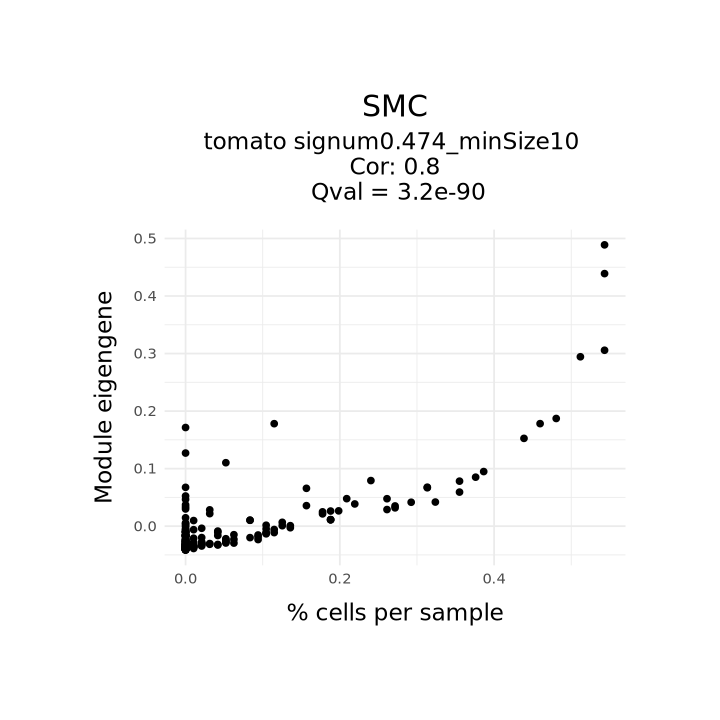

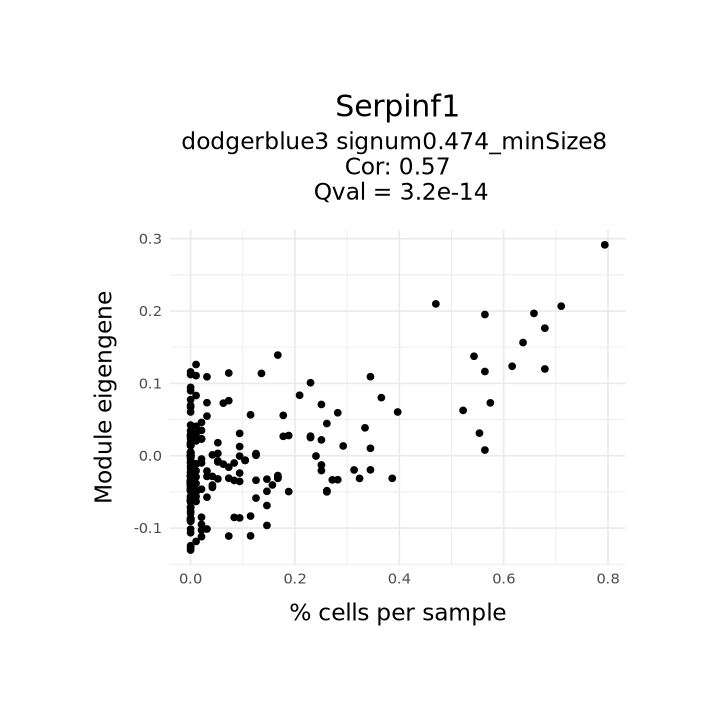

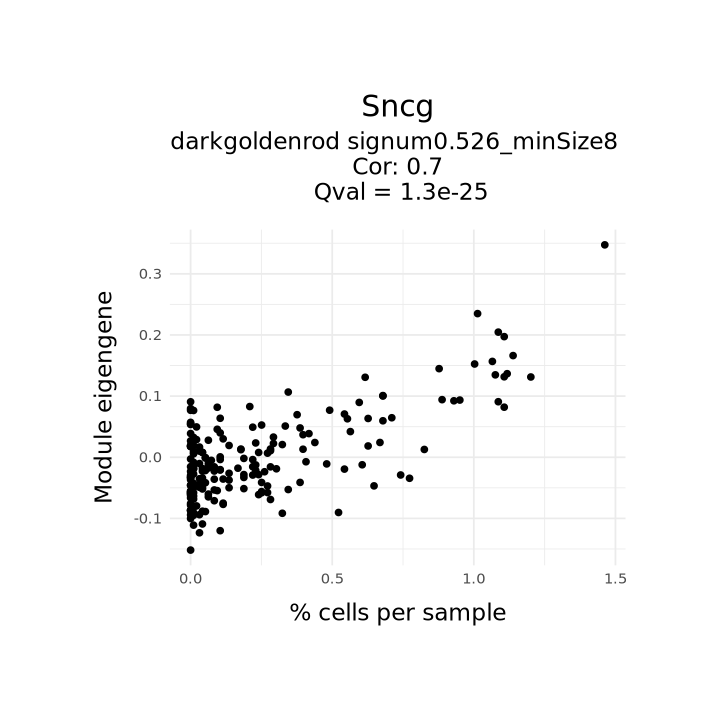

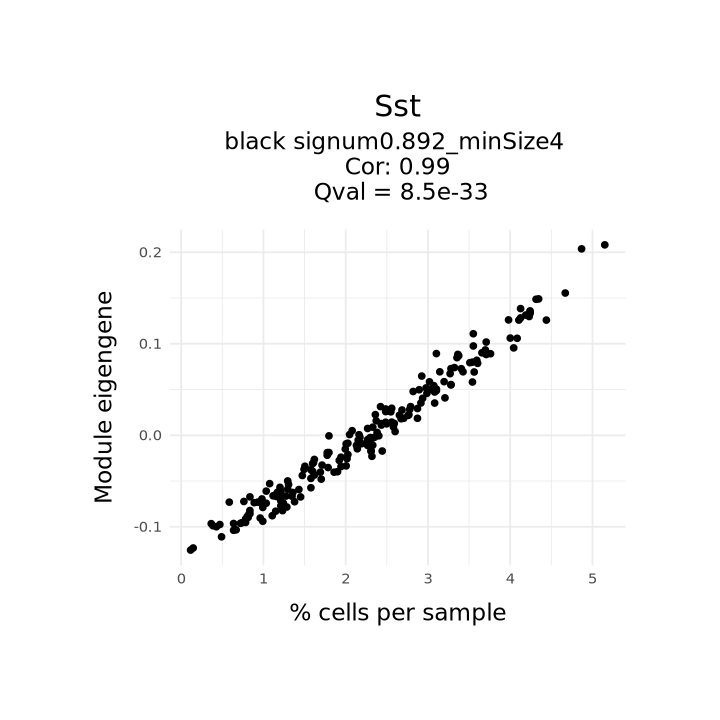

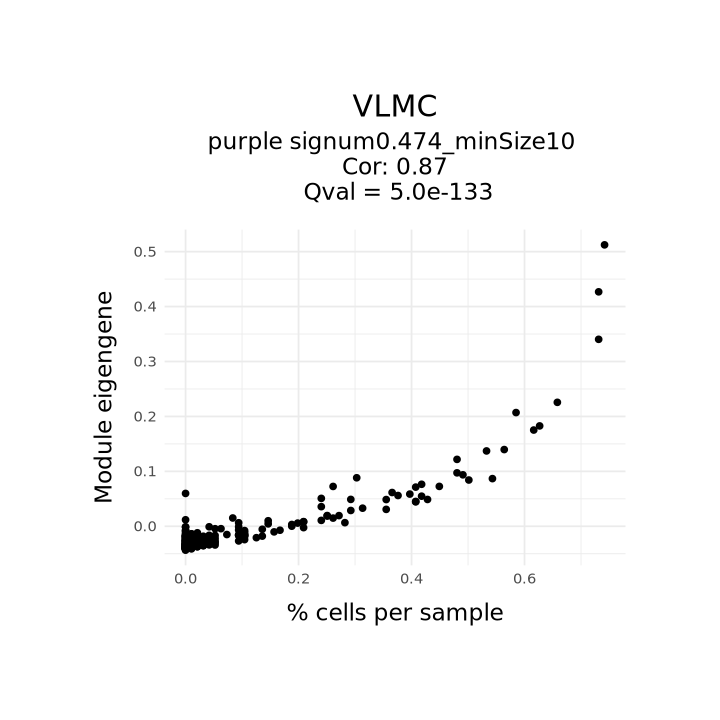

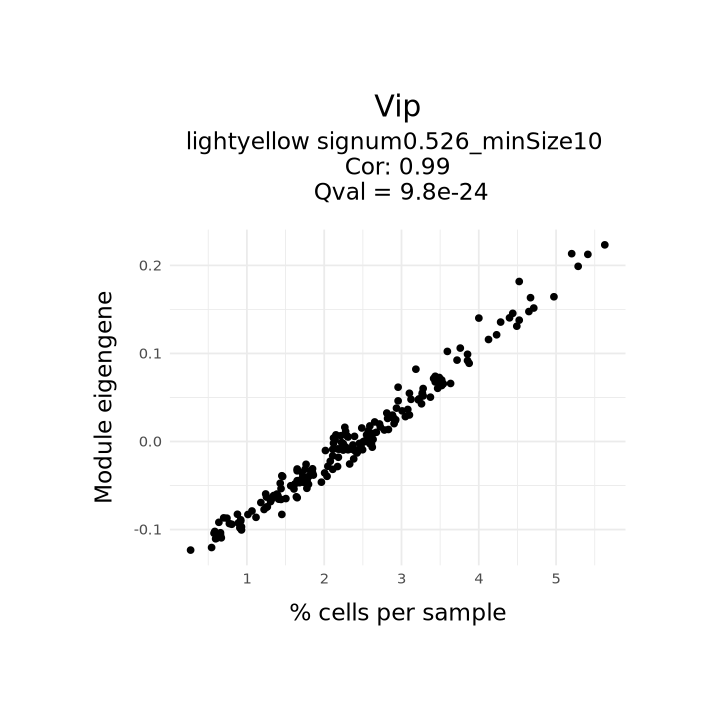

In [46]:
plot_ctype_abundance_vs_ME(pseudobulk_legend, top_qval_mods_df)

# Concatonate results

In [34]:
top_corr_mods_0.4pcnt_PosBC_df$Data <- "0.4pcnt_PosBC"
# top_corr_mods_0.4pcnt_PosFDR_df$Data <- "0.4pcnt_PosFDR"

# top_corr_mods_10pcnt_PosBC_df$Data <- "10pcnt_PosBC"
# top_corr_mods_10pcnt_PosFDR_df$Data <- "10pcnt_PosFDR"

top_corr_mods_50pcnt_PosBC_df$Data <- "50pcnt_PosBC"
# top_corr_mods_50pcnt_PosFDR_df$Data <- "50pcnt_PosFDR"

top_corr_mods_25kappa_PosBC_df$Data <- "25kappa_PosBC"

top_corr_mods_25kappa_merge0.85_PosBC_df$Data <- "25kappa_merge0.85_PosBC"

top_corr_mods_25kappa_nolog_PosBC_df$Data <- "25kappa_nolog_PosBC"

In [35]:
cols_idx <- which(colnames(top_corr_mods_0.4pcnt_PosBC_df) %in% c("Cell_type", "Cor", "Old_cor", "Pseudobulk_SD"))

In [36]:
colnames(top_corr_mods_0.4pcnt_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_0.4pcnt_PosBC_df)[-1], "_", top_corr_mods_0.4pcnt_PosBC_df$Data[1]
)

# colnames(top_corr_mods_0.4pcnt_PosFDR_df)[-1] <- paste0(
#     colnames(top_corr_mods_0.4pcnt_PosFDR_df)[-1], "_", top_corr_mods_0.4pcnt_PosFDR_df$Data[1]
# )

# colnames(top_corr_mods_10pcnt_PosBC_df)[-1] <- paste0(
#     colnames(top_corr_mods_10pcnt_PosBC_df)[-1], "_", top_corr_mods_10pcnt_PosBC_df$Data[1]
# ) 

# colnames(top_corr_mods_10pcnt_PosFDR_df)[-1] <- paste0(
#     colnames(top_corr_mods_10pcnt_PosFDR_df)[-1], "_", top_corr_mods_10pcnt_PosFDR_df$Data[1]
# ) 

colnames(top_corr_mods_50pcnt_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_50pcnt_PosBC_df)[-1], "_", top_corr_mods_50pcnt_PosBC_df$Data[1]
)

# colnames(top_corr_mods_50pcnt_PosFDR_df)[-1] <- paste0(
#     colnames(top_corr_mods_50pcnt_PosFDR_df)[-1], "_", top_corr_mods_50pcnt_PosFDR_df$Data[1]
# )

colnames(top_corr_mods_25kappa_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_25kappa_PosBC_df)[-1], "_", top_corr_mods_25kappa_PosBC_df$Data[1]
)

colnames(top_corr_mods_25kappa_merge0.85_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_25kappa_merge0.85_PosBC_df)[-1], "_", top_corr_mods_25kappa_merge0.85_PosBC_df$Data[1]
)

colnames(top_corr_mods_25kappa_nolog_PosBC_df)[-1] <- paste0(
    colnames(top_corr_mods_25kappa_nolog_PosBC_df)[-1], "_", top_corr_mods_25kappa_nolog_PosBC_df$Data[1]
)

### Compare PosBC results

In [37]:
# top_corr_mods_BC_df <- merge(
#     top_corr_mods_0.4pcnt_PosBC_df[,cols_idx],
#     top_corr_mods_10pcnt_PosBC_df[,cols_idx],
#     by="Cell_type", all=TRUE, sort=FALSE
# )

top_corr_mods_BC_df <- merge(
    top_corr_mods_0.4pcnt_PosBC_df[,cols_idx],
    top_corr_mods_50pcnt_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    top_corr_mods_25kappa_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

# top_corr_mods_BC_df <- merge(
#     top_corr_mods_BC_df,
#     top_corr_mods_25kappa_merge0.85_PosBC_df[,cols_idx],
#     by="Cell_type", all=TRUE, sort=FALSE
# )

top_corr_mods_BC_df <- merge(
    top_corr_mods_BC_df,
    top_corr_mods_25kappa_nolog_PosBC_df[,cols_idx],
    by="Cell_type", all=TRUE, sort=FALSE
)

top_corr_mods_BC_df <- top_corr_mods_BC_df[,order(colnames(top_corr_mods_BC_df))]

In [38]:
top_corr_mods_BC_df

Cell_type  Cor_0.4pcnt_PosBC Cor_25kappa_nolog_PosBC Cor_25kappa_PosBC
1  Lamp5      0.1939443         0.9897281               0.9912068        
2  Sst        0.2001982         0.9914202               0.9939074        
3  Vip        0.2119883         0.9880487               0.9896692        
4  CR         0.2291747         0.2300683               0.2303541        
5  Pvalb      0.2500620         0.9903057               0.9934442        
6  Meis2      0.2845981         0.3197981               0.3125991        
7  L5_IT      0.2855019         0.9829472               0.9793463        
8  Serpinf1   0.7316211         0.5693761               0.4026167        
9  Sncg       0.8643323         0.7011322               0.6889803        
10 VLMC       0.9211118         0.8802448               0.9117353        
11 Oligo      0.9389186         0.9637300               0.9823470        
12 L6_IT      0.9476400         0.9029690               0.9108326        
13 SMC        0.9590460         0.8564179               0.8800080        
14 L2_3_IT    0.9661427         0.9786095               0.9793319        
15 Endo       0.9694787         0.9821506               0.9963366        
16 Macrophage 0.9739987         0.9714174               0.9965619        
17 Macrophage 0.9739987         0.9714174               0.9965619        
18 L6_CT      0.9763351         0.9847716               0.9857231        
19 Astro      0.9832529         0.9780475               0.9940807        
20 L5_PT      0.9853628         0.9826412               0.9832736        
21 NP         0.9903595         0.9866012               0.9899614        
22 L6b        0.9278851         0.5733157               0.5722537        
23 Peri              NA         0.1944085               0.1932410        
24 L4                NA                NA                      NA        
   Cor_50pcnt_PosBC Old_cor_0.4pcnt_PosBC Old_cor_25kappa_nolog_PosBC
1  0.9250482        -0.022435143           0.95035317                
2  0.9083775        -0.042783507           0.98557814                
3  0.9058163        -0.004228451           0.98675899                
4  0.1490367         0.129101599          -0.05805480                
5  0.9241352        -0.213812093           0.95680939                
6  0.1785107         0.149229893          -0.12495399                
7  0.9284386        -0.034604339           0.94872014                
8  0.1938398         0.276181507           0.56937609                
9  0.1320302         0.598679043           0.70113222                
10 0.8453615         0.921111791           0.87387963                
11 0.8554086         0.937577729           0.96228492                
12 0.7960936         0.939846037           0.88095034                
13 0.8828202         0.958120433           0.79531759                
14 0.8873879         0.777403570           0.73656553                
15 0.9001138         0.963371462           0.97748455                
16 0.8790042         0.952347615           0.96833512                
17 0.8790042         0.952347615           0.96833512                
18 0.9035261         0.960360097           0.98076481                
19 0.8945385         0.976700865           0.96521325                
20 0.9086067         0.985362817           0.98132944                
21 0.9274852         0.981980809           0.97710219                
22        NA         0.922030212           0.57331574                
23 0.1873673                  NA           0.05282139                
24 0.2015220                  NA                   NA                
   Old_cor_25kappa_PosBC Old_cor_50pcnt_PosBC Pseudobulk_SD_0.4pcnt_PosBC
1   0.95672816            0.86207782           3.46                      
2   0.98827527            0.90084316           4.61                      
3   0.98710093            0.87250655           3.84                      
4  -0.06763805           -0.04376170           0.50                      
5   0.95402249            0.76534

In [43]:
# top_corr_mods_BC_df %>% 
#     arrange(-Old_cor_50pcnt_PosBC) %>%
#     filter(
#         (Old_cor_10pcnt_PosBC > Old_cor_50pcnt_PosBC) & 
#         (Old_cor_10pcnt_PosBC > Old_cor_0.4pcnt_PosBC)
#     )

10% variation performs worse than the other two for all cell types

In [44]:
# Which 50% modules outperform 0.4%?

top_corr_mods_BC_df %>% 
    arrange(-Old_cor_50pcnt_PosBC) %>%
    filter(Old_cor_50pcnt_PosBC > Old_cor_0.4pcnt_PosBC)

Cell_type Cor_0.4pcnt_PosBC Cor_25kappa_merge0.85_PosBC Cor_25kappa_PosBC
1 L5_IT     0.2855019         0.9805647                   0.9793463        
2 Sst       0.2001982         0.9899247                   0.9939074        
3 Vip       0.2119883         0.9896692                   0.9896692        
4 Lamp5     0.1939443         0.9922547                   0.9912068        
5 Pvalb     0.2500620         0.9720580                   0.9934442        
  Cor_50pcnt_PosBC Old_cor_0.4pcnt_PosBC Old_cor_25kappa_merge0.85_PosBC
1 0.9284386        -0.034604339          0.9579106                      
2 0.9083775        -0.042783507          0.9770915                      
3 0.9058163        -0.004228451          0.9732187                      
4 0.9250482        -0.022435143          0.9779603                      
5 0.9241352        -0.213812093          0.8821020                      
  Old_cor_25kappa_PosBC Old_cor_50pcnt_PosBC Pseudobulk_SD_0.4pcnt_PosBC
1 0.9566102             0.9062203            5.73                       
2 0.9882753             0.9008432            4.61                       
3 0.9871009             0.8725066            3.84                       
4 0.9567282             0.8620778            3.46                       
5 0.9540225             0.7653460            3.74                       
  Pseudobulk_SD_25kappa_merge0.85_PosBC Pseudobulk_SD_25kappa_PosBC
1 122.86                                122.86                     
2 105.61                                105.61                     
3 103.59                                103.59                     
4  94.14                                 94.14                     
5  82.02                                 82.02                     
  Pseudobulk_SD_50pcnt_PosBC
1 159.80                    
2  73.23                    
3  79.61                    
4  59.44                    
5  59.91

Interestingly all the inhibitory cell types... with the exception of L5_IT, which had a much much greater variability in cell type proportion across samples...

They also all happen to be the most abundant cell types in terms of raw number of cells in this dataset

In [ ]:
# Which 0.4% outperform 50%?

top_corr_mods_BC_df %>% 
    arrange(-Old_cor_50pcnt_PosBC) %>%
    filter(Old_cor_0.4pcnt_PosBC > Old_cor_50pcnt_PosBC)

Cell_type  Cor_0.4pcnt_PosBC Cor_10pcnt_PosBC Cor_50pcnt_PosBC
1  NP         0.9903595         0.6424483        0.9274852       
2  L5_PT      0.9853628         0.4496355        0.9086067       
3  Endo       0.9694787         0.5163198        0.9001138       
4  Astro      0.9832529         0.5454351        0.8945385       
5  Macrophage 0.9739987         0.5541167        0.8790042       
6  Macrophage 0.9739987         0.5541167        0.8790042       
7  SMC        0.9590460         0.3581447        0.8828202       
8  L6_CT      0.9763351         0.4346011        0.9035261       
9  VLMC       0.9211118         0.2176395        0.8453615       
10 Oligo      0.9389186         0.3083297        0.8554086       
11 L6_IT      0.9476400         0.3912662        0.7960936       
12 L2_3_IT    0.9661427         0.4443491        0.8873879       
13 Sncg       0.8643323         0.2376732        0.1320302       
14 Serpinf1   0.7316211         0.2191469        0.1938398       
15 CR         0.2291747         0.2723505        0.1490367       
16 Meis2      0.2845981         0.2200408        0.1785107       
   Old_cor_0.4pcnt_PosBC Old_cor_10pcnt_PosBC Old_cor_50pcnt_PosBC
1  0.9819808             0.63868408            0.90239443         
2  0.9853628             0.41607542            0.89459633         
3  0.9633715             0.39715810            0.89385788         
4  0.9767009             0.46270702            0.88709521         
5  0.9523476             0.38740222            0.87409913         
6  0.9523476             0.38740222            0.87358583         
7  0.9581204             0.35386647            0.87072285         
8  0.9603601             0.42529993            0.83224451         
9  0.9211118             0.09400113            0.83210083         
10 0.9375777             0.10097966            0.82541326         
11 0.9398460             0.37324554            0.69452226         
12 0.7774036             0.27588970            0.63916993         
13 0.5986790             0.11588496            0.08311361         
14 0.2761815             0.04851468            0.07748015         
15 0.1291016             0.12232763           -0.04376170         
16 0.1492299             0.02326452           -0.08011696         
   Pseudobulk_SD_0.4pcnt_PosBC Pseudobulk_SD_10pcnt_PosBC
1  28.82                       6.20                      
2  20.82                       4.15                      
3   5.20                       1.66                      
4  11.57                       2.78                      
5   4.47                       1.56                      
6   4.47                       1.56                      
7   2.93                       1.14                      
8  18.71                       3.86                      
9   3.63                       1.24                      
10  5.30                       1.61                      
11 21.58                       4.70                      
12 17.37                       3.98                      
13  8.13                       2.37                      
14  4.20                       1.60                      
15  0.50                       0.50                      
16  0.50                       0.50                      
   Pseudobulk_SD_50pcnt_PosBC
1  36.20                     
2  26.19                     
3   7.03                     
4  14.49                     
5   5.79                     
6   5.79                     
7   4.11                     
8  24.18                     
9   5.17                     
10  7.05                     
11 25.63                     
12 21.31                     
13 10.18                     
14  5.23                     
15  0.79                     
16  0.74

### Some cell types that are not being well identified in **any** dataset:

No modules exist:
- Meis2 (11 cells)
- CR (11 cells)
- Peri (4 cells)
- L4 (3 cells)

Modules exist, but not being identified
- Serpinf1 (78 cells)
- Sncg (148 cells)

Modules exist, "decent" but not great modules being identifeid 
- L2_3_IT (325 cells)

In [44]:
# Which 0.4% outperform 25 kappa?

top_corr_mods_BC_df %>% 
    arrange(-Cor_25kappa_nolog_PosBC) %>%
    filter(Cor_0.4pcnt_PosBC > Cor_25kappa_nolog_PosBC) %>%
    filter(Cor_25kappa_nolog_PosBC < .9)

Cell_type Cor_0.4pcnt_PosBC Cor_25kappa_nolog_PosBC Cor_25kappa_PosBC
1 VLMC      0.9211118         0.8802448               0.9117353        
2 SMC       0.9590460         0.8564179               0.8800080        
3 Sncg      0.8643323         0.7011322               0.6889803        
4 L6b       0.9278851         0.5733157               0.5722537        
5 Serpinf1  0.7316211         0.5693761               0.4026167        
  Cor_50pcnt_PosBC Old_cor_0.4pcnt_PosBC Old_cor_25kappa_nolog_PosBC
1 0.8453615        0.9211118             0.8738796                  
2 0.8828202        0.9581204             0.7953176                  
3 0.1320302        0.5986790             0.7011322                  
4        NA        0.9220302             0.5733157                  
5 0.1938398        0.2761815             0.5693761                  
  Old_cor_25kappa_PosBC Old_cor_50pcnt_PosBC Pseudobulk_SD_0.4pcnt_PosBC
1 0.9013659             0.83210083           3.63                       
2 0.8800080             0.87072285           2.93                       
3 0.6695334             0.08311361           8.13                       
4 0.5722537                     NA           7.40                       
5 0.3097927             0.07748015           4.20                       
  Pseudobulk_SD_25kappa_nolog_PosBC Pseudobulk_SD_25kappa_PosBC
1 16.84                             16.84                      
2 11.55                             11.55                      
3 30.88                             30.88                      
4 27.72                             27.72                      
5 16.64                             16.64                      
  Pseudobulk_SD_50pcnt_PosBC
1  5.17                     
2  4.11                     
3 10.18                     
4    NA                     
5  5.23

In [47]:
cell_meta <- fread("/mnt/lareaulab/reliscu/projects/NSF_GRFP/data/scRNA-seq/tasic_2018/ALM/tasic_2018_ALM_STAR_sampleinfo.csv", data.table=FALSE)

In [51]:
n_cells <- data.frame(sort(table(cell_meta$cell_subclass)))
colnames(n_cells)[1] <- c("Cell_type")

df <- merge(
    top_corr_mods_BC_df[,c("Cell_type", "Pseudobulk_SD_25kappa_nolog_PosBC")],
    n_cells, by="Cell_type"
)
df %>%
    arrange(Freq)

Cell_type  Pseudobulk_SD_25kappa_nolog_PosBC Freq
1  L4             NA                               3
2  Peri         0.65                               4
3  CR           1.96                              11
4  Meis2        2.71                              11
5  SMC         11.55                              55
6  VLMC        16.84                              72
7  Serpinf1    16.64                              78
8  Macrophage  17.12                              85
9  Macrophage  17.12                              85
10 Endo        19.36                              96
11 Oligo       19.49                              98
12 L6b         27.72                             145
13 Sncg        30.88                             148
14 Astro       38.11                             215
15 NP          67.25                             542
16 Pvalb       82.02                             896
17 Lamp5       94.14                             913
18 Sst        105.61                            1139
19 Vip        103.59                            1224

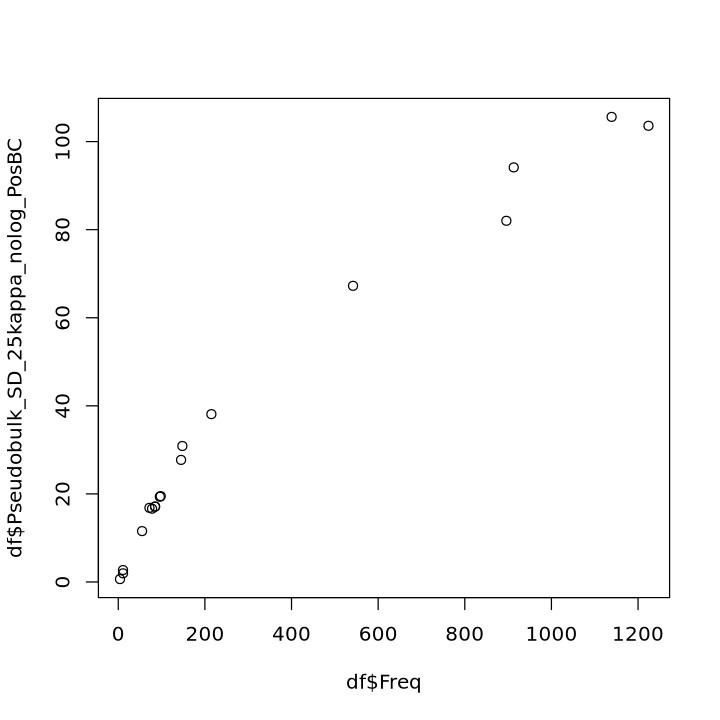

In [53]:
plot(df$Freq, df$Pseudobulk_SD_25kappa_nolog_PosBC)

In [ ]:
# It seems like if variability scales with the raw number of cell types, we can get the modules we need?

# I want uniform sampling around the true fraction of cell types, though, because low correlations for cell types like Serpinf1 seem to be driven by a concentration of lower % cells (closer to the true value)